# Deep Mean Shift Clustering

## Reqs

### Import

In [31]:
import mnist
import visdom
vis = visdom.Visdom(port='8097')
import pickle
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, Function, gradcheck

## Dataset

### Download

In [32]:
trans = transforms.Compose([transforms.ToTensor()])
root = '~/btp_mean_shift/data/mnist'
train = torchvision.datasets.MNIST(root, train=True, transform=trans, target_transform=None, download=True)
test = torchvision.datasets.MNIST(root, train=False, transform=trans, target_transform=None, download=True)

### Load

In [33]:
train_batch_size = 512
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=train_batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=test_batch_size,
                shuffle=True)

print ('total trainning batch number: '+ str(len(train_loader)))
print ('total testing batch number: '+ str(len(test_loader)))

total trainning batch number: 118
total testing batch number: 100


## Plotter

In [34]:
def plot_regen(model):

    for batch_idx, (x, target) in enumerate(test_loader):

        train_image = x
        break

    fig=plt.figure(figsize=(10,40))

    num_im = 4
    for i in range(num_im):
        data = np.array(train_image[i], dtype='float')
        data = data.reshape((28, 28))
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(data, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

    fig=plt.figure(figsize=(10,40))

    data = train_image.float()
    out, embed = model(data.cuda())
    out = out.cpu().detach().numpy()

    num_im = 4
    for i in range(num_im):
        out1 = out[i].reshape((28, 28))
        out1 = np.array(out1, dtype='float')
        
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(out1, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()


# AE Def

## Backbone + Regen

In [35]:
class AE(nn.Module):
    def __init__(self, z_len):
        super(AE, self).__init__()

        self.conv_1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.ind1 = 0
        self.ind2 = 0
        self.conv_2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_2 = nn.Linear(500,z_len)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.upfc_1 = nn.Linear(z_len, 500)
        self.upfc_2 = nn.Linear(500, 4*4*50)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.upconv_1 = nn.ConvTranspose2d(50, 20, kernel_size=5, stride=1)
        self.upconv_2 = nn.ConvTranspose2d(20, 1, kernel_size=5, stride=1)  

    def encode(self, x):
        z = self.conv_1(x)
        z = self.relu(z)
        z, self.ind1 = self.pool(z)
        z = self.conv_2(z)
        z = self.relu(z)
        z, self.ind2 = self.pool(z)
        z = z.view(z.size(0), -1)
        z = self.fc_1(z)
        z = self.relu(z)
        z = self.fc_2(z)
        z_norm = z.norm(p=2, dim=1, keepdim=True).detach()
        z = z.div(z_norm.expand_as(z))
        return z
    def decode(self, z):
        x = self.upfc_1(z)
        x = self.relu(x)
        x = self.upfc_2(x)
        x = x.view(x.size(0), 50, 4, 4)
        x = self.unpool(x, self.ind2)
        x = self.relu(x)
        x = self.upconv_1(x)
        x = self.unpool(x, self.ind1)
        x = self.relu(x)
        x = self.upconv_2(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_ = self.decode(z)
        return x_, z

## Mean Shift Cluster

In [36]:
class Mean_Shift_Cluster(torch.nn.Module):

    def __init__(self, delta, eta, ms_iter):
        super(Mean_Shift_Cluster, self).__init__()
        self.delta = delta
        self.eta = eta
        self.ms_iter = ms_iter

    def mean_shift_once(self, X):
        S = torch.mm(X.t(), X)
        K = torch.exp(self.delta * self.delta * S)
        N = list(X.size())[1]
        d = torch.mm(K.t(), torch.ones(N, 1).cuda())
        q = 1 / d
        D_inv = torch.diagflat(q)
        eye = torch.eye(N).cuda()
        P = ((1-self.eta) * eye) + (self.eta * torch.mm(K, D_inv))
        new_X = torch.mm(X, P)
        
        norm = new_X.norm(p=2, dim=0, keepdim=True).detach()
        new_norm_X = new_X.div(norm.expand_as(new_X))
        
        return new_norm_X
  
    def forward(self, X):
        # dims: seq_len x embedding_dim_1 x batch_size
        
        clust_embs = self.mean_shift_once(X).unsqueeze(0)
        for it in range(1, self.ms_iter):
            clust_embs = torch.cat((clust_embs, self.mean_shift_once(clust_embs[it-1]).unsqueeze(0)))
        
        # dims: batch_size x seq_len x embedding_dim_1
        clust_embs = clust_embs.permute(2, 0, 1)
        
        return clust_embs

## Trajectory LSTM

In [37]:
class Path_LSTM(nn.Module):

    def __init__(self, embed_1, embed_2, num_layers=1):
        super(Path_LSTM , self).__init__() 
        
        self.embed_1 = embed_1
        self.embed_2 = embed_2
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.embed_1 , self.embed_2, batch_first=True, num_layers=self.num_layers).cuda()

    def forward(self , x):
        
        batch_size = x.size()[0]
        h0 = torch.randn(self.num_layers, batch_size, self.embed_2).cuda()
        c0 = torch.randn(self.num_layers, batch_size, self.embed_2).cuda()

        state = (h0, c0) 
        self.lstm.flatten_parameters()
        out, (h_n,c_n) = self.lstm(x, state) 
        sq_h_n = torch.squeeze(h_n)
        return sq_h_n

## Loss

In [38]:
class Loss(torch.nn.Module):

    def __init__(self, alpha):
        super(Loss, self).__init__()
        self.alpha = alpha
        self.mse = torch.nn.MSELoss(reduction='sum')
        
    def cluster_loss(self, embeddings, y):
        total =  len(y)
        loss_list = torch.zeros(total, total).cuda()
        elems = 0
        for i in range(total):
            for j in range(i+1, total):
                if y[i] == y[j]:
                    x = embeddings[i]
                    x_ = embeddings[j]
                    loss_list[i, j] = self.mse(x, x_)
                    elems += 1
        
        return loss_list.sum()/elems
  
    def regen_loss(self, X, X_):
        regen_loss = torch.sum(torch.mm((X-X_).view(1, -1), (X-X_).view(-1, 1)))/X.view(-1).size()[0]
        return regen_loss
    
    def forward(self, X, X_, embeddings, y):
        cluster_loss_weight = 100
        ms_loss = cluster_loss_weight*self.cluster_loss(embeddings, y)    
        ae_loss = self.regen_loss(X, X_)
        return ms_loss + ae_loss, ms_loss, ae_loss

## Weights

In [39]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)


# Model Init

## Params

In [42]:
alpha = 0.5 
eta = 1 
ms_iter = 10
delta = 1
total_epochs = 150
embedding_dim_1 = 64
embedding_dim_2 = 14
num_layers = 1

## Init

In [43]:
sname = 'pre_regen_shift_lstm_delta_1_norm_weight_100'

# Load pre-trained auto encoder
model = AE(embedding_dim_1)
model.load_state_dict(torch.load('/home/ankitas/btp_mean_shift/save/regen.pt'))
model = model.cuda()

ms_clust = Mean_Shift_Cluster(delta, eta, ms_iter)
path_embed = Path_LSTM(embedding_dim_1, embedding_dim_2, num_layers)
ms_ae_loss = Loss(alpha)

optimizer = optim.SGD(list(model.parameters()) + list(path_embed.lstm.parameters()), lr=0.01, momentum=0.9


# Train

epoch 0
epoch 0 batch 0 batch total loss 0.02213615
epoch 0 batch 0 batch cluster loss 0.0143915
epoch 0 batch 0 batch regen loss 0.0077446504
saving...



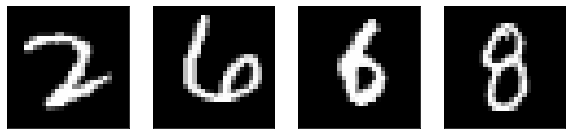

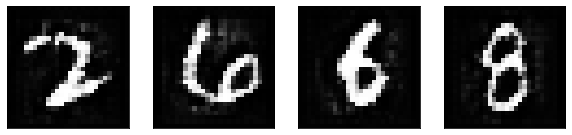

time taken in min: 0.04581425189971924
epoch 0 batch 50 batch total loss 0.009001135
epoch 0 batch 50 batch cluster loss 0.0014709018
epoch 0 batch 50 batch regen loss 0.007530233
saving...



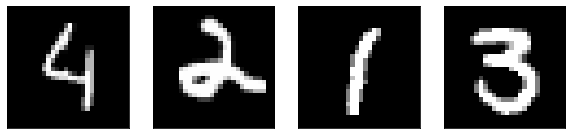

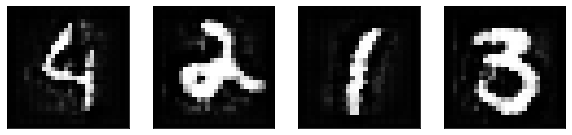

time taken in min: 2.1257813533147174
epoch 1 batch 50 batch total loss 0.0083107315
epoch 1 batch 50 batch cluster loss 0.00069873687
epoch 1 batch 50 batch regen loss 0.0076119946
saving...



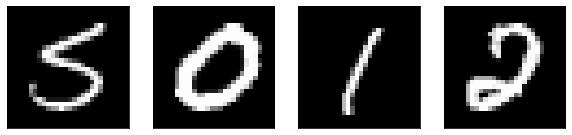

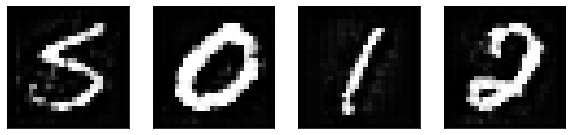

time taken in min: 2.1183711846669513
epoch 1 batch 100 batch total loss 0.0077720275
epoch 1 batch 100 batch cluster loss 0.0005573142
epoch 1 batch 100 batch regen loss 0.0072147134
saving...



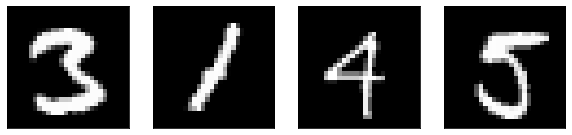

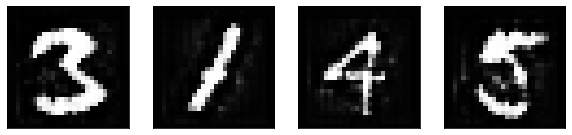

time taken in min: 2.120928231875102

epoch 1 epoch avg loss 0.008282796692860833
epoch 1 epoch avg cluster loss 0.0006995721980613672
epoch 1 epoch avg regen loss 0.007583224479014338



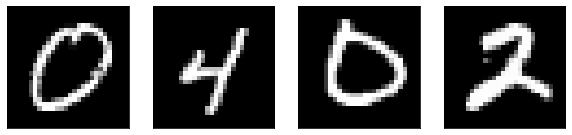

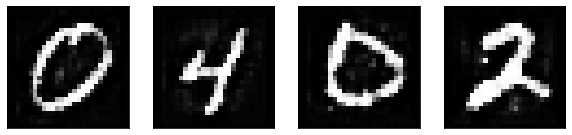

saving...

epoch 2
epoch 2 batch 0 batch total loss 0.008106032
epoch 2 batch 0 batch cluster loss 0.0005418065
epoch 2 batch 0 batch regen loss 0.0075642257
saving...



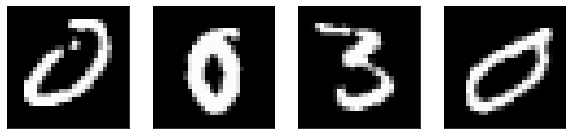

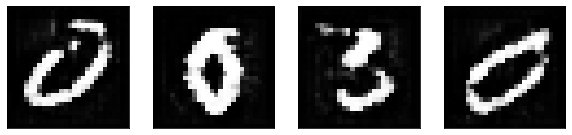

time taken in min: 0.7331361492474874
epoch 2 batch 50 batch total loss 0.007882731
epoch 2 batch 50 batch cluster loss 0.0005101761
epoch 2 batch 50 batch regen loss 0.007372555
saving...



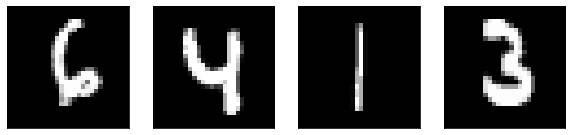

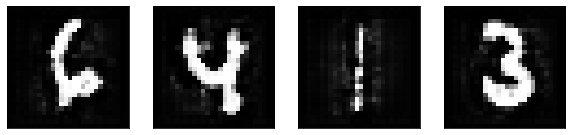

time taken in min: 2.118351380030314
epoch 2 batch 100 batch total loss 0.007924338
epoch 2 batch 100 batch cluster loss 0.00041772472
epoch 2 batch 100 batch regen loss 0.007506613
saving...



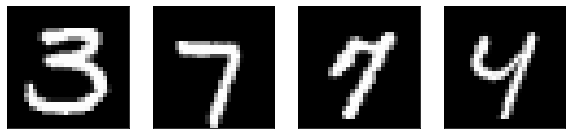

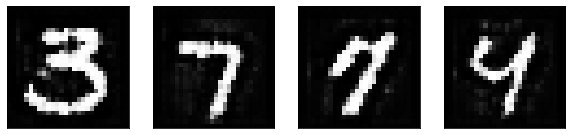

time taken in min: 2.124287760257721

epoch 2 epoch avg loss 0.00796707947659543
epoch 2 epoch avg cluster loss 0.0004745701621917976
epoch 2 epoch avg regen loss 0.007492509327229049



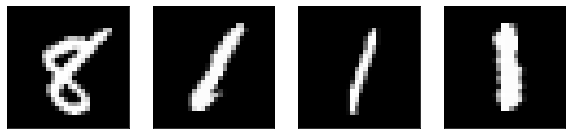

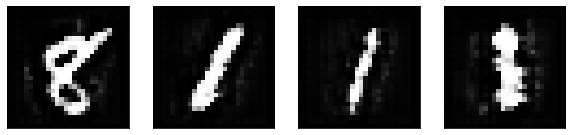

saving...

epoch 3
epoch 3 batch 0 batch total loss 0.007770376
epoch 3 batch 0 batch cluster loss 0.0004126352
epoch 3 batch 0 batch regen loss 0.007357741
saving...



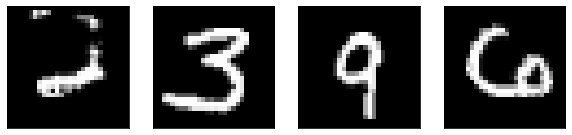

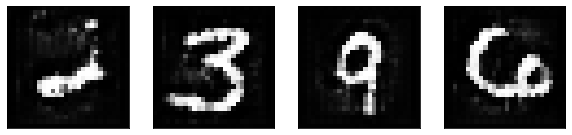

time taken in min: 0.7305376291275024
epoch 3 batch 50 batch total loss 0.007877279
epoch 3 batch 50 batch cluster loss 0.0003629051
epoch 3 batch 50 batch regen loss 0.007514374
saving...



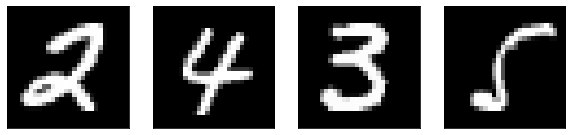

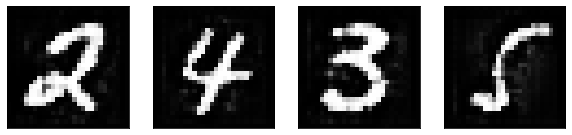

time taken in min: 2.1195423642794293
epoch 3 batch 100 batch total loss 0.0077404883
epoch 3 batch 100 batch cluster loss 0.00034721592
epoch 3 batch 100 batch regen loss 0.0073932726
saving...



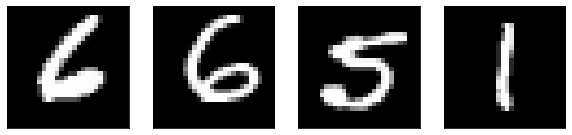

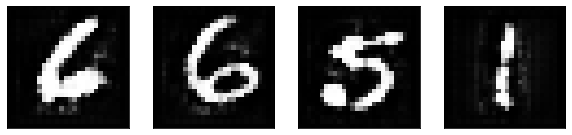

time taken in min: 2.120141025384267

epoch 3 epoch avg loss 0.007782779046002839
epoch 3 epoch avg cluster loss 0.0003636973994878768
epoch 3 epoch avg regen loss 0.007419081645528391



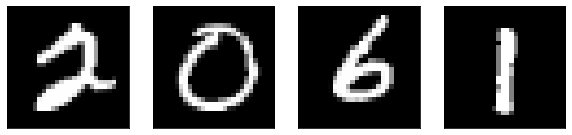

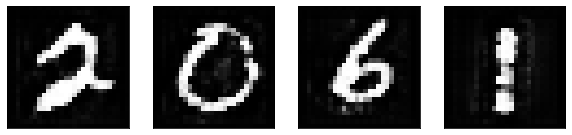

saving...

epoch 4
epoch 4 batch 0 batch total loss 0.007614856
epoch 4 batch 0 batch cluster loss 0.00033115465
epoch 4 batch 0 batch regen loss 0.0072837016
saving...



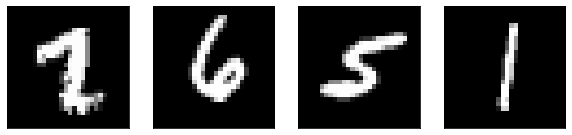

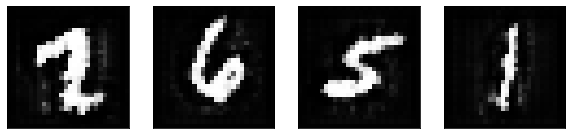

time taken in min: 0.7213594317436218
epoch 4 batch 50 batch total loss 0.0076913834
epoch 4 batch 50 batch cluster loss 0.00029337985
epoch 4 batch 50 batch regen loss 0.0073980037
saving...



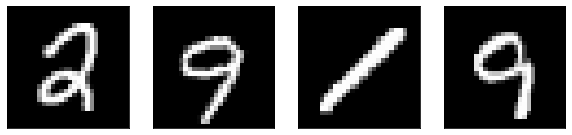

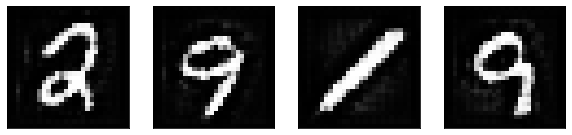

time taken in min: 2.0796884934107465
epoch 4 batch 100 batch total loss 0.00755283
epoch 4 batch 100 batch cluster loss 0.00027580588
epoch 4 batch 100 batch regen loss 0.007277024
saving...



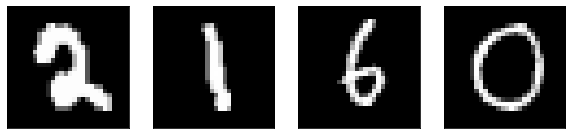

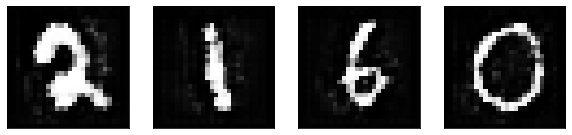

time taken in min: 2.095776597658793

epoch 4 epoch avg loss 0.007653016628602804
epoch 4 epoch avg cluster loss 0.0002988260720315847
epoch 4 epoch avg regen loss 0.0073541905612574295



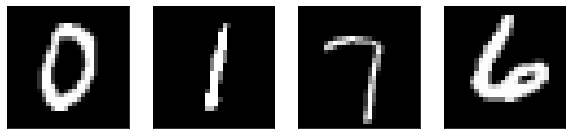

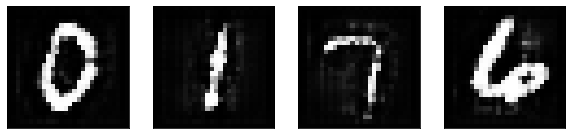

saving...

epoch 5
epoch 5 batch 0 batch total loss 0.007617446
epoch 5 batch 0 batch cluster loss 0.00026833414
epoch 5 batch 0 batch regen loss 0.007349112
saving...



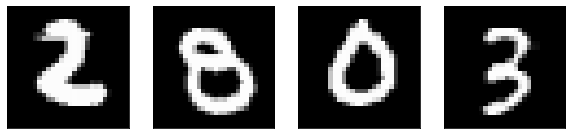

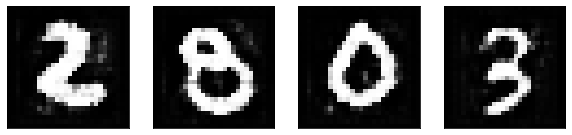

time taken in min: 0.7163147449493408
epoch 5 batch 50 batch total loss 0.0077205533
epoch 5 batch 50 batch cluster loss 0.00026668672
epoch 5 batch 50 batch regen loss 0.007453867
saving...



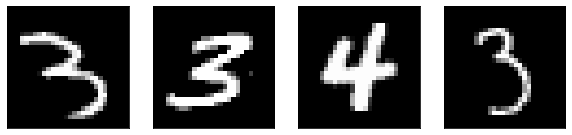

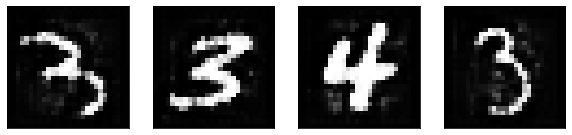

time taken in min: 2.07897576491038
epoch 5 batch 100 batch total loss 0.0074350187
epoch 5 batch 100 batch cluster loss 0.00024191626
epoch 5 batch 100 batch regen loss 0.0071931025
saving...



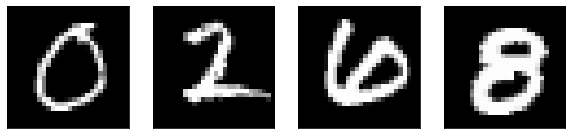

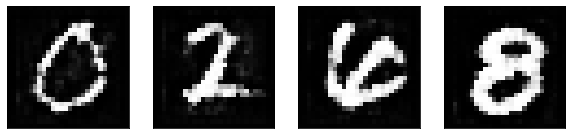

time taken in min: 2.0836700876553853

epoch 5 epoch avg loss 0.00755503649381384
epoch 5 epoch avg cluster loss 0.0002542878734194516
epoch 5 epoch avg regen loss 0.007300748623970707



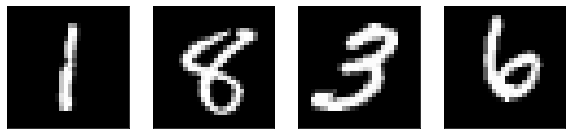

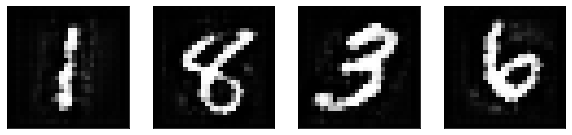

saving...

epoch 6
epoch 6 batch 0 batch total loss 0.0073561054
epoch 6 batch 0 batch cluster loss 0.0002353563
epoch 6 batch 0 batch regen loss 0.007120749
saving...



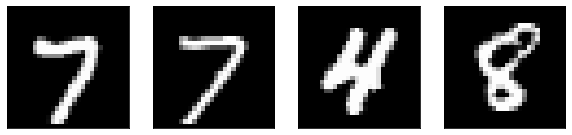

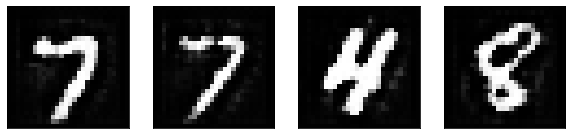

time taken in min: 0.7184006849924723
epoch 6 batch 50 batch total loss 0.0074479086
epoch 6 batch 50 batch cluster loss 0.00023600594
epoch 6 batch 50 batch regen loss 0.0072119026
saving...



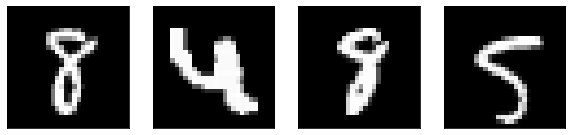

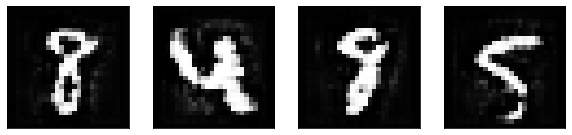

time taken in min: 2.089324943224589
epoch 6 batch 100 batch total loss 0.007416181
epoch 6 batch 100 batch cluster loss 0.00020651946
epoch 6 batch 100 batch regen loss 0.0072096614
saving...



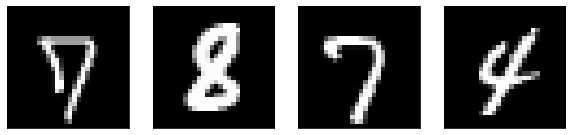

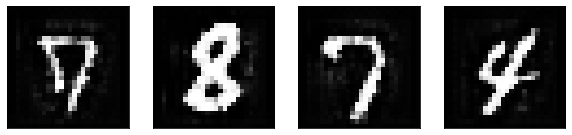

time taken in min: 2.0892625570297243

epoch 6 epoch avg loss 0.007467620556195409
epoch 6 epoch avg cluster loss 0.00022187416359853253
epoch 6 epoch avg regen loss 0.007245746401722653



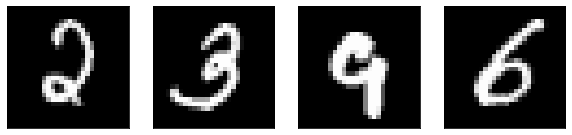

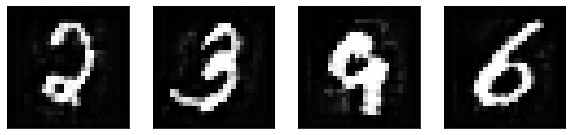

saving...

epoch 7
epoch 7 batch 0 batch total loss 0.007359071
epoch 7 batch 0 batch cluster loss 0.0002007598
epoch 7 batch 0 batch regen loss 0.0071583115
saving...



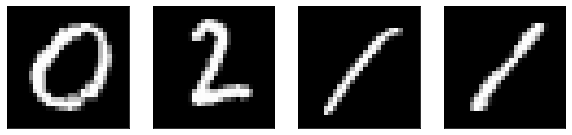

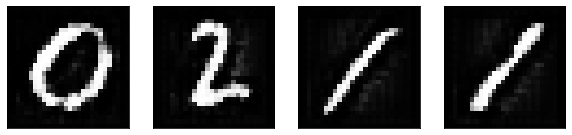

time taken in min: 0.7191028992335001
epoch 7 batch 50 batch total loss 0.0073979124
epoch 7 batch 50 batch cluster loss 0.00019389515
epoch 7 batch 50 batch regen loss 0.007204017
saving...



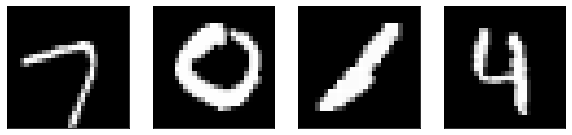

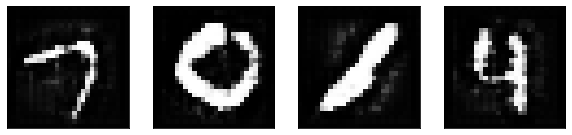

time taken in min: 2.0900448083877565
epoch 7 batch 100 batch total loss 0.0074961702
epoch 7 batch 100 batch cluster loss 0.00018208435
epoch 7 batch 100 batch regen loss 0.007314086
saving...



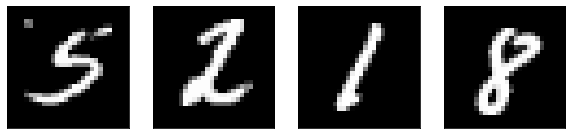

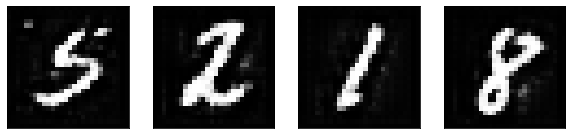

time taken in min: 2.0878337740898134

epoch 7 epoch avg loss 0.0073988605961519275
epoch 7 epoch avg cluster loss 0.00019626123191871664
epoch 7 epoch avg regen loss 0.00720259933969227



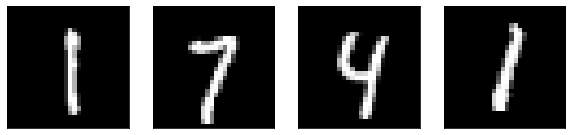

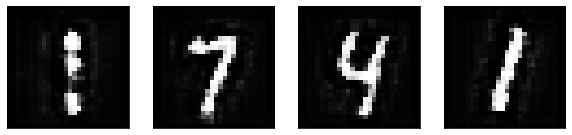

saving...

epoch 8
epoch 8 batch 0 batch total loss 0.007487052
epoch 8 batch 0 batch cluster loss 0.00017775313
epoch 8 batch 0 batch regen loss 0.007309299
saving...



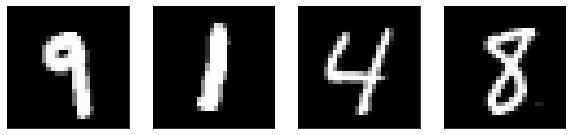

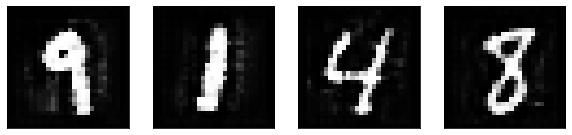

time taken in min: 0.7141176263491312
epoch 8 batch 50 batch total loss 0.007208006
epoch 8 batch 50 batch cluster loss 0.0001894697
epoch 8 batch 50 batch regen loss 0.0070185363
saving...



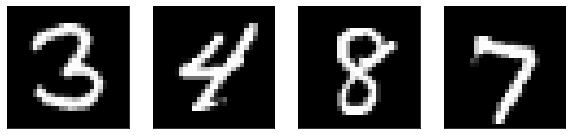

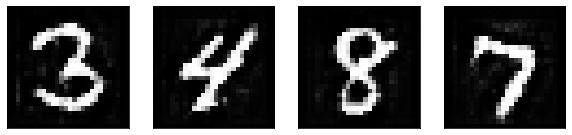

time taken in min: 2.0759010434150698
epoch 8 batch 100 batch total loss 0.0073122666
epoch 8 batch 100 batch cluster loss 0.00016443164
epoch 8 batch 100 batch regen loss 0.007147835
saving...



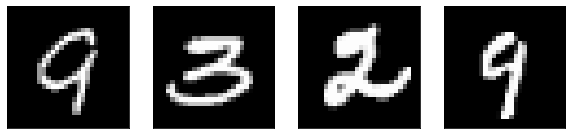

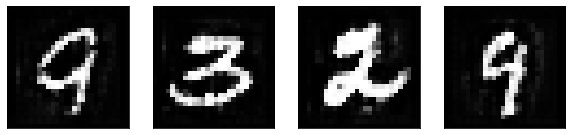

time taken in min: 2.0853716293970743

epoch 8 epoch avg loss 0.00733424282743264
epoch 8 epoch avg cluster loss 0.00017711279866427688
epoch 8 epoch avg regen loss 0.007157130024822081



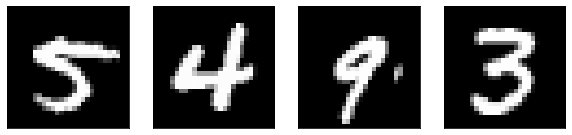

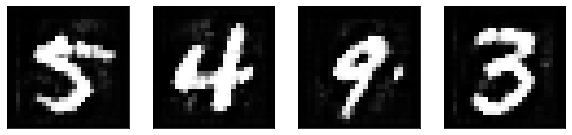

saving...

epoch 9
epoch 9 batch 0 batch total loss 0.0072042816
epoch 9 batch 0 batch cluster loss 0.00015984102
epoch 9 batch 0 batch regen loss 0.0070444406
saving...



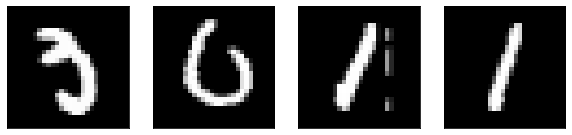

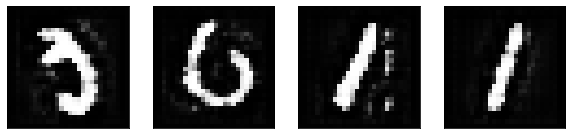

time taken in min: 0.7222496072451273
epoch 9 batch 50 batch total loss 0.007190591
epoch 9 batch 50 batch cluster loss 0.00015305905
epoch 9 batch 50 batch regen loss 0.007037532
saving...



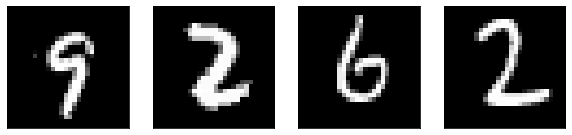

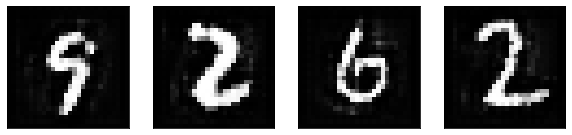

time taken in min: 2.090173129240672
epoch 9 batch 100 batch total loss 0.0072026197
epoch 9 batch 100 batch cluster loss 0.00015569536
epoch 9 batch 100 batch regen loss 0.0070469244
saving...



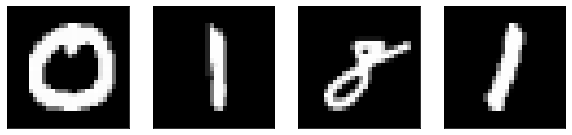

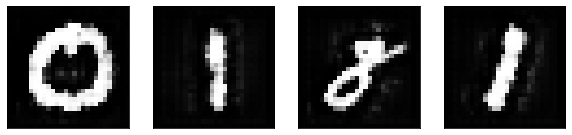

time taken in min: 2.0822919408480325

epoch 9 epoch avg loss 0.007276339006562859
epoch 9 epoch avg cluster loss 0.00016081943711901273
epoch 9 epoch avg regen loss 0.007115519554275325



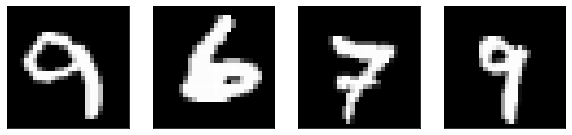

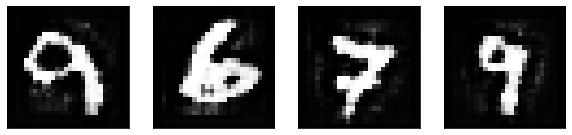

saving...

epoch 10
epoch 10 batch 0 batch total loss 0.0070594884
epoch 10 batch 0 batch cluster loss 0.00015882816
epoch 10 batch 0 batch regen loss 0.00690066
saving...



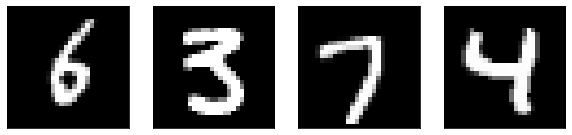

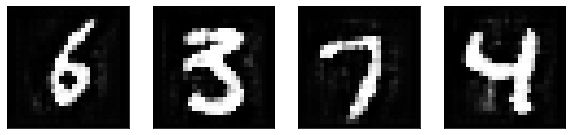

time taken in min: 0.718455417950948
epoch 10 batch 50 batch total loss 0.007128972
epoch 10 batch 50 batch cluster loss 0.00015673602
epoch 10 batch 50 batch regen loss 0.006972236
saving...



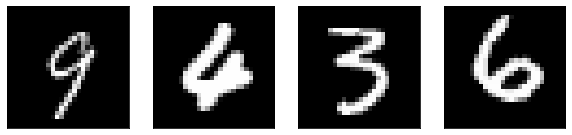

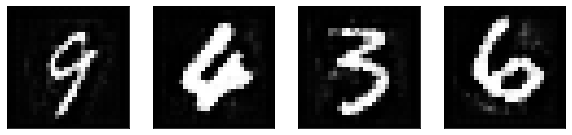

time taken in min: 2.080932811896006
epoch 10 batch 100 batch total loss 0.0072036255
epoch 10 batch 100 batch cluster loss 0.00013948335
epoch 10 batch 100 batch regen loss 0.0070641423
saving...



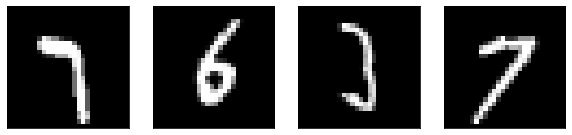

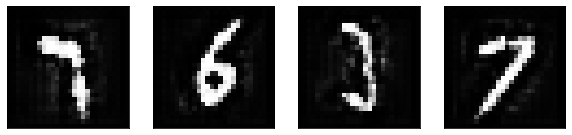

time taken in min: 2.0913389801979063

epoch 10 epoch avg loss 0.007226524298410799
epoch 10 epoch avg cluster loss 0.000148017845862403
epoch 10 epoch avg regen loss 0.007078506478692515



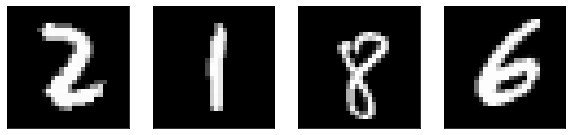

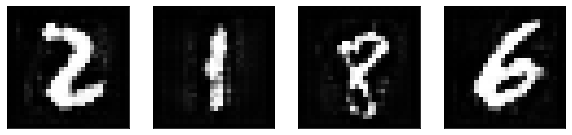

saving...

epoch 11
epoch 11 batch 0 batch total loss 0.0067942874
epoch 11 batch 0 batch cluster loss 0.00013953215
epoch 11 batch 0 batch regen loss 0.006654755
saving...



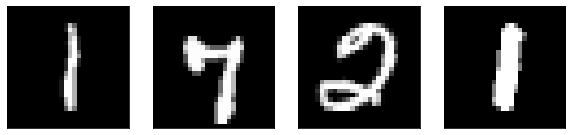

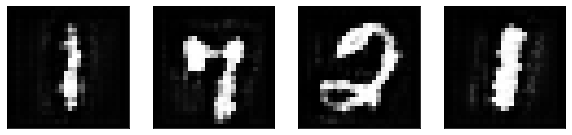

time taken in min: 0.7213169892628988
epoch 11 batch 50 batch total loss 0.0076689073
epoch 11 batch 50 batch cluster loss 0.00015102864
epoch 11 batch 50 batch regen loss 0.0075178784
saving...



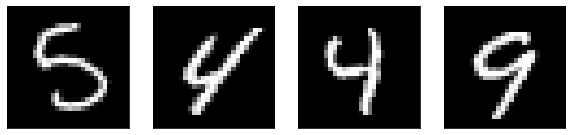

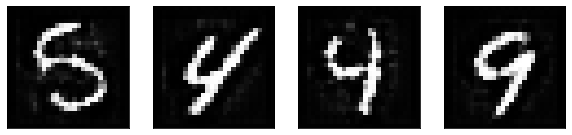

time taken in min: 2.0896330157915752
epoch 11 batch 100 batch total loss 0.00725901
epoch 11 batch 100 batch cluster loss 0.00014458128
epoch 11 batch 100 batch regen loss 0.0071144286
saving...



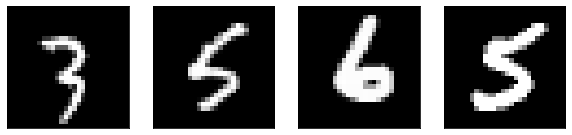

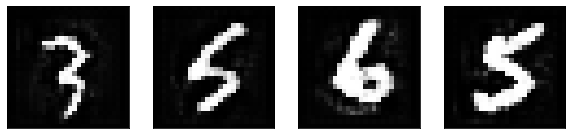

time taken in min: 2.084333352247874

epoch 11 epoch avg loss 0.007178557188234339
epoch 11 epoch avg cluster loss 0.00013723632730681734
epoch 11 epoch avg regen loss 0.007041320851925066



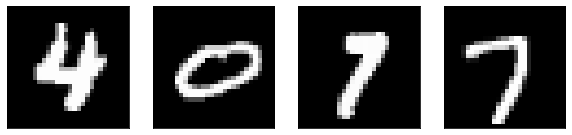

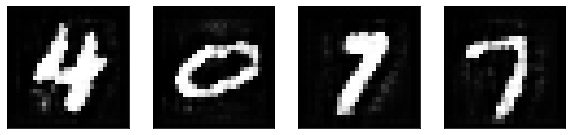

saving...

epoch 12
epoch 12 batch 0 batch total loss 0.007142499
epoch 12 batch 0 batch cluster loss 0.00013286118
epoch 12 batch 0 batch regen loss 0.007009638
saving...



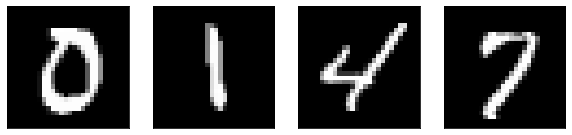

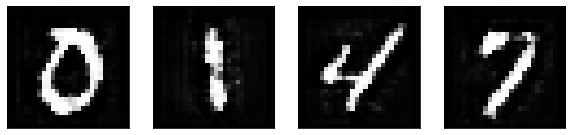

time taken in min: 0.7172083576520284
epoch 12 batch 50 batch total loss 0.0070500225
epoch 12 batch 50 batch cluster loss 0.00012758712
epoch 12 batch 50 batch regen loss 0.0069224355
saving...



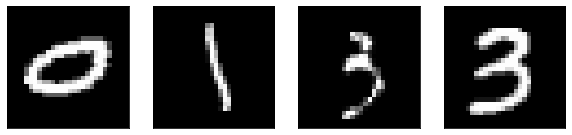

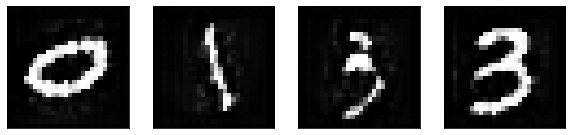

time taken in min: 2.0814048051834106
epoch 12 batch 100 batch total loss 0.0072604865
epoch 12 batch 100 batch cluster loss 0.00013073754
epoch 12 batch 100 batch regen loss 0.007129749
saving...



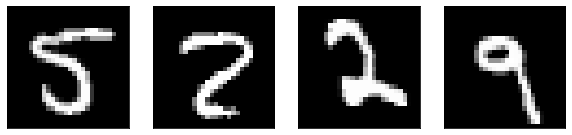

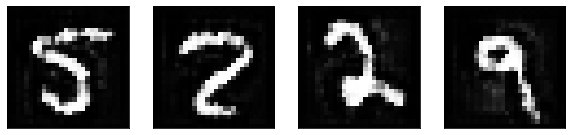

time taken in min: 2.095320121447245

epoch 12 epoch avg loss 0.007130071887809594
epoch 12 epoch avg cluster loss 0.00012671198943527256
epoch 12 epoch avg regen loss 0.007003359914899377



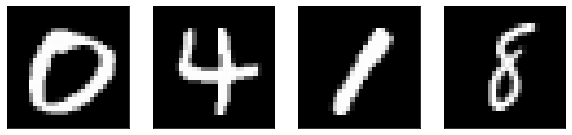

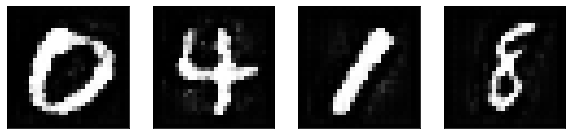

saving...

epoch 13
epoch 13 batch 0 batch total loss 0.0070793345
epoch 13 batch 0 batch cluster loss 0.0001317158
epoch 13 batch 0 batch regen loss 0.0069476184
saving...



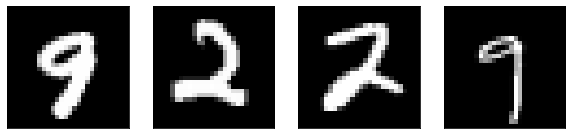

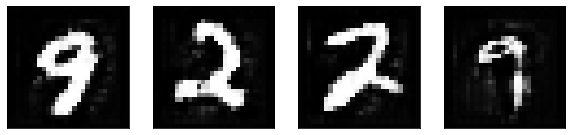

time taken in min: 0.7205077966054281
epoch 13 batch 50 batch total loss 0.0070847715
epoch 13 batch 50 batch cluster loss 0.0001235246
epoch 13 batch 50 batch regen loss 0.006961247
saving...



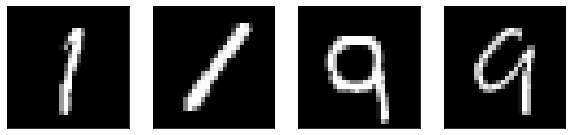

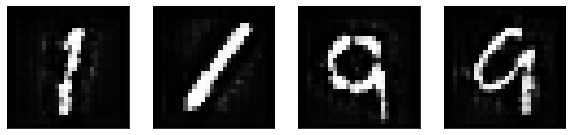

time taken in min: 2.0899415016174316
epoch 13 batch 100 batch total loss 0.007467595
epoch 13 batch 100 batch cluster loss 0.00012380943
epoch 13 batch 100 batch regen loss 0.0073437854
saving...



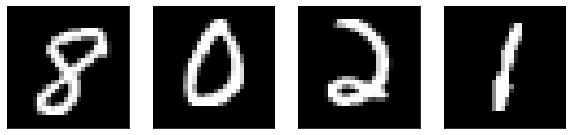

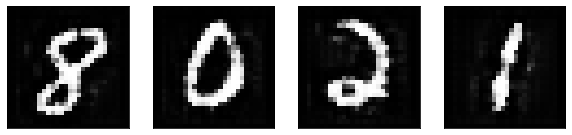

time taken in min: 2.094112718105316

epoch 13 epoch avg loss 0.007087850063186833
epoch 13 epoch avg cluster loss 0.00011939093044128316
epoch 13 epoch avg regen loss 0.0069684590986472065



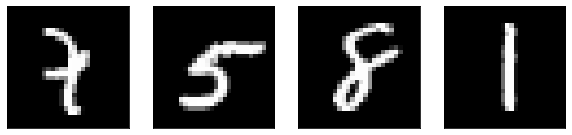

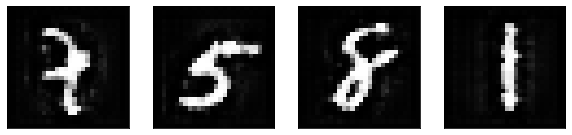

saving...

epoch 14
epoch 14 batch 0 batch total loss 0.0071358467
epoch 14 batch 0 batch cluster loss 0.00011649689
epoch 14 batch 0 batch regen loss 0.00701935
saving...



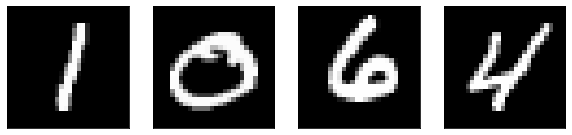

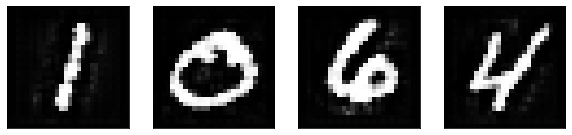

time taken in min: 0.7192290385564168
epoch 14 batch 50 batch total loss 0.0072376844
epoch 14 batch 50 batch cluster loss 0.00010734469
epoch 14 batch 50 batch regen loss 0.0071303397
saving...



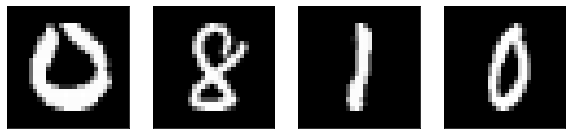

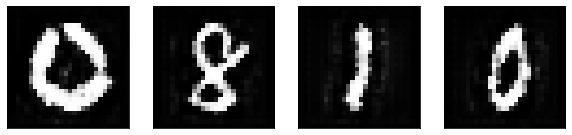

time taken in min: 2.0893934845924376
epoch 14 batch 100 batch total loss 0.006845766
epoch 14 batch 100 batch cluster loss 0.000108423934
epoch 14 batch 100 batch regen loss 0.006737342
saving...



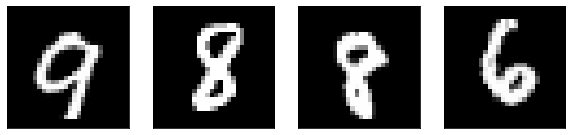

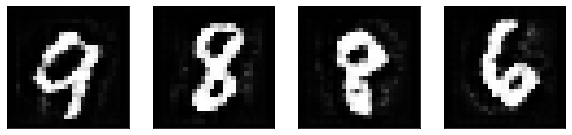

time taken in min: 2.0999269406000773

epoch 14 epoch avg loss 0.007052257783332114
epoch 14 epoch avg cluster loss 0.00011229107757710647
epoch 14 epoch avg regen loss 0.0069399667051384005



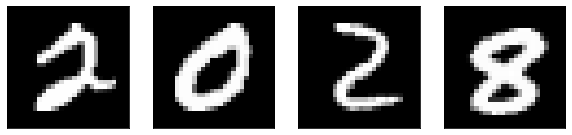

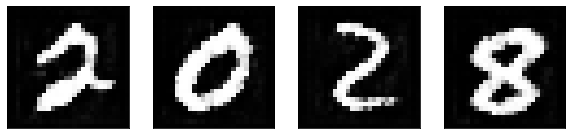

saving...

epoch 15
epoch 15 batch 0 batch total loss 0.0069573573
epoch 15 batch 0 batch cluster loss 0.00010808225
epoch 15 batch 0 batch regen loss 0.006849275
saving...



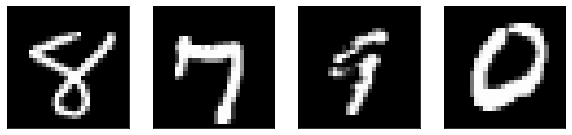

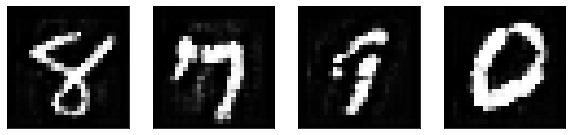

time taken in min: 0.7208675503730774
epoch 15 batch 50 batch total loss 0.0069394265
epoch 15 batch 50 batch cluster loss 0.00010496688
epoch 15 batch 50 batch regen loss 0.0068344595
saving...



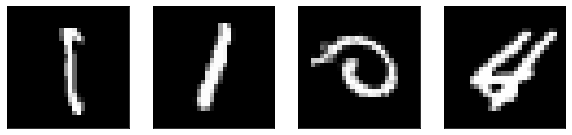

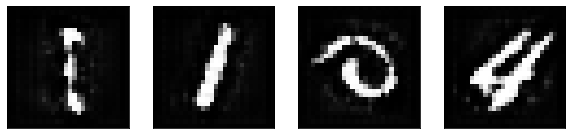

time taken in min: 2.0952079772949217
epoch 15 batch 100 batch total loss 0.00708971
epoch 15 batch 100 batch cluster loss 0.00010378094
epoch 15 batch 100 batch regen loss 0.006985929
saving...



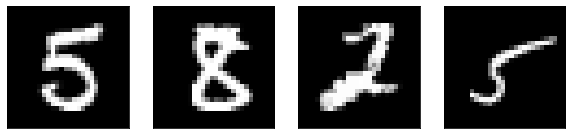

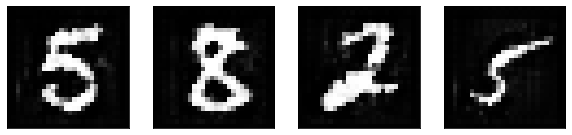

time taken in min: 2.095017592112223

epoch 15 epoch avg loss 0.007010672308536151
epoch 15 epoch avg cluster loss 0.00010568399196372257
epoch 15 epoch avg regen loss 0.0069049883089265076



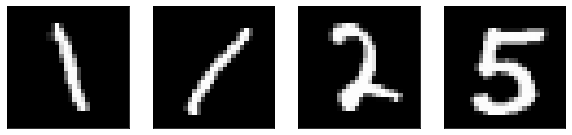

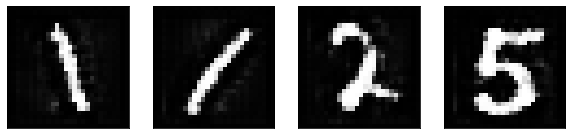

saving...

epoch 16
epoch 16 batch 0 batch total loss 0.007117151
epoch 16 batch 0 batch cluster loss 0.00010010375
epoch 16 batch 0 batch regen loss 0.007017047
saving...



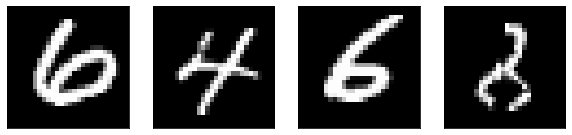

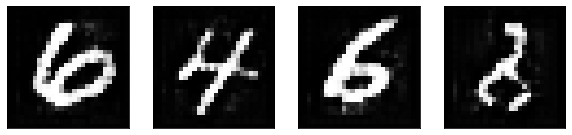

time taken in min: 0.7197951952616374
epoch 16 batch 50 batch total loss 0.0069270143
epoch 16 batch 50 batch cluster loss 9.77017e-05
epoch 16 batch 50 batch regen loss 0.0068293125
saving...



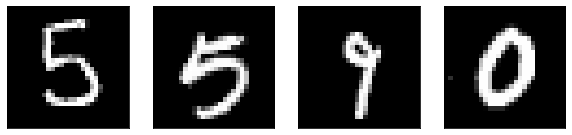

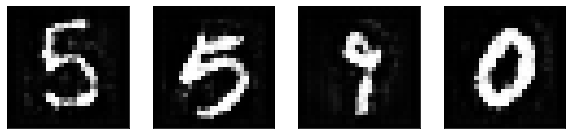

time taken in min: 2.09282621939977
epoch 16 batch 100 batch total loss 0.0071754474
epoch 16 batch 100 batch cluster loss 0.00010087272
epoch 16 batch 100 batch regen loss 0.0070745745
saving...



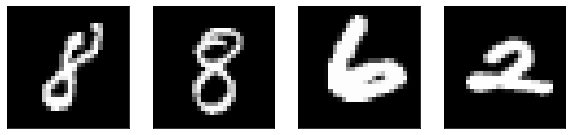

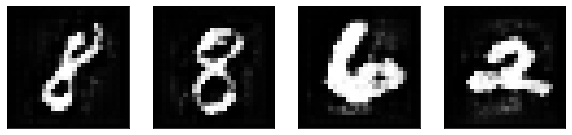

time taken in min: 2.0865023771921796

epoch 16 epoch avg loss 0.006978748792435153
epoch 16 epoch avg cluster loss 9.960651202117472e-05
epoch 16 epoch avg regen loss 0.0068791422842986



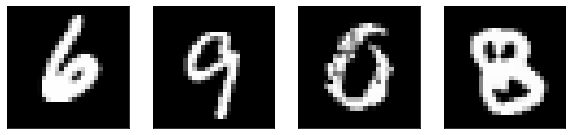

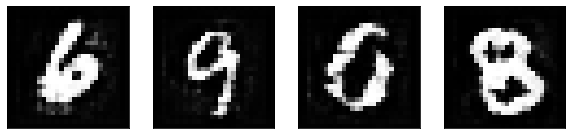

saving...

epoch 17
epoch 17 batch 0 batch total loss 0.0070282947
epoch 17 batch 0 batch cluster loss 9.727466e-05
epoch 17 batch 0 batch regen loss 0.00693102
saving...



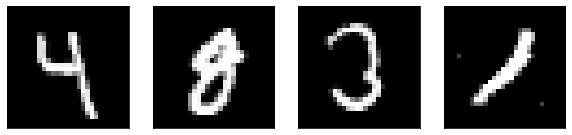

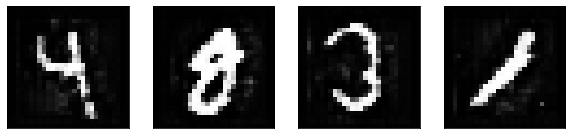

time taken in min: 0.7200931072235107
epoch 17 batch 50 batch total loss 0.00684461
epoch 17 batch 50 batch cluster loss 9.849068e-05
epoch 17 batch 50 batch regen loss 0.0067461194
saving...



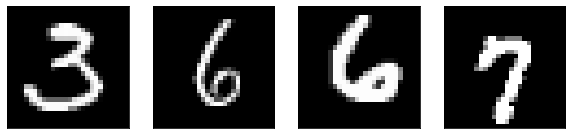

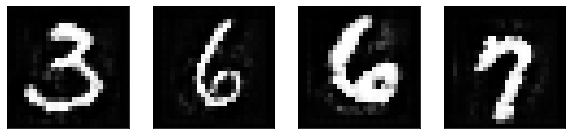

time taken in min: 2.080844696362813
epoch 17 batch 100 batch total loss 0.0069570527
epoch 17 batch 100 batch cluster loss 9.796857e-05
epoch 17 batch 100 batch regen loss 0.006859084
saving...



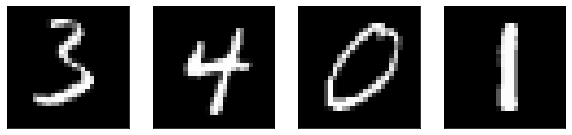

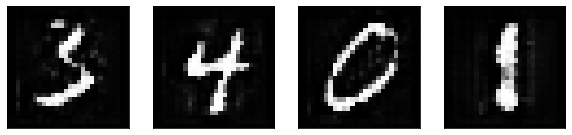

time taken in min: 2.0839752554893494

epoch 17 epoch avg loss 0.006941659600963279
epoch 17 epoch avg cluster loss 9.440049232857823e-05
epoch 17 epoch avg regen loss 0.006847259111039467



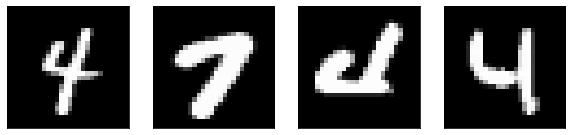

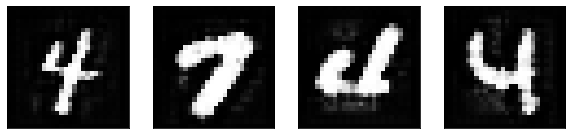

saving...

epoch 18
epoch 18 batch 0 batch total loss 0.006990612
epoch 18 batch 0 batch cluster loss 9.453869e-05
epoch 18 batch 0 batch regen loss 0.0068960735
saving...



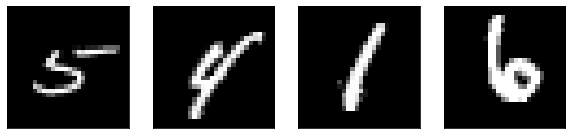

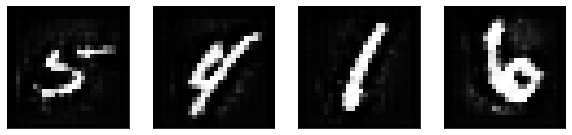

time taken in min: 0.7211390097935995
epoch 18 batch 50 batch total loss 0.006871603
epoch 18 batch 50 batch cluster loss 8.6303575e-05
epoch 18 batch 50 batch regen loss 0.006785299
saving...



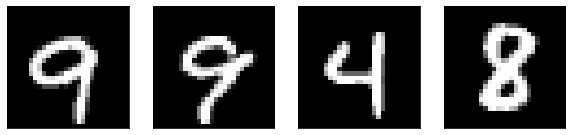

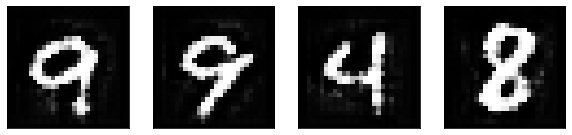

time taken in min: 2.0855840841929116
epoch 18 batch 100 batch total loss 0.00690331
epoch 18 batch 100 batch cluster loss 8.800104e-05
epoch 18 batch 100 batch regen loss 0.0068153087
saving...



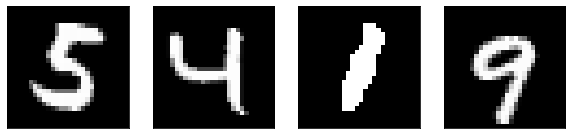

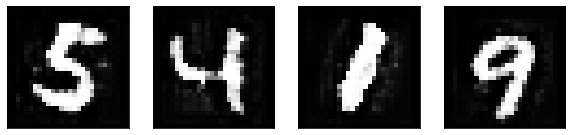

time taken in min: 2.0916105111440024

epoch 18 epoch avg loss 0.00690952414188976
epoch 18 epoch avg cluster loss 9.010432022169896e-05
epoch 18 epoch avg regen loss 0.006819419819324956



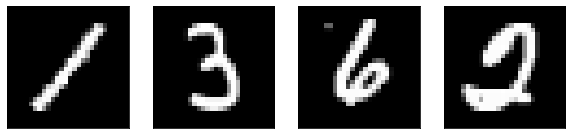

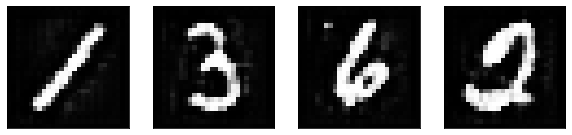

saving...

epoch 19
epoch 19 batch 0 batch total loss 0.0068643373
epoch 19 batch 0 batch cluster loss 8.71482e-05
epoch 19 batch 0 batch regen loss 0.006777189
saving...



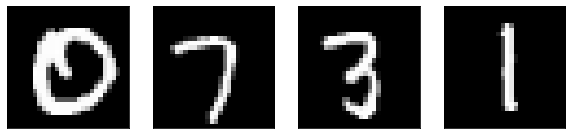

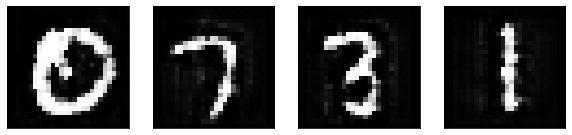

time taken in min: 0.7174169580141704
epoch 19 batch 50 batch total loss 0.0068996483
epoch 19 batch 50 batch cluster loss 8.461306e-05
epoch 19 batch 50 batch regen loss 0.0068150354
saving...



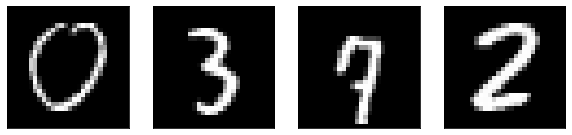

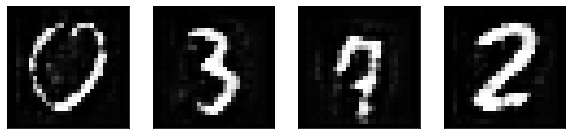

time taken in min: 2.0901749690373737
epoch 19 batch 100 batch total loss 0.00683644
epoch 19 batch 100 batch cluster loss 7.9467136e-05
epoch 19 batch 100 batch regen loss 0.006756973
saving...



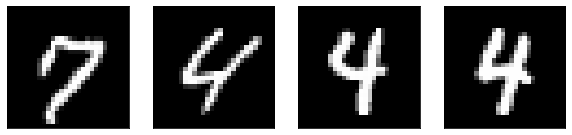

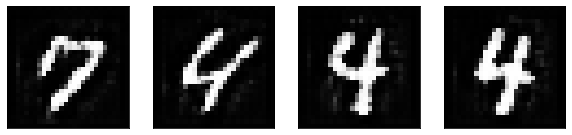

time taken in min: 2.0898543993631997

epoch 19 epoch avg loss 0.006878084747783713
epoch 19 epoch avg cluster loss 8.616777138401739e-05
epoch 19 epoch avg regen loss 0.006791916983675653



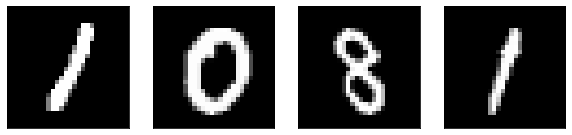

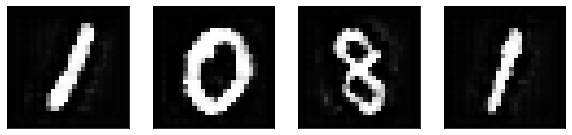

saving...

epoch 20
epoch 20 batch 0 batch total loss 0.006932888
epoch 20 batch 0 batch cluster loss 8.519409e-05
epoch 20 batch 0 batch regen loss 0.006847694
saving...



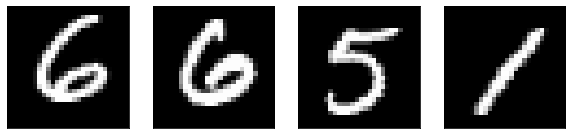

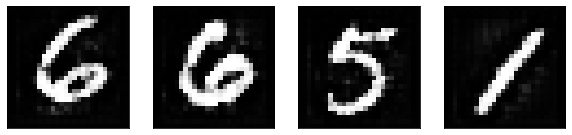

time taken in min: 0.718380347887675
epoch 20 batch 50 batch total loss 0.0068835868
epoch 20 batch 50 batch cluster loss 7.9412435e-05
epoch 20 batch 50 batch regen loss 0.0068041743
saving...



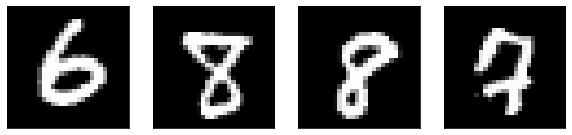

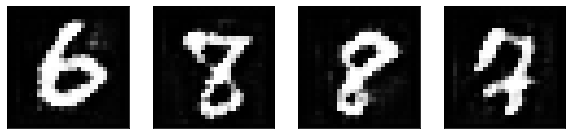

time taken in min: 2.0837270816167197
epoch 20 batch 100 batch total loss 0.0068006422
epoch 20 batch 100 batch cluster loss 8.099664e-05
epoch 20 batch 100 batch regen loss 0.0067196456
saving...



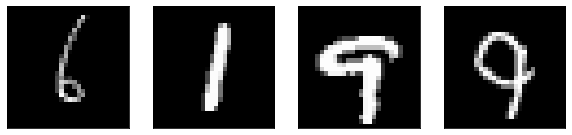

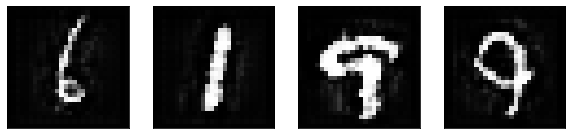

time taken in min: 2.0951849818229675

epoch 20 epoch avg loss 0.006848135521098719
epoch 20 epoch avg cluster loss 8.25314347235628e-05
epoch 20 epoch avg regen loss 0.006765604066520424



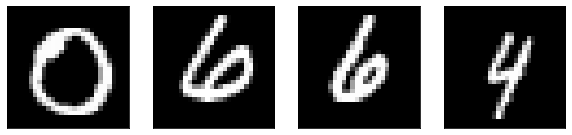

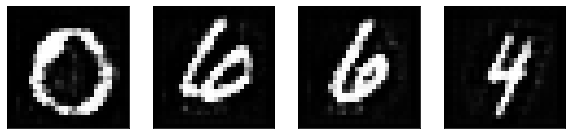

saving...

epoch 21
epoch 21 batch 0 batch total loss 0.0069841864
epoch 21 batch 0 batch cluster loss 8.456756e-05
epoch 21 batch 0 batch regen loss 0.006899619
saving...



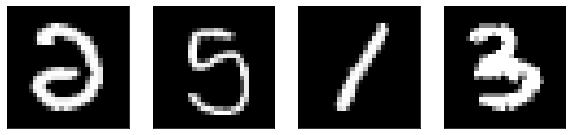

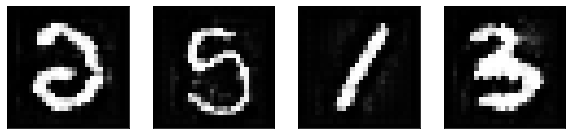

time taken in min: 0.7223023255666097
epoch 21 batch 50 batch total loss 0.006844795
epoch 21 batch 50 batch cluster loss 7.8309895e-05
epoch 21 batch 50 batch regen loss 0.006766485
saving...



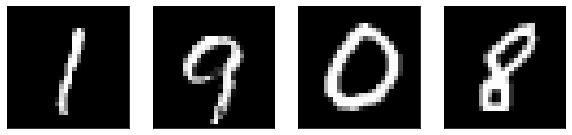

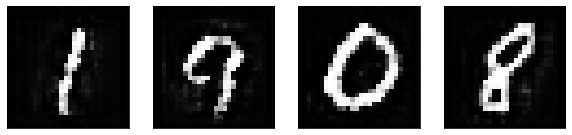

time taken in min: 2.089384889602661
epoch 21 batch 100 batch total loss 0.0067948867
epoch 21 batch 100 batch cluster loss 7.667791e-05
epoch 21 batch 100 batch regen loss 0.0067182085
saving...



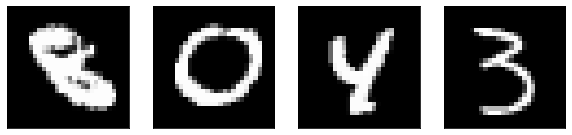

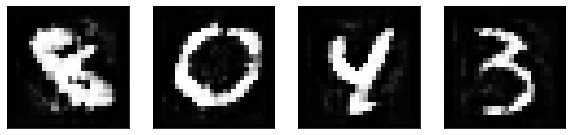

time taken in min: 2.0898409247398377

epoch 21 epoch avg loss 0.006820308198457805
epoch 21 epoch avg cluster loss 7.92276786326557e-05
epoch 21 epoch avg regen loss 0.006741080531787316



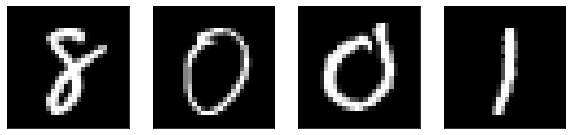

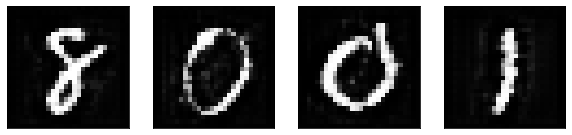

saving...

epoch 22
epoch 22 batch 0 batch total loss 0.0068005887
epoch 22 batch 0 batch cluster loss 8.0716214e-05
epoch 22 batch 0 batch regen loss 0.0067198724
saving...



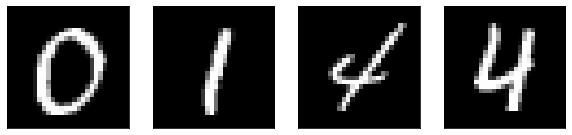

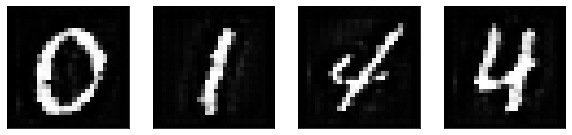

time taken in min: 0.7161325097084046
epoch 22 batch 50 batch total loss 0.0068055666
epoch 22 batch 50 batch cluster loss 7.5967735e-05
epoch 22 batch 50 batch regen loss 0.006729599
saving...



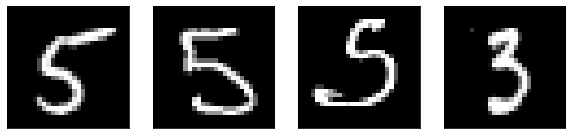

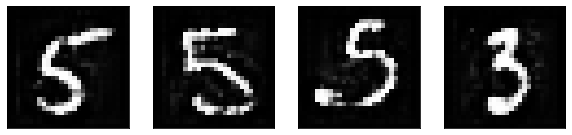

time taken in min: 2.089303982257843
epoch 22 batch 100 batch total loss 0.0068143755
epoch 22 batch 100 batch cluster loss 6.843104e-05
epoch 22 batch 100 batch regen loss 0.0067459443
saving...



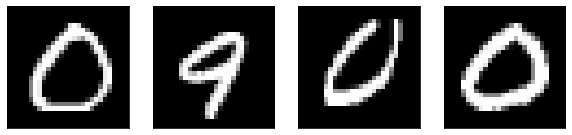

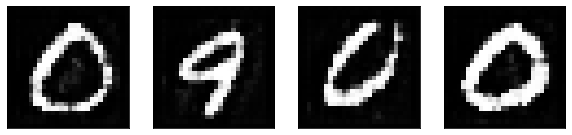

time taken in min: 2.086692460378011

epoch 22 epoch avg loss 0.006793773050372631
epoch 22 epoch avg cluster loss 7.594393185681221e-05
epoch 22 epoch avg regen loss 0.006717829116604338



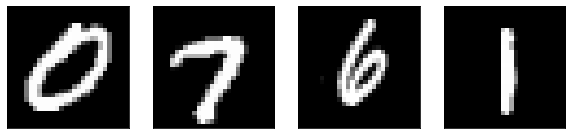

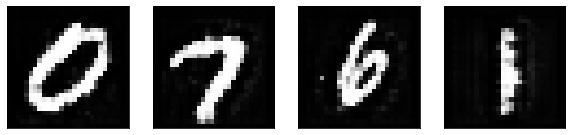

saving...

epoch 23
epoch 23 batch 0 batch total loss 0.006725043
epoch 23 batch 0 batch cluster loss 6.9532725e-05
epoch 23 batch 0 batch regen loss 0.0066555105
saving...



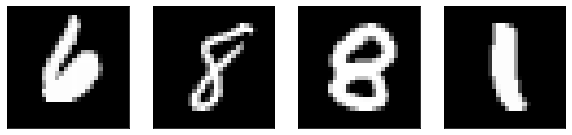

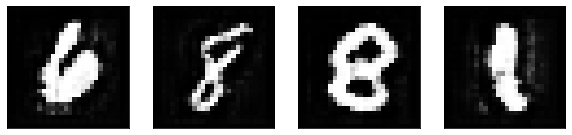

time taken in min: 0.7216455658276876
epoch 23 batch 50 batch total loss 0.006813692
epoch 23 batch 50 batch cluster loss 7.6819124e-05
epoch 23 batch 50 batch regen loss 0.0067368727
saving...



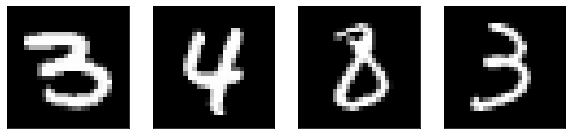

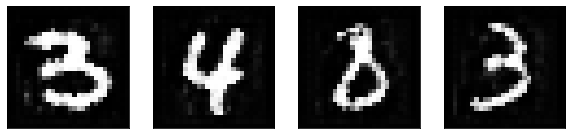

time taken in min: 2.091547417640686
epoch 23 batch 100 batch total loss 0.006878232
epoch 23 batch 100 batch cluster loss 7.682247e-05
epoch 23 batch 100 batch regen loss 0.0068014096
saving...



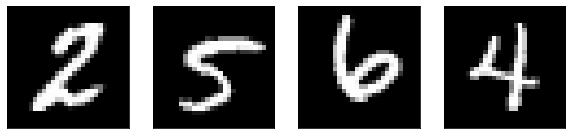

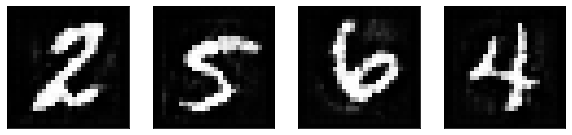

time taken in min: 2.089156456788381

epoch 23 epoch avg loss 0.0067650823285645345
epoch 23 epoch avg cluster loss 7.272886068676598e-05
epoch 23 epoch avg regen loss 0.006692353454497406



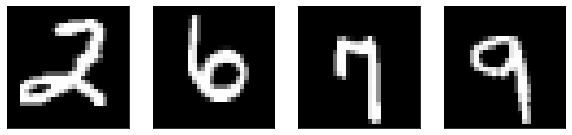

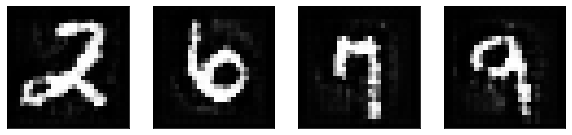

saving...

epoch 24
epoch 24 batch 0 batch total loss 0.006995243
epoch 24 batch 0 batch cluster loss 7.496624e-05
epoch 24 batch 0 batch regen loss 0.0069202767
saving...



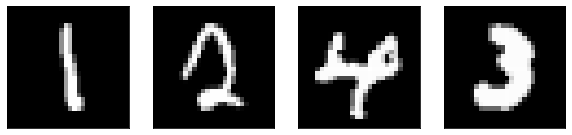

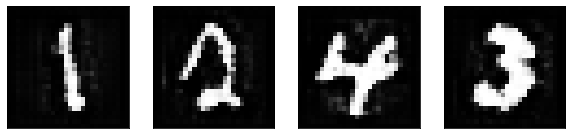

time taken in min: 0.7217765927314759
epoch 24 batch 50 batch total loss 0.0067242156
epoch 24 batch 50 batch cluster loss 7.304824e-05
epoch 24 batch 50 batch regen loss 0.0066511673
saving...



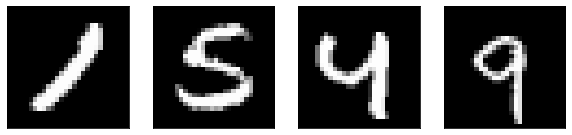

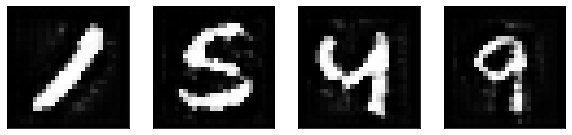

time taken in min: 2.0879283865292866
epoch 24 batch 100 batch total loss 0.0066997358
epoch 24 batch 100 batch cluster loss 6.870826e-05
epoch 24 batch 100 batch regen loss 0.0066310274
saving...



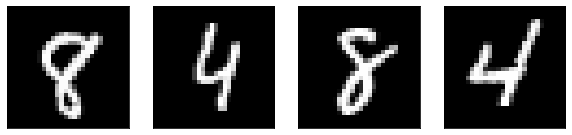

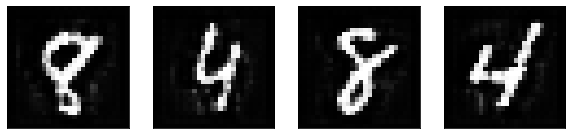

time taken in min: 2.078395140171051

epoch 24 epoch avg loss 0.006738857287219015
epoch 24 epoch avg cluster loss 7.009093475309043e-05
epoch 24 epoch avg regen loss 0.006668766340935382



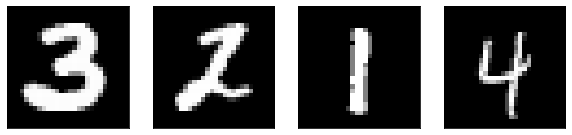

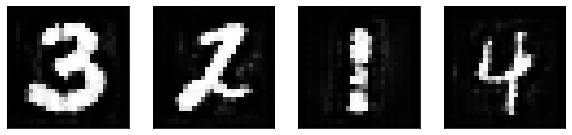

saving...

epoch 25
epoch 25 batch 0 batch total loss 0.006676421
epoch 25 batch 0 batch cluster loss 6.75367e-05
epoch 25 batch 0 batch regen loss 0.0066088843
saving...



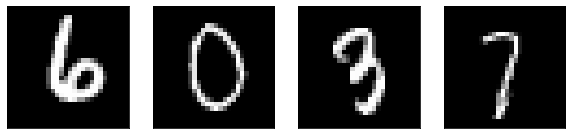

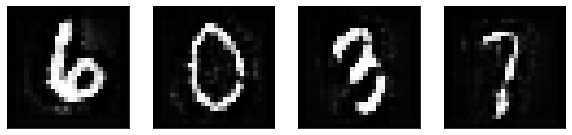

time taken in min: 0.7184277375539144
epoch 25 batch 50 batch total loss 0.006770861
epoch 25 batch 50 batch cluster loss 6.841675e-05
epoch 25 batch 50 batch regen loss 0.006702444
saving...



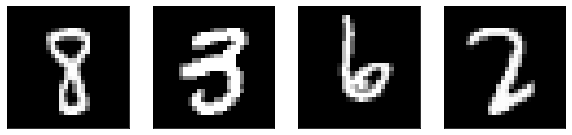

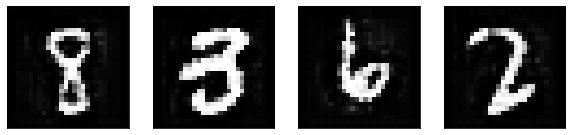

time taken in min: 2.073883891105652
epoch 25 batch 100 batch total loss 0.0065937745
epoch 25 batch 100 batch cluster loss 6.978155e-05
epoch 25 batch 100 batch regen loss 0.006523993
saving...



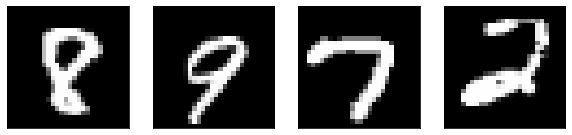

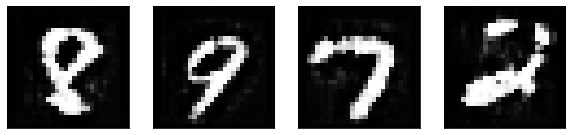

time taken in min: 2.089673944314321

epoch 25 epoch avg loss 0.0067117360254781225
epoch 25 epoch avg cluster loss 6.772653534303033e-05
epoch 25 epoch avg regen loss 0.006644009482273359



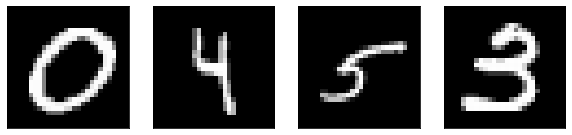

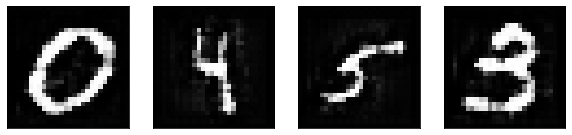

saving...

epoch 26
epoch 26 batch 0 batch total loss 0.006766297
epoch 26 batch 0 batch cluster loss 6.5294014e-05
epoch 26 batch 0 batch regen loss 0.006701003
saving...



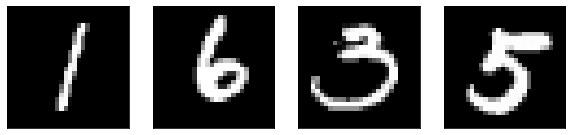

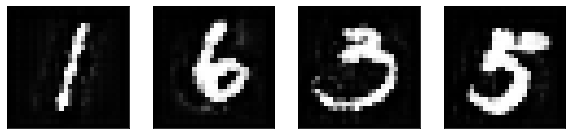

time taken in min: 0.7242114265759786
epoch 26 batch 50 batch total loss 0.006703564
epoch 26 batch 50 batch cluster loss 6.489328e-05
epoch 26 batch 50 batch regen loss 0.006638671
saving...



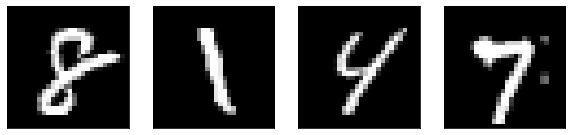

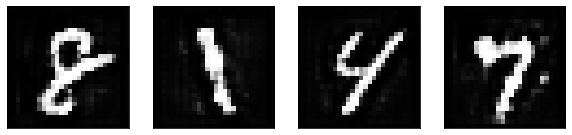

time taken in min: 2.087833046913147
epoch 26 batch 100 batch total loss 0.006820101
epoch 26 batch 100 batch cluster loss 6.4819185e-05
epoch 26 batch 100 batch regen loss 0.0067552817
saving...



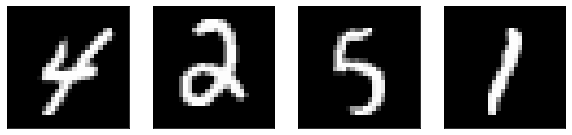

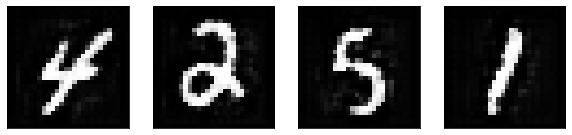

time taken in min: 2.090125262737274

epoch 26 epoch avg loss 0.006687539104782677
epoch 26 epoch avg cluster loss 6.555536005550293e-05
epoch 26 epoch avg regen loss 0.0066219837546853694



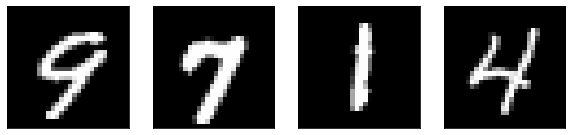

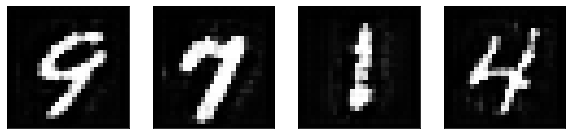

saving...

epoch 27
epoch 27 batch 0 batch total loss 0.0067748707
epoch 27 batch 0 batch cluster loss 6.5584994e-05
epoch 27 batch 0 batch regen loss 0.0067092855
saving...



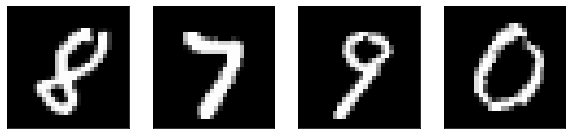

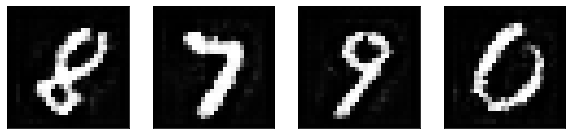

time taken in min: 0.7209642887115478
epoch 27 batch 50 batch total loss 0.0065688696
epoch 27 batch 50 batch cluster loss 5.7064808e-05
epoch 27 batch 50 batch regen loss 0.0065118046
saving...



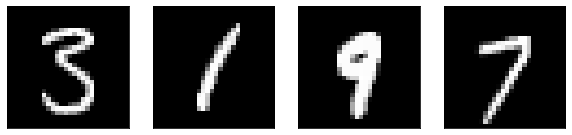

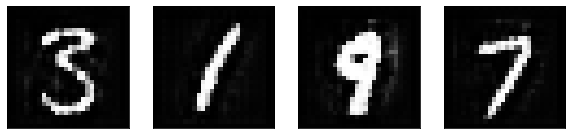

time taken in min: 2.0823622226715086
epoch 27 batch 100 batch total loss 0.0065665115
epoch 27 batch 100 batch cluster loss 6.212868e-05
epoch 27 batch 100 batch regen loss 0.006504383
saving...



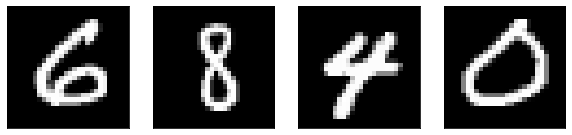

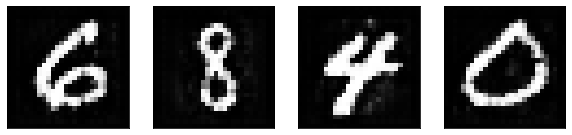

time taken in min: 2.083431080977122

epoch 27 epoch avg loss 0.006663327488132705
epoch 27 epoch avg cluster loss 6.316013093317574e-05
epoch 27 epoch avg regen loss 0.006600167361577436



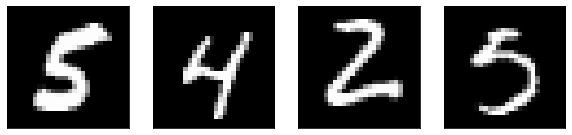

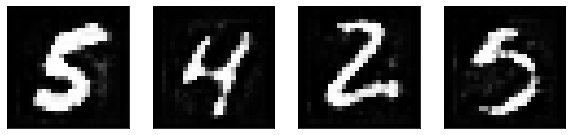

saving...

epoch 28
epoch 28 batch 0 batch total loss 0.006702964
epoch 28 batch 0 batch cluster loss 6.165721e-05
epoch 28 batch 0 batch regen loss 0.006641307
saving...



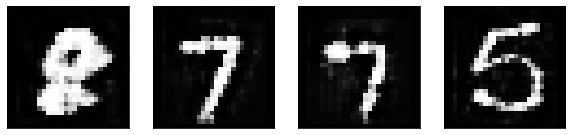

time taken in min: 0.7183082063992818
epoch 28 batch 50 batch total loss 0.0067662266
epoch 28 batch 50 batch cluster loss 5.914165e-05
epoch 28 batch 50 batch regen loss 0.006707085
saving...



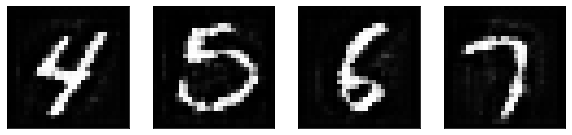

time taken in min: 2.095423372586568
epoch 28 batch 100 batch total loss 0.0068161557
epoch 28 batch 100 batch cluster loss 6.31528e-05
epoch 28 batch 100 batch regen loss 0.0067530028
saving...



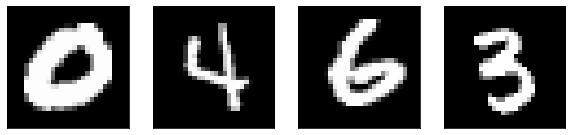

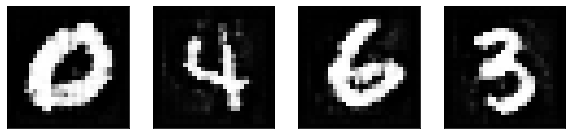

time taken in min: 2.086992927392324

epoch 28 epoch avg loss 0.006637643789872527
epoch 28 epoch avg cluster loss 6.109330437754841e-05
epoch 28 epoch avg regen loss 0.006576550489102127



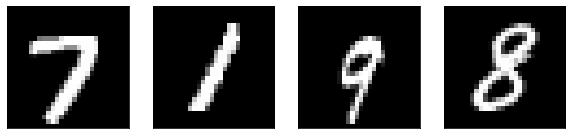

saving...

epoch 29
epoch 29 batch 0 batch total loss 0.0064051896
epoch 29 batch 0 batch cluster loss 5.8057092e-05
epoch 29 batch 0 batch regen loss 0.0063471324
saving...



time taken in min: 0.7179013768831889
epoch 29 batch 50 batch total loss 0.006614416
epoch 29 batch 50 batch cluster loss 6.2157924e-05
epoch 29 batch 50 batch regen loss 0.006552258
saving...



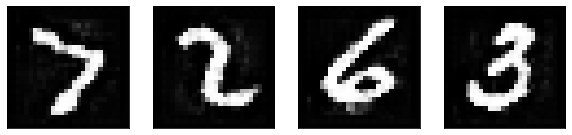

time taken in min: 2.0894062399864195
epoch 29 batch 100 batch total loss 0.006698288
epoch 29 batch 100 batch cluster loss 5.809016e-05
epoch 29 batch 100 batch regen loss 0.0066401977
saving...



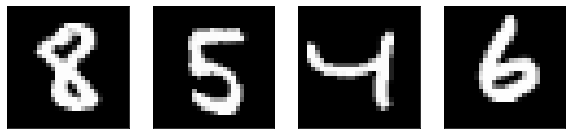

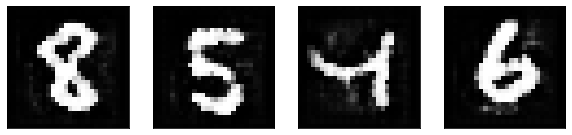

time taken in min: 2.088966659704844

epoch 29 epoch avg loss 0.0066162125420583
epoch 29 epoch avg cluster loss 5.9388879304544576e-05
epoch 29 epoch avg regen loss 0.006556823648417653



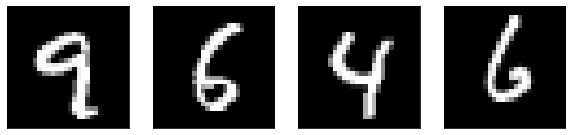

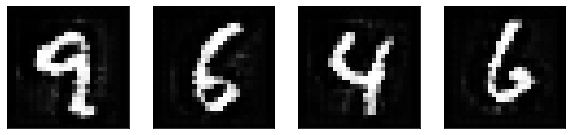

saving...

epoch 30
epoch 30 batch 0 batch total loss 0.0064789886
epoch 30 batch 0 batch cluster loss 5.5908236e-05
epoch 30 batch 0 batch regen loss 0.0064230803
saving...



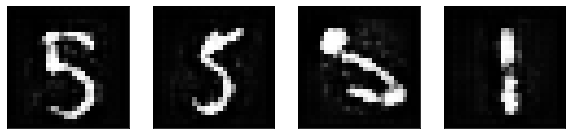

time taken in min: 0.7177909731864929
epoch 30 batch 50 batch total loss 0.0065032956
epoch 30 batch 50 batch cluster loss 5.6295317e-05
epoch 30 batch 50 batch regen loss 0.0064470004
saving...



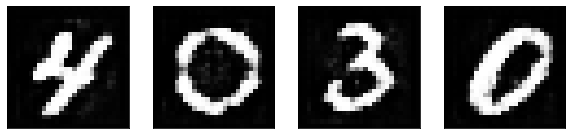

time taken in min: 2.0918463985125224
epoch 30 batch 100 batch total loss 0.00629127
epoch 30 batch 100 batch cluster loss 5.527617e-05
epoch 30 batch 100 batch regen loss 0.0062359935
saving...



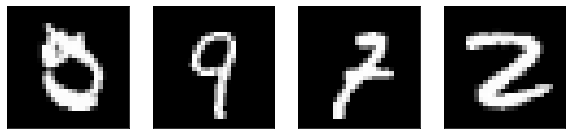

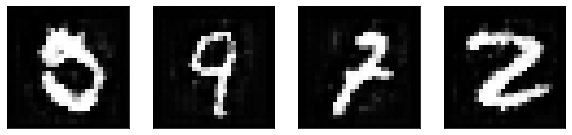

time taken in min: 2.0922659118970235

epoch 30 epoch avg loss 0.0065948218265074795
epoch 30 epoch avg cluster loss 5.734891573858045e-05
epoch 30 epoch avg regen loss 0.006537472927879731



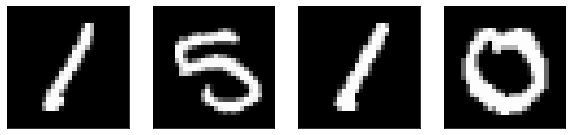

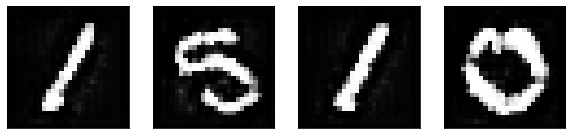

saving...

epoch 31
epoch 31 batch 0 batch total loss 0.0065927086
epoch 31 batch 0 batch cluster loss 5.6068136e-05
epoch 31 batch 0 batch regen loss 0.0065366407
saving...



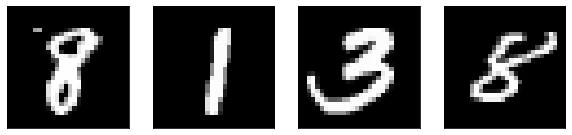

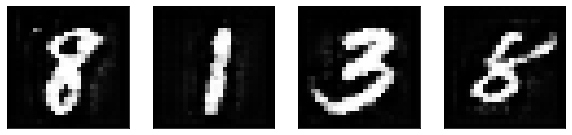

time taken in min: 0.7172300179799398
epoch 31 batch 50 batch total loss 0.006777346
epoch 31 batch 50 batch cluster loss 5.776803e-05
epoch 31 batch 50 batch regen loss 0.006719578
saving...



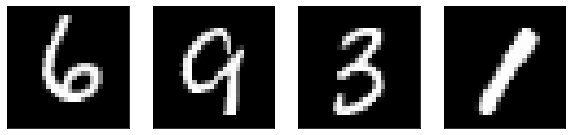

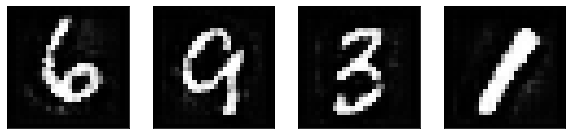

time taken in min: 2.0919833183288574
epoch 31 batch 100 batch total loss 0.006617866
epoch 31 batch 100 batch cluster loss 5.648316e-05
epoch 31 batch 100 batch regen loss 0.0065613827
saving...



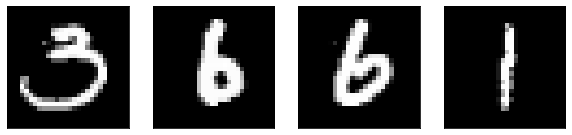

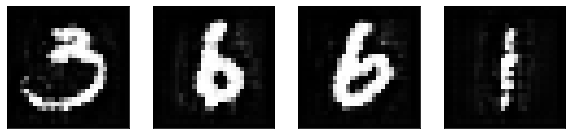

time taken in min: 2.086490881443024

epoch 31 epoch avg loss 0.006574251708748229
epoch 31 epoch avg cluster loss 5.6035280067590065e-05
epoch 31 epoch avg regen loss 0.0065182164248268485



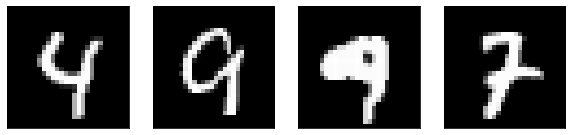

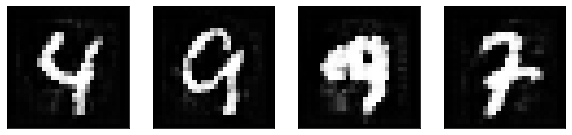

saving...

epoch 32
epoch 32 batch 0 batch total loss 0.0065193684
epoch 32 batch 0 batch cluster loss 5.3655294e-05
epoch 32 batch 0 batch regen loss 0.006465713
saving...



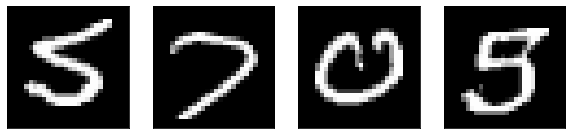

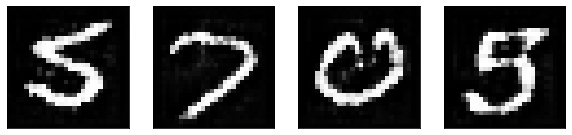

time taken in min: 0.7198859254519144
epoch 32 batch 50 batch total loss 0.0064756046
epoch 32 batch 50 batch cluster loss 5.4180844e-05
epoch 32 batch 50 batch regen loss 0.006421424
saving...



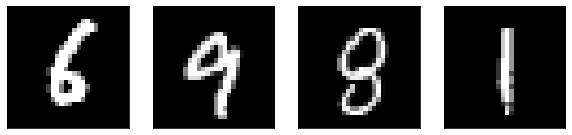

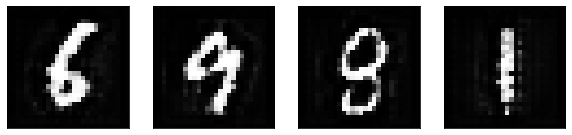

time taken in min: 2.0859025677045184
epoch 32 batch 100 batch total loss 0.0065121604
epoch 32 batch 100 batch cluster loss 5.4487522e-05
epoch 32 batch 100 batch regen loss 0.006457673
saving...



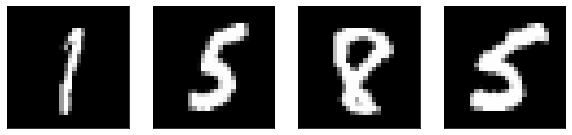

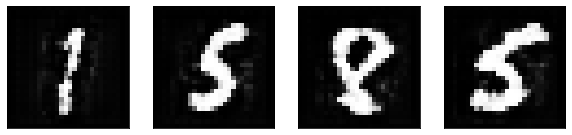

time taken in min: 2.0848424951235454

epoch 32 epoch avg loss 0.0065519292681020195
epoch 32 epoch avg cluster loss 5.4054209829053554e-05
epoch 32 epoch avg regen loss 0.0064978750730406935



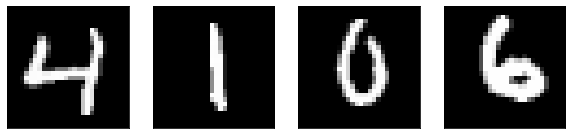

saving...

epoch 33
epoch 33 batch 0 batch total loss 0.0064404206
epoch 33 batch 0 batch cluster loss 5.0629802e-05
epoch 33 batch 0 batch regen loss 0.0063897907
saving...



time taken in min: 0.7149523417154948
epoch 33 batch 50 batch total loss 0.006687361
epoch 33 batch 50 batch cluster loss 5.1788465e-05
epoch 33 batch 50 batch regen loss 0.0066355723
saving...



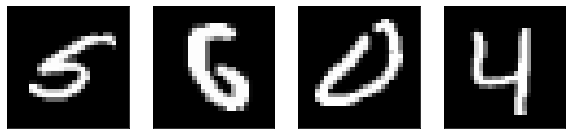

time taken in min: 2.089942534764608
epoch 33 batch 100 batch total loss 0.0066023055
epoch 33 batch 100 batch cluster loss 5.1221774e-05
epoch 33 batch 100 batch regen loss 0.0065510836
saving...



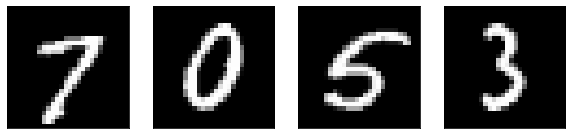

time taken in min: 2.0969810128211974

epoch 33 epoch avg loss 0.006529513600487578
epoch 33 epoch avg cluster loss 5.261828701512028e-05
epoch 33 epoch avg regen loss 0.006476895303575922



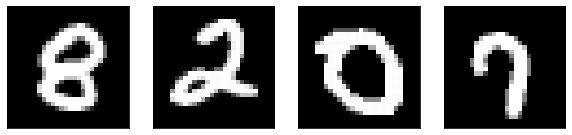

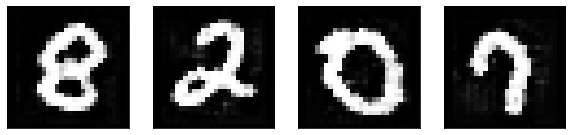

saving...

epoch 34
epoch 34 batch 0 batch total loss 0.0065377043
epoch 34 batch 0 batch cluster loss 4.9559276e-05
epoch 34 batch 0 batch regen loss 0.006488145
saving...



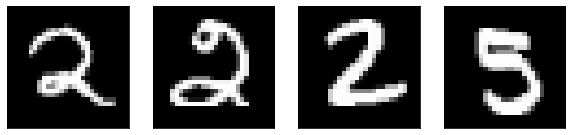

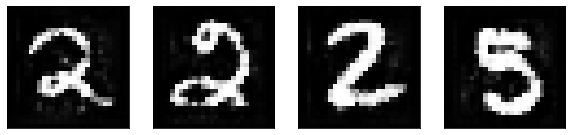

time taken in min: 0.7197965780893961
epoch 34 batch 50 batch total loss 0.006603834
epoch 34 batch 50 batch cluster loss 5.330139e-05
epoch 34 batch 50 batch regen loss 0.0065505328
saving...



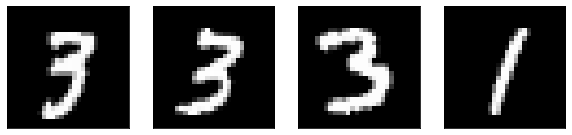

time taken in min: 2.1006135026613872
epoch 34 batch 100 batch total loss 0.0062382133
epoch 34 batch 100 batch cluster loss 5.0081813e-05
epoch 34 batch 100 batch regen loss 0.0061881314
saving...



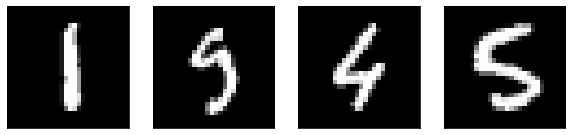

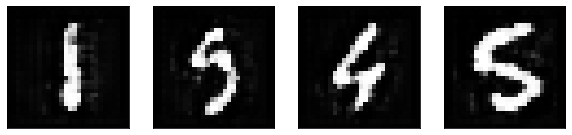

time taken in min: 2.080954178174337

epoch 34 epoch avg loss 0.006508307870856281
epoch 34 epoch avg cluster loss 5.1366867071118256e-05
epoch 34 epoch avg regen loss 0.006456940991298879



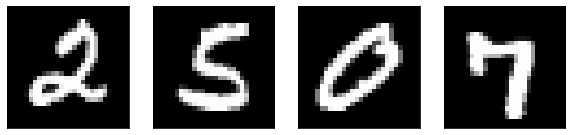

saving...

epoch 35
epoch 35 batch 0 batch total loss 0.006570144
epoch 35 batch 0 batch cluster loss 4.787574e-05
epoch 35 batch 0 batch regen loss 0.0065222685
saving...



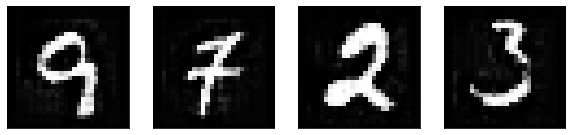

time taken in min: 0.7191699107487997
epoch 35 batch 50 batch total loss 0.006304874
epoch 35 batch 50 batch cluster loss 4.9191625e-05
epoch 35 batch 50 batch regen loss 0.0062556826
saving...



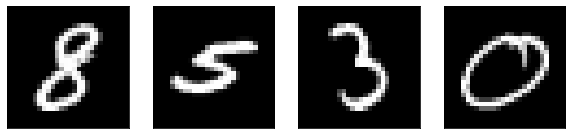

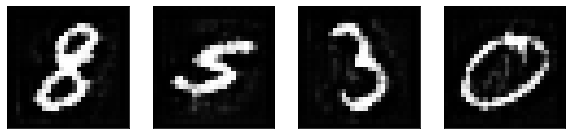

time taken in min: 2.0832119743029276
epoch 35 batch 100 batch total loss 0.0064352076
epoch 35 batch 100 batch cluster loss 4.973582e-05
epoch 35 batch 100 batch regen loss 0.0063854717
saving...



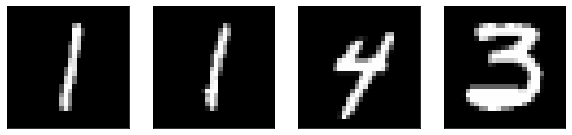

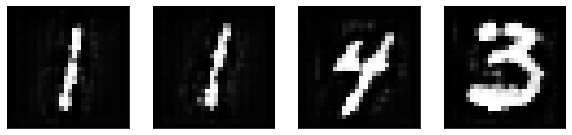

time taken in min: 2.087701912720998

epoch 35 epoch avg loss 0.006492234324499712
epoch 35 epoch avg cluster loss 4.9886700176333975e-05
epoch 35 epoch avg regen loss 0.006442347616430814



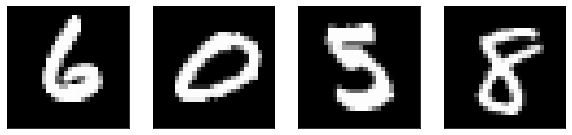

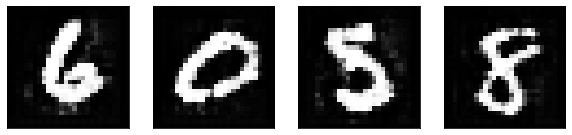

saving...

epoch 36
epoch 36 batch 0 batch total loss 0.006487864
epoch 36 batch 0 batch cluster loss 4.829155e-05
epoch 36 batch 0 batch regen loss 0.0064395727
saving...



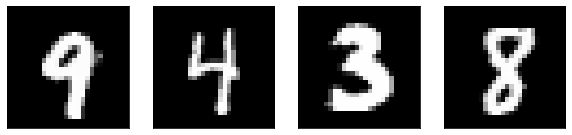

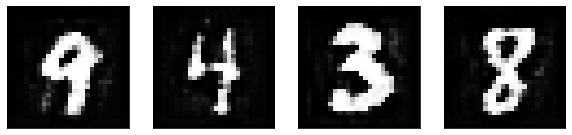

time taken in min: 0.7196648240089416
epoch 36 batch 50 batch total loss 0.006515403
epoch 36 batch 50 batch cluster loss 4.84284e-05
epoch 36 batch 50 batch regen loss 0.0064669745
saving...



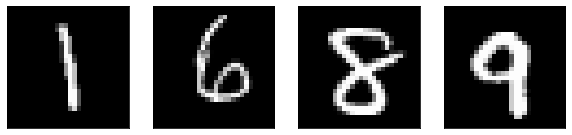

time taken in min: 2.083334171772003
epoch 36 batch 100 batch total loss 0.0064804615
epoch 36 batch 100 batch cluster loss 4.8692207e-05
epoch 36 batch 100 batch regen loss 0.006431769
saving...



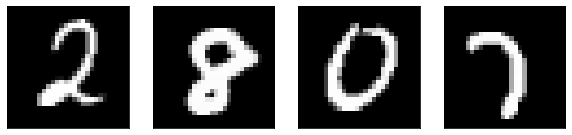

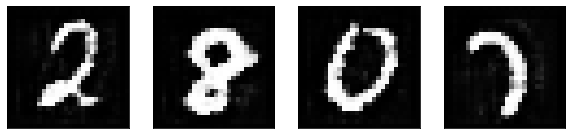

time taken in min: 2.0906712214152017

epoch 36 epoch avg loss 0.006469975415048963
epoch 36 epoch avg cluster loss 4.870545696684207e-05
epoch 36 epoch avg regen loss 0.006421269947599809



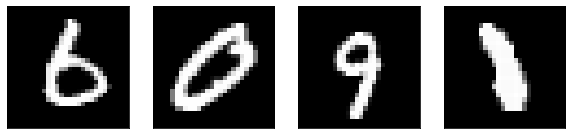

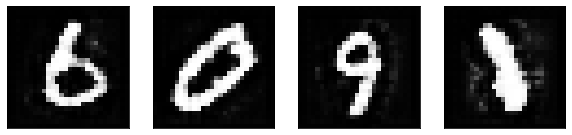

saving...

epoch 37
epoch 37 batch 0 batch total loss 0.0063655456
epoch 37 batch 0 batch cluster loss 4.7792535e-05
epoch 37 batch 0 batch regen loss 0.006317753
saving...



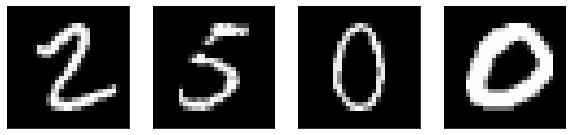

time taken in min: 0.7227669676144918
epoch 37 batch 50 batch total loss 0.006397298
epoch 37 batch 50 batch cluster loss 4.727121e-05
epoch 37 batch 50 batch regen loss 0.006350027
saving...



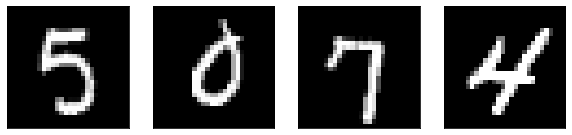

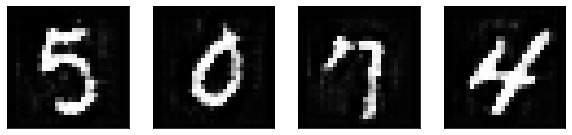

time taken in min: 2.080639052391052
epoch 37 batch 100 batch total loss 0.0064169965
epoch 37 batch 100 batch cluster loss 4.7441124e-05
epoch 37 batch 100 batch regen loss 0.0063695554
saving...



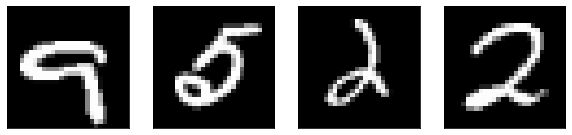

time taken in min: 2.092107065518697

epoch 37 epoch avg loss 0.006452095821120982
epoch 37 epoch avg cluster loss 4.787474571750894e-05
epoch 37 epoch avg regen loss 0.006404221077623256



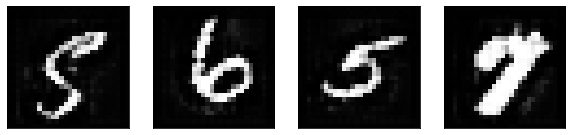

saving...

epoch 38
epoch 38 batch 0 batch total loss 0.006574771
epoch 38 batch 0 batch cluster loss 4.667555e-05
epoch 38 batch 0 batch regen loss 0.0065280953
saving...



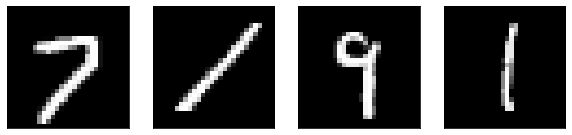

time taken in min: 0.7216235438982646
epoch 38 batch 50 batch total loss 0.0065709245
epoch 38 batch 50 batch cluster loss 4.7512425e-05
epoch 38 batch 50 batch regen loss 0.006523412
saving...



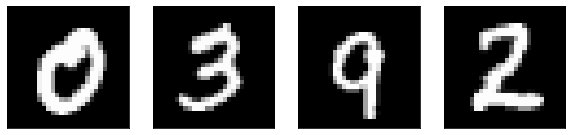

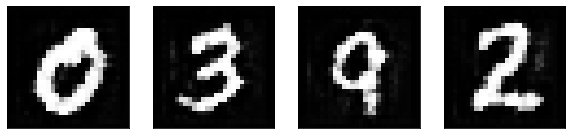

time taken in min: 2.095391543706258
epoch 38 batch 100 batch total loss 0.0065397243
epoch 38 batch 100 batch cluster loss 4.6182875e-05
epoch 38 batch 100 batch regen loss 0.0064935414
saving...



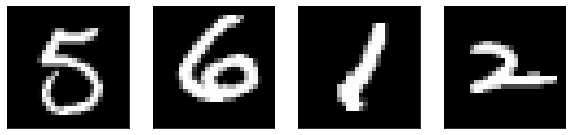

time taken in min: 2.0865323662757875

epoch 38 epoch avg loss 0.0064340609646702214
epoch 38 epoch avg cluster loss 4.645401988177505e-05
epoch 38 epoch avg regen loss 0.006387606953760072



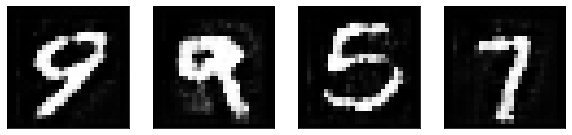

saving...

epoch 39
epoch 39 batch 0 batch total loss 0.006428143
epoch 39 batch 0 batch cluster loss 4.5979163e-05
epoch 39 batch 0 batch regen loss 0.0063821636
saving...



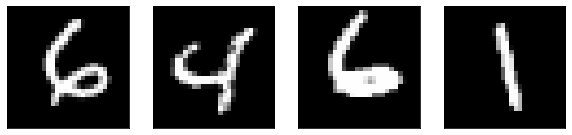

time taken in min: 0.7208407441775004
epoch 39 batch 50 batch total loss 0.006280074
epoch 39 batch 50 batch cluster loss 4.4288616e-05
epoch 39 batch 50 batch regen loss 0.0062357853
saving...



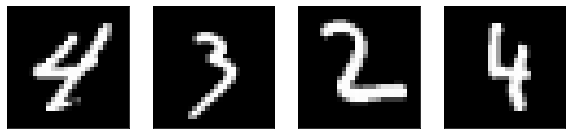

time taken in min: 2.087348973751068
epoch 39 batch 100 batch total loss 0.0065226387
epoch 39 batch 100 batch cluster loss 4.371685e-05
epoch 39 batch 100 batch regen loss 0.006478922
saving...



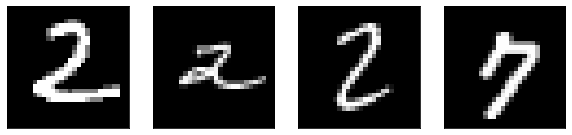

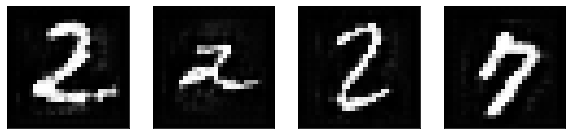

time taken in min: 2.0921074867248537

epoch 39 epoch avg loss 0.00641758588016412
epoch 39 epoch avg cluster loss 4.5460764510099285e-05
epoch 39 epoch avg regen loss 0.00637212510899467



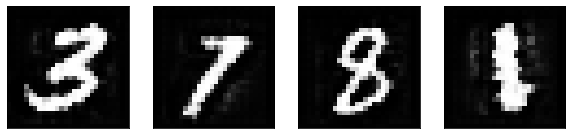

saving...

epoch 40
epoch 40 batch 0 batch total loss 0.0064209993
epoch 40 batch 0 batch cluster loss 4.5899244e-05
epoch 40 batch 0 batch regen loss 0.0063751
saving...



time taken in min: 0.7216447790463766
epoch 40 batch 50 batch total loss 0.0064468677
epoch 40 batch 50 batch cluster loss 4.200765e-05
epoch 40 batch 50 batch regen loss 0.00640486
saving...



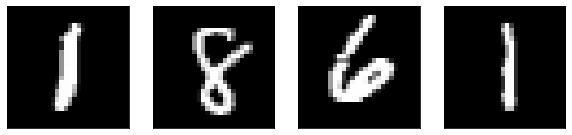

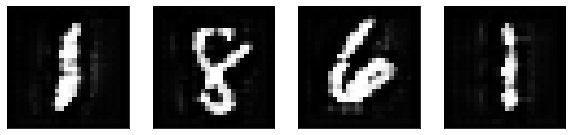

time taken in min: 2.0929076433181764
epoch 40 batch 100 batch total loss 0.0065187886
epoch 40 batch 100 batch cluster loss 4.6733745e-05
epoch 40 batch 100 batch regen loss 0.006472055
saving...



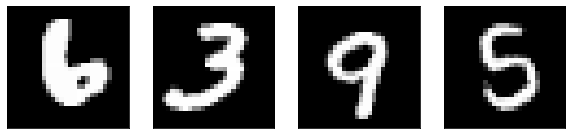

time taken in min: 2.0907100319862364

epoch 40 epoch avg loss 0.006396983241094119
epoch 40 epoch avg cluster loss 4.4304429924892956e-05
epoch 40 epoch avg regen loss 0.006352678793719259



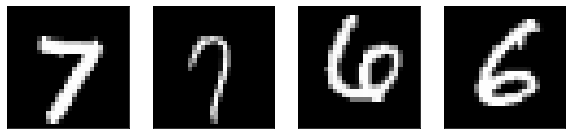

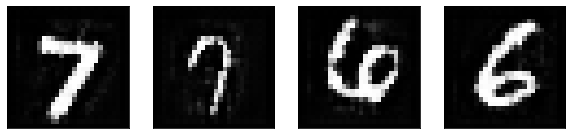

saving...

epoch 41
epoch 41 batch 0 batch total loss 0.0064943163
epoch 41 batch 0 batch cluster loss 4.5464578e-05
epoch 41 batch 0 batch regen loss 0.006448852
saving...



time taken in min: 0.7213656067848205
epoch 41 batch 50 batch total loss 0.0063620773
epoch 41 batch 50 batch cluster loss 4.4373886e-05
epoch 41 batch 50 batch regen loss 0.0063177035
saving...



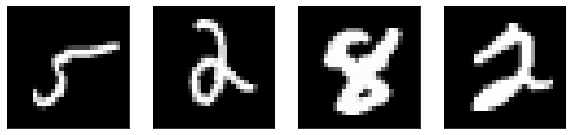

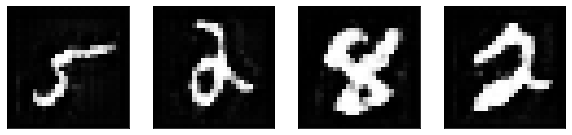

time taken in min: 2.088563358783722
epoch 41 batch 100 batch total loss 0.0065166224
epoch 41 batch 100 batch cluster loss 4.544969e-05
epoch 41 batch 100 batch regen loss 0.006471173
saving...



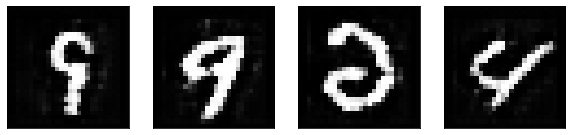

time taken in min: 2.0828734477361044

epoch 41 epoch avg loss 0.006381676354745435
epoch 41 epoch avg cluster loss 4.3423717030791676e-05
epoch 41 epoch avg regen loss 0.006338252642555005



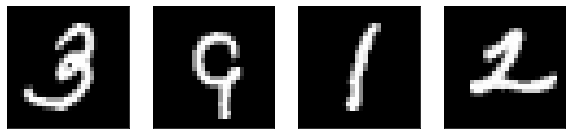

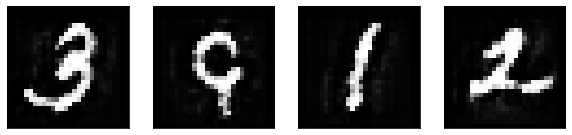

saving...

epoch 42
epoch 42 batch 0 batch total loss 0.0063296678
epoch 42 batch 0 batch cluster loss 4.1780077e-05
epoch 42 batch 0 batch regen loss 0.0062878877
saving...



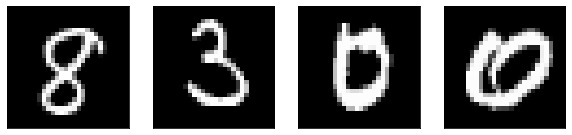

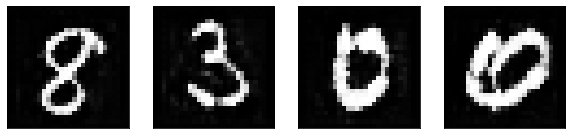

time taken in min: 0.718959101041158
epoch 42 batch 50 batch total loss 0.0063216803
epoch 42 batch 50 batch cluster loss 4.1823587e-05
epoch 42 batch 50 batch regen loss 0.006279857
saving...



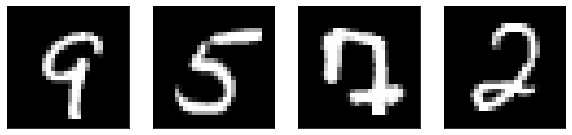

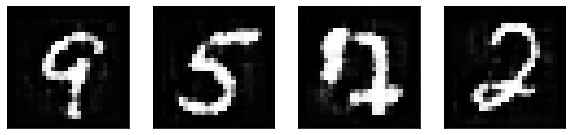

time taken in min: 2.0867162942886353
epoch 42 batch 100 batch total loss 0.0063821194
epoch 42 batch 100 batch cluster loss 4.32959e-05
epoch 42 batch 100 batch regen loss 0.0063388236
saving...



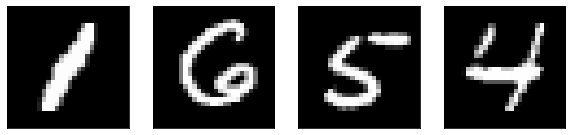

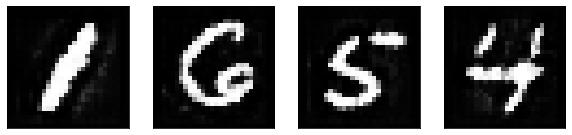

time taken in min: 2.092160912354787

epoch 42 epoch avg loss 0.006360856871420549
epoch 42 epoch avg cluster loss 4.238120188455145e-05
epoch 42 epoch avg regen loss 0.0063184756761953485



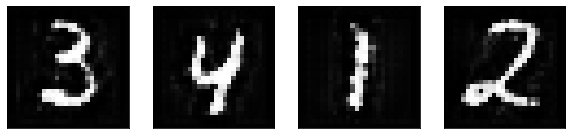

saving...

epoch 43
epoch 43 batch 0 batch total loss 0.0063977106
epoch 43 batch 0 batch cluster loss 4.0617277e-05
epoch 43 batch 0 batch regen loss 0.0063570933
saving...



time taken in min: 0.7207171638806661
epoch 43 batch 50 batch total loss 0.0063308077
epoch 43 batch 50 batch cluster loss 4.265092e-05
epoch 43 batch 50 batch regen loss 0.006288157
saving...



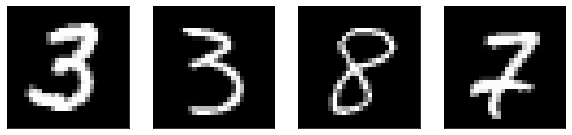

time taken in min: 2.0942551255226136
epoch 43 batch 100 batch total loss 0.006312159
epoch 43 batch 100 batch cluster loss 4.2572257e-05
epoch 43 batch 100 batch regen loss 0.0062695867
saving...



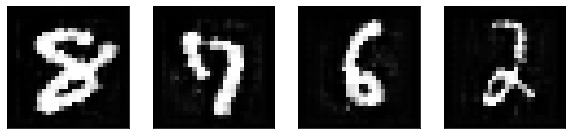

time taken in min: 2.093792223930359

epoch 43 epoch avg loss 0.006346620702168951
epoch 43 epoch avg cluster loss 4.151900392864294e-05
epoch 43 epoch avg regen loss 0.0063051016906560476



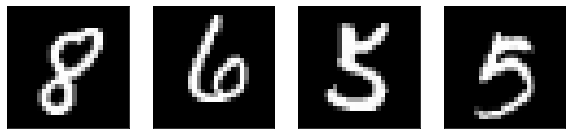

saving...

epoch 44
epoch 44 batch 0 batch total loss 0.0066518136
epoch 44 batch 0 batch cluster loss 4.318358e-05
epoch 44 batch 0 batch regen loss 0.00660863
saving...



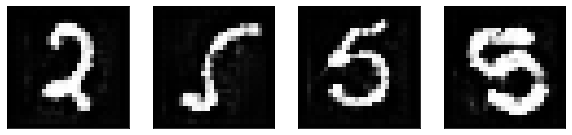

time taken in min: 0.7186950087547302
epoch 44 batch 50 batch total loss 0.0062431926
epoch 44 batch 50 batch cluster loss 3.995043e-05
epoch 44 batch 50 batch regen loss 0.006203242
saving...



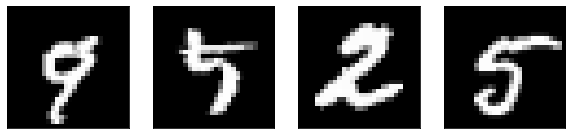

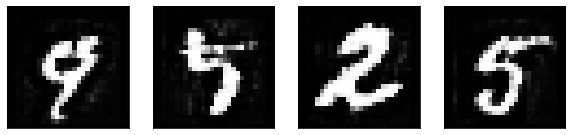

time taken in min: 2.0815165400505067
epoch 44 batch 100 batch total loss 0.0063286773
epoch 44 batch 100 batch cluster loss 4.059372e-05
epoch 44 batch 100 batch regen loss 0.0062880837
saving...



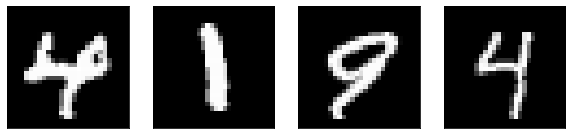

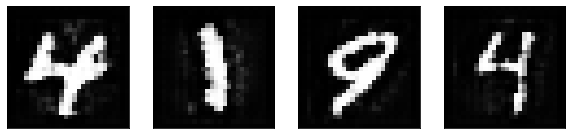

time taken in min: 2.0895299951235455

epoch 44 epoch avg loss 0.006332816019401712
epoch 44 epoch avg cluster loss 4.061284639415828e-05
epoch 44 epoch avg regen loss 0.0062922031887001914



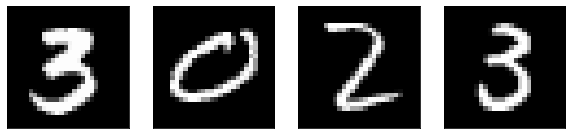

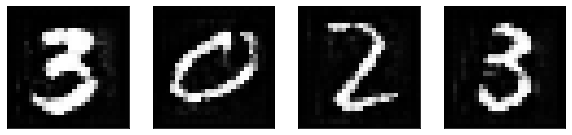

saving...

epoch 45
epoch 45 batch 0 batch total loss 0.006185579
epoch 45 batch 0 batch cluster loss 4.0034396e-05
epoch 45 batch 0 batch regen loss 0.006145545
saving...



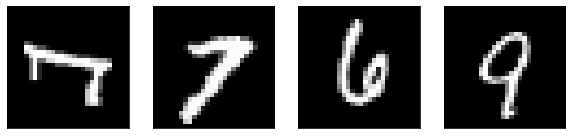

time taken in min: 0.7170152942339579
epoch 45 batch 50 batch total loss 0.0065088402
epoch 45 batch 50 batch cluster loss 3.9598424e-05
epoch 45 batch 50 batch regen loss 0.006469242
saving...



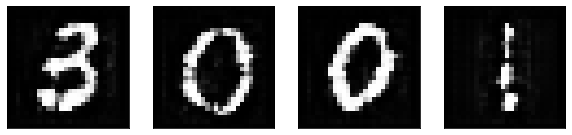

time taken in min: 2.089260705312093
epoch 45 batch 100 batch total loss 0.0062927394
epoch 45 batch 100 batch cluster loss 4.0209157e-05
epoch 45 batch 100 batch regen loss 0.00625253
saving...



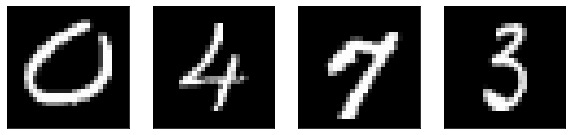

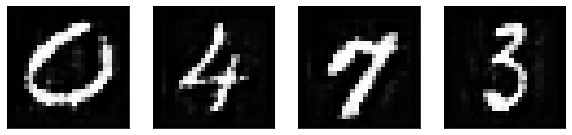

time taken in min: 2.090394441286723

epoch 45 epoch avg loss 0.006316579854652538
epoch 45 epoch avg cluster loss 3.9933998038068854e-05
epoch 45 epoch avg regen loss 0.006276645851558295



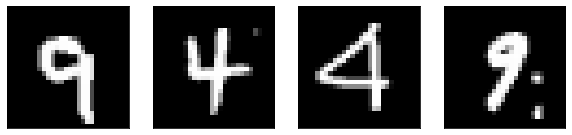

saving...

epoch 46
epoch 46 batch 0 batch total loss 0.0063055516
epoch 46 batch 0 batch cluster loss 3.8869053e-05
epoch 46 batch 0 batch regen loss 0.0062666824
saving...



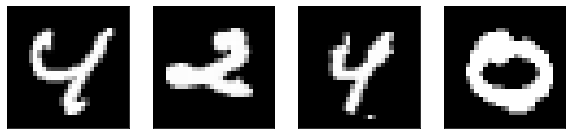

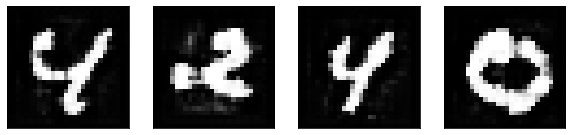

time taken in min: 0.7234197139739991
epoch 46 batch 50 batch total loss 0.006484788
epoch 46 batch 50 batch cluster loss 3.8392143e-05
epoch 46 batch 50 batch regen loss 0.0064463955
saving...



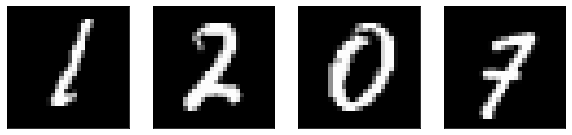

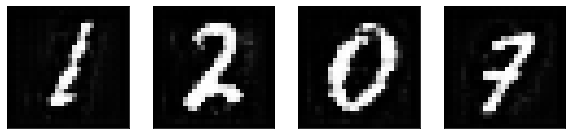

time taken in min: 2.085605192184448
epoch 46 batch 100 batch total loss 0.0061829523
epoch 46 batch 100 batch cluster loss 3.7260437e-05
epoch 46 batch 100 batch regen loss 0.006145692
saving...



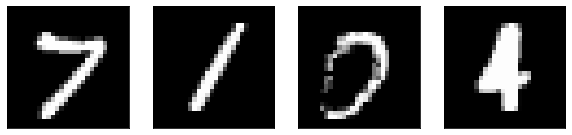

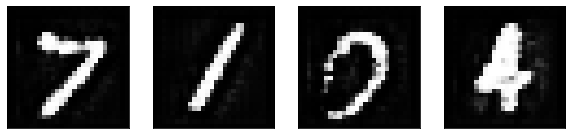

time taken in min: 2.087109609444936

epoch 46 epoch avg loss 0.0062967188877321905
epoch 46 epoch avg cluster loss 3.889555021379561e-05
epoch 46 epoch avg regen loss 0.006257823340878901



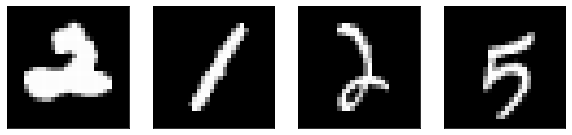

saving...

epoch 47
epoch 47 batch 0 batch total loss 0.006240648
epoch 47 batch 0 batch cluster loss 3.6365665e-05
epoch 47 batch 0 batch regen loss 0.0062042824
saving...



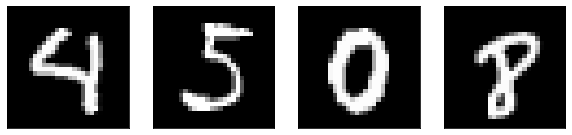

time taken in min: 0.7170169671376546
epoch 47 batch 50 batch total loss 0.006176597
epoch 47 batch 50 batch cluster loss 4.0272047e-05
epoch 47 batch 50 batch regen loss 0.0061363247
saving...



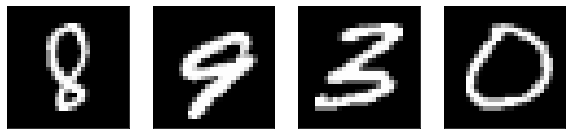

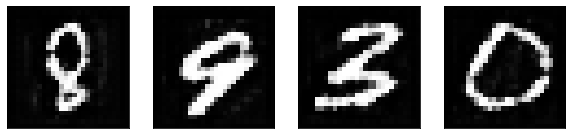

time taken in min: 2.0919100721677144
epoch 47 batch 100 batch total loss 0.0063112085
epoch 47 batch 100 batch cluster loss 3.8218674e-05
epoch 47 batch 100 batch regen loss 0.00627299
saving...



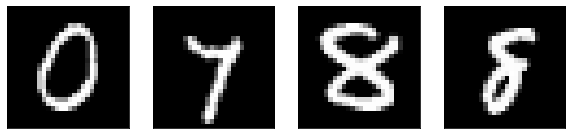

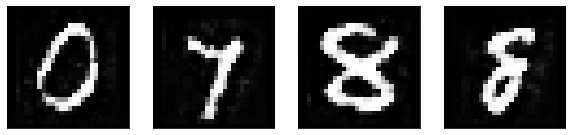

time taken in min: 2.0917729258537294

epoch 47 epoch avg loss 0.006285023622972481
epoch 47 epoch avg cluster loss 3.8150510189845624e-05
epoch 47 epoch avg regen loss 0.0062468731223400365



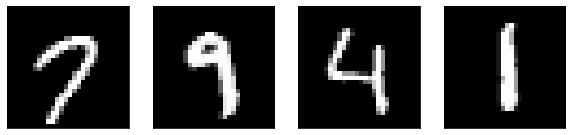

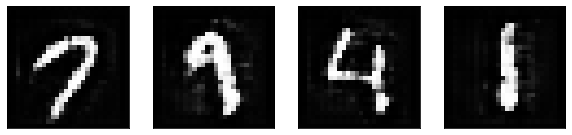

saving...

epoch 48
epoch 48 batch 0 batch total loss 0.006288726
epoch 48 batch 0 batch cluster loss 4.1459676e-05
epoch 48 batch 0 batch regen loss 0.006247266
saving...



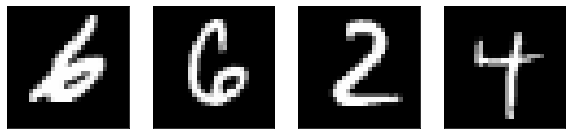

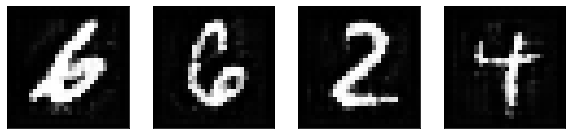

time taken in min: 0.7240547935167948
epoch 48 batch 50 batch total loss 0.0064259577
epoch 48 batch 50 batch cluster loss 3.794645e-05
epoch 48 batch 50 batch regen loss 0.0063880114
saving...



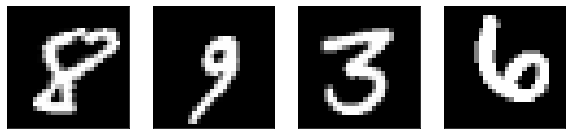

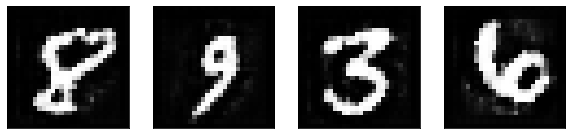

time taken in min: 2.0909570256868997
epoch 48 batch 100 batch total loss 0.006031035
epoch 48 batch 100 batch cluster loss 3.802146e-05
epoch 48 batch 100 batch regen loss 0.0059930137
saving...



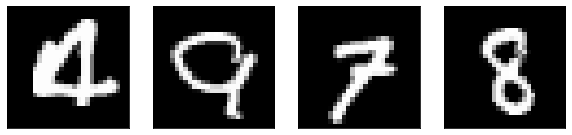

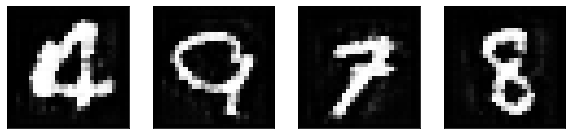

time taken in min: 2.0877761046091714

epoch 48 epoch avg loss 0.006269948166337306
epoch 48 epoch avg cluster loss 3.751450791334441e-05
epoch 48 epoch avg regen loss 0.006232433644581144



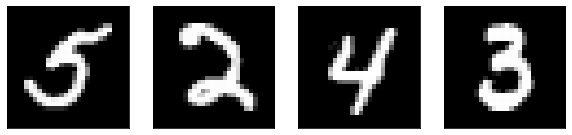

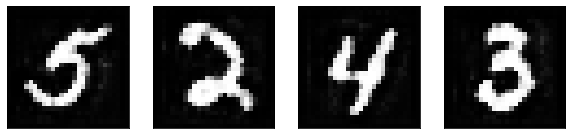

saving...

epoch 49
epoch 49 batch 0 batch total loss 0.006238158
epoch 49 batch 0 batch cluster loss 3.8269056e-05
epoch 49 batch 0 batch regen loss 0.006199889
saving...



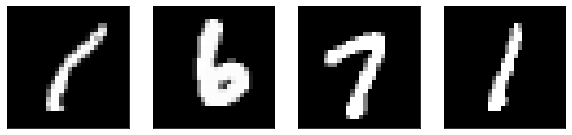

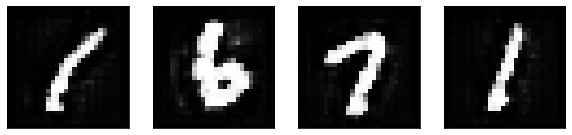

time taken in min: 0.7197191794713338
epoch 49 batch 50 batch total loss 0.006069838
epoch 49 batch 50 batch cluster loss 3.623687e-05
epoch 49 batch 50 batch regen loss 0.0060336012
saving...



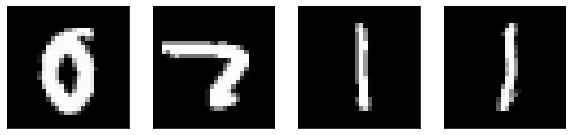

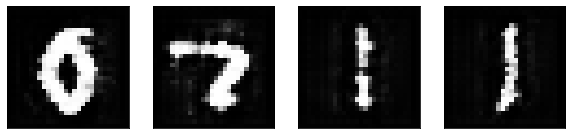

time taken in min: 2.087212912241618
epoch 49 batch 100 batch total loss 0.00626699
epoch 49 batch 100 batch cluster loss 3.5383076e-05
epoch 49 batch 100 batch regen loss 0.006231607
saving...



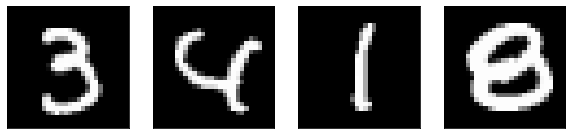

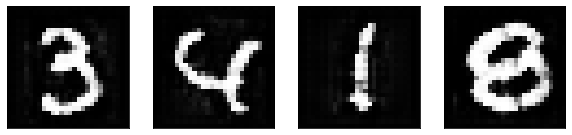

time taken in min: 2.087305160363515

epoch 49 epoch avg loss 0.006253246214019798
epoch 49 epoch avg cluster loss 3.696234982610696e-05
epoch 49 epoch avg regen loss 0.006216283856054484



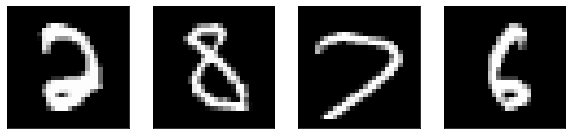

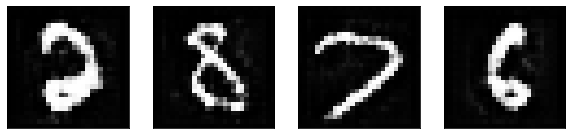

saving...

epoch 50
epoch 50 batch 0 batch total loss 0.006032821
epoch 50 batch 0 batch cluster loss 3.5772813e-05
epoch 50 batch 0 batch regen loss 0.0059970478
saving...



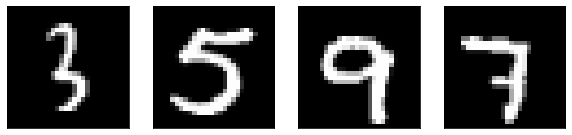

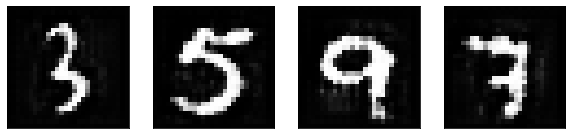

time taken in min: 0.7197241266568501
epoch 50 batch 50 batch total loss 0.0063178255
epoch 50 batch 50 batch cluster loss 3.5754307e-05
epoch 50 batch 50 batch regen loss 0.006282071
saving...



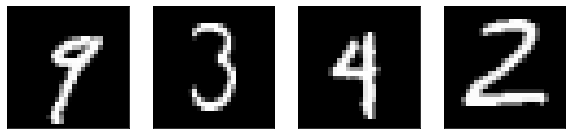

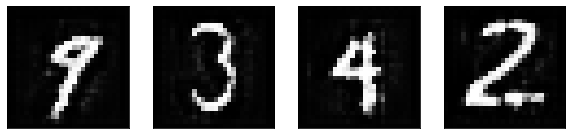

time taken in min: 2.0861326654752097
epoch 50 batch 100 batch total loss 0.0062925178
epoch 50 batch 100 batch cluster loss 3.5790545e-05
epoch 50 batch 100 batch regen loss 0.006256727
saving...



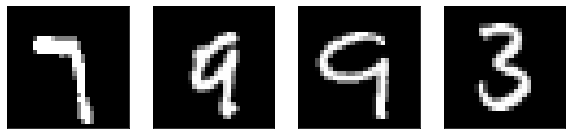

time taken in min: 2.0855159560839334

epoch 50 epoch avg loss 0.006238209663779806
epoch 50 epoch avg cluster loss 3.602101923345383e-05
epoch 50 epoch avg regen loss 0.006202188632214221



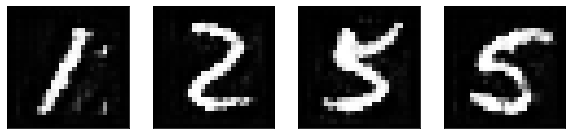

saving...

epoch 51
epoch 51 batch 0 batch total loss 0.0062106233
epoch 51 batch 0 batch cluster loss 3.3713797e-05
epoch 51 batch 0 batch regen loss 0.0061769094
saving...



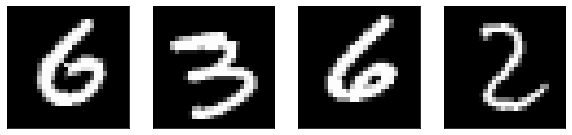

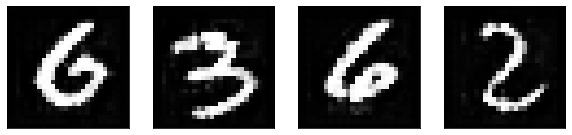

time taken in min: 0.7221842885017395
epoch 51 batch 50 batch total loss 0.0061788163
epoch 51 batch 50 batch cluster loss 3.523554e-05
epoch 51 batch 50 batch regen loss 0.0061435807
saving...



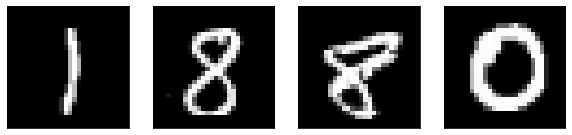

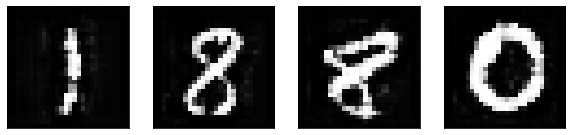

time taken in min: 2.0880605538686114
epoch 51 batch 100 batch total loss 0.006126404
epoch 51 batch 100 batch cluster loss 3.3955097e-05
epoch 51 batch 100 batch regen loss 0.0060924487
saving...



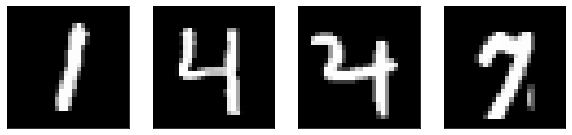

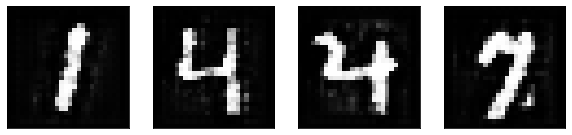

time taken in min: 2.089114185174306

epoch 51 epoch avg loss 0.006229084770400393
epoch 51 epoch avg cluster loss 3.5497152073391696e-05
epoch 51 epoch avg regen loss 0.006193587599890464



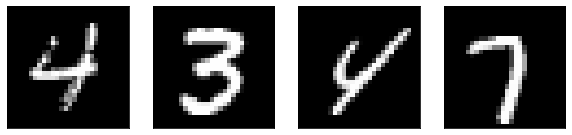

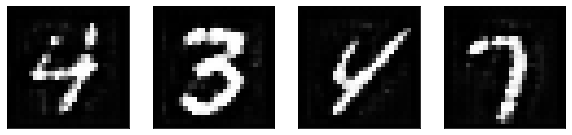

saving...

epoch 52
epoch 52 batch 0 batch total loss 0.006290834
epoch 52 batch 0 batch cluster loss 3.5233137e-05
epoch 52 batch 0 batch regen loss 0.0062556006
saving...



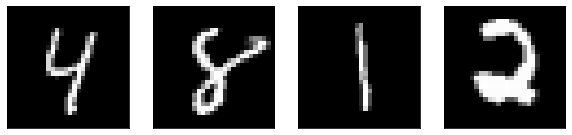

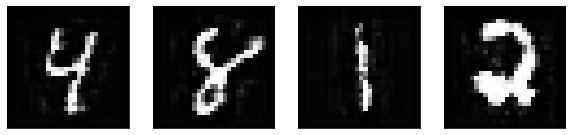

time taken in min: 0.7169929504394531
epoch 52 batch 50 batch total loss 0.0061602932
epoch 52 batch 50 batch cluster loss 3.4580724e-05
epoch 52 batch 50 batch regen loss 0.0061257123
saving...



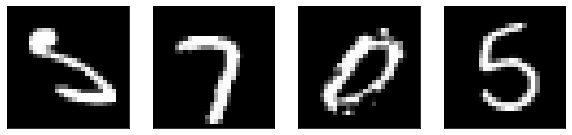

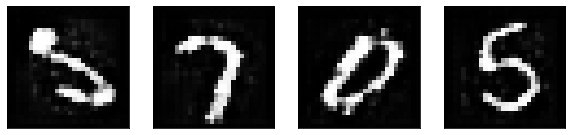

time taken in min: 2.095090699195862
epoch 52 batch 100 batch total loss 0.0062871287
epoch 52 batch 100 batch cluster loss 3.3653014e-05
epoch 52 batch 100 batch regen loss 0.006253476
saving...



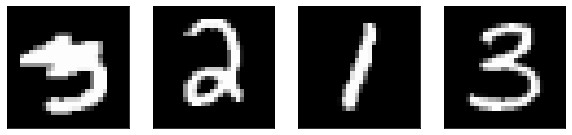

time taken in min: 2.0928576747576395

epoch 52 epoch avg loss 0.006211711910663773
epoch 52 epoch avg cluster loss 3.495961372810613e-05
epoch 52 epoch avg regen loss 0.006176752310593502



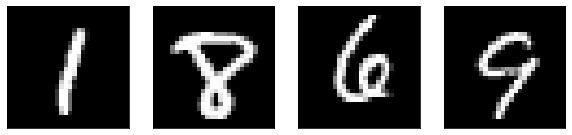

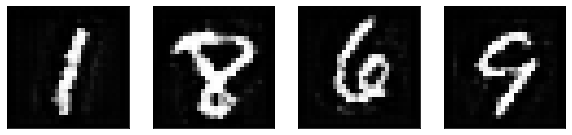

saving...

epoch 53
epoch 53 batch 0 batch total loss 0.0061444645
epoch 53 batch 0 batch cluster loss 3.3410794e-05
epoch 53 batch 0 batch regen loss 0.0061110537
saving...



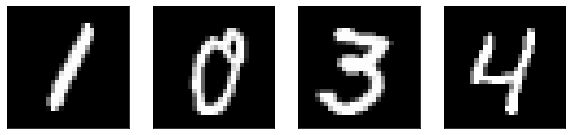

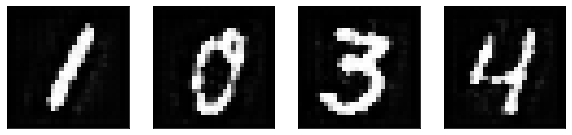

time taken in min: 0.7170488317807515
epoch 53 batch 50 batch total loss 0.0062765856
epoch 53 batch 50 batch cluster loss 3.5186018e-05
epoch 53 batch 50 batch regen loss 0.0062414
saving...



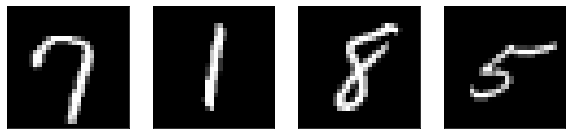

time taken in min: 2.0900224924087523
epoch 53 batch 100 batch total loss 0.0062164096
epoch 53 batch 100 batch cluster loss 3.2615862e-05
epoch 53 batch 100 batch regen loss 0.006183794
saving...



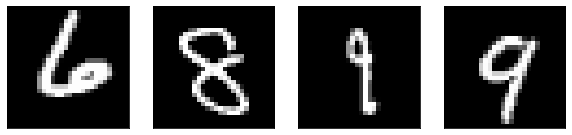

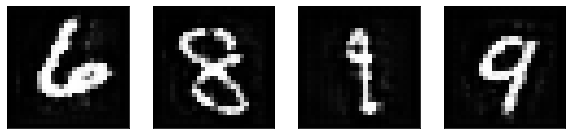

time taken in min: 2.0929539998372397

epoch 53 epoch avg loss 0.006197312029899429
epoch 53 epoch avg cluster loss 3.453002278485841e-05
epoch 53 epoch avg regen loss 0.006162782010259264



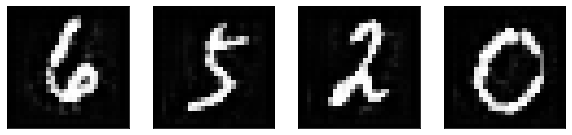

saving...

epoch 54
epoch 54 batch 0 batch total loss 0.0061669503
epoch 54 batch 0 batch cluster loss 3.3492594e-05
epoch 54 batch 0 batch regen loss 0.0061334576
saving...



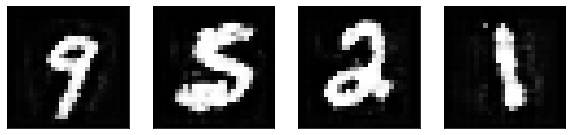

time taken in min: 0.7180109182993571
epoch 54 batch 50 batch total loss 0.006132381
epoch 54 batch 50 batch cluster loss 3.5217436e-05
epoch 54 batch 50 batch regen loss 0.0060971635
saving...



time taken in min: 2.0842945138613382
epoch 54 batch 100 batch total loss 0.006044877
epoch 54 batch 100 batch cluster loss 3.263705e-05
epoch 54 batch 100 batch regen loss 0.00601224
saving...



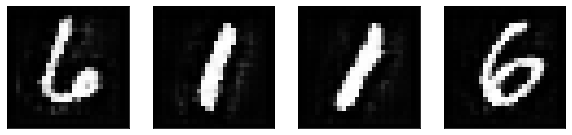

time taken in min: 2.084665640195211

epoch 54 epoch avg loss 0.006180910760599931
epoch 54 epoch avg cluster loss 3.348378908474657e-05
epoch 54 epoch avg regen loss 0.006147426971376447



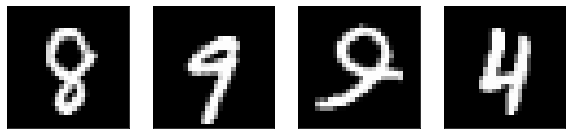

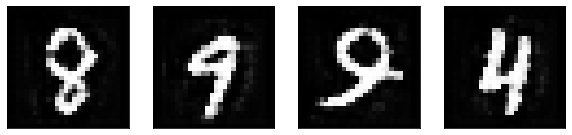

saving...

epoch 55
epoch 55 batch 0 batch total loss 0.006200253
epoch 55 batch 0 batch cluster loss 3.1748234e-05
epoch 55 batch 0 batch regen loss 0.0061685047
saving...



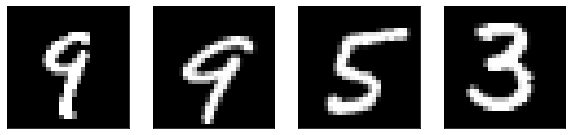

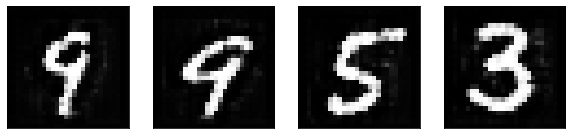

time taken in min: 0.7211701273918152
epoch 55 batch 50 batch total loss 0.0063247774
epoch 55 batch 50 batch cluster loss 3.1542917e-05
epoch 55 batch 50 batch regen loss 0.0062932344
saving...



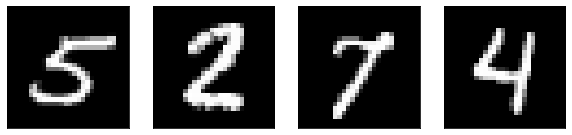

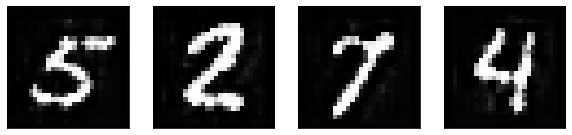

time taken in min: 2.0849443753560384
epoch 55 batch 100 batch total loss 0.0060783857
epoch 55 batch 100 batch cluster loss 3.3760898e-05
epoch 55 batch 100 batch regen loss 0.006044625
saving...



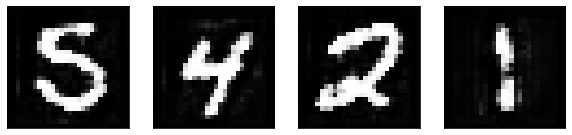

time taken in min: 2.0916459838549297

epoch 55 epoch avg loss 0.006171640261250027
epoch 55 epoch avg cluster loss 3.3079274606094814e-05
epoch 55 epoch avg regen loss 0.006138560989619059



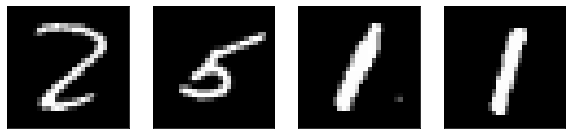

saving...

epoch 56
epoch 56 batch 0 batch total loss 0.0061135995
epoch 56 batch 0 batch cluster loss 3.1813815e-05
epoch 56 batch 0 batch regen loss 0.0060817855
saving...



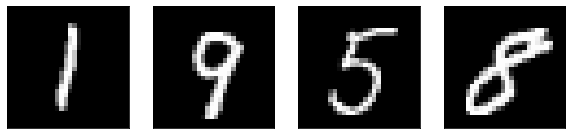

time taken in min: 0.7187793016433716
epoch 56 batch 50 batch total loss 0.0063365363
epoch 56 batch 50 batch cluster loss 3.153136e-05
epoch 56 batch 50 batch regen loss 0.006305005
saving...



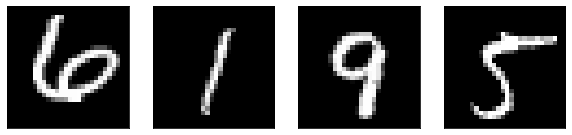

time taken in min: 2.077093454202016
epoch 56 batch 100 batch total loss 0.0062345183
epoch 56 batch 100 batch cluster loss 3.430977e-05
epoch 56 batch 100 batch regen loss 0.0062002083
saving...



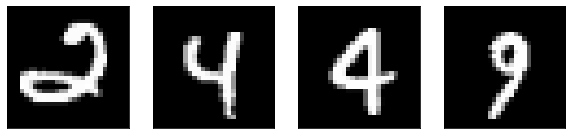

time taken in min: 2.091261386871338

epoch 56 epoch avg loss 0.006159140546885082
epoch 56 epoch avg cluster loss 3.2366007764136097e-05
epoch 56 epoch avg regen loss 0.006126774530226396



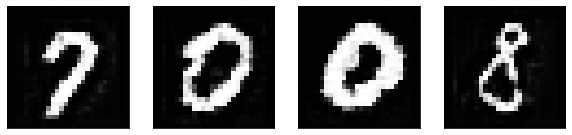

saving...

epoch 57
epoch 57 batch 0 batch total loss 0.005989819
epoch 57 batch 0 batch cluster loss 3.016624e-05
epoch 57 batch 0 batch regen loss 0.0059596524
saving...



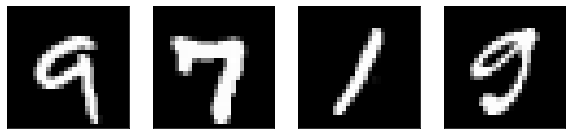

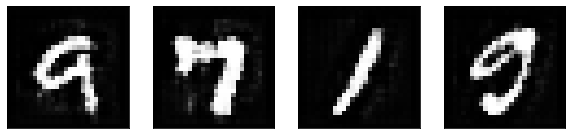

time taken in min: 0.7174847563107808
epoch 57 batch 50 batch total loss 0.0060839686
epoch 57 batch 50 batch cluster loss 3.255438e-05
epoch 57 batch 50 batch regen loss 0.006051414
saving...



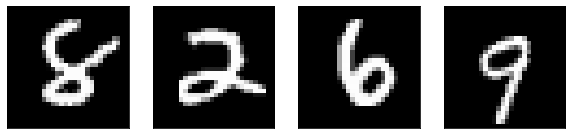

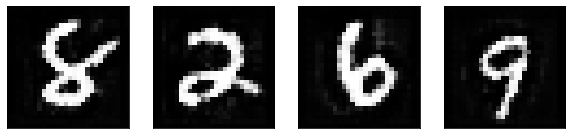

time taken in min: 2.0761353174845376
epoch 57 batch 100 batch total loss 0.0060770926
epoch 57 batch 100 batch cluster loss 3.186839e-05
epoch 57 batch 100 batch regen loss 0.006045224
saving...



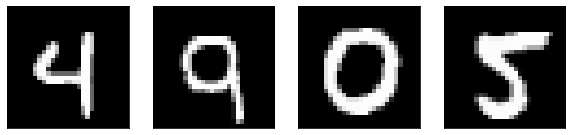

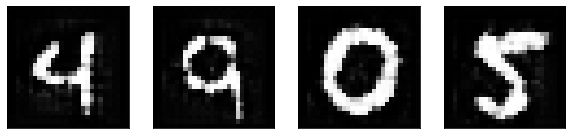

time taken in min: 2.0905468185742695

epoch 57 epoch avg loss 0.006146752393914987
epoch 57 epoch avg cluster loss 3.201433266162817e-05
epoch 57 epoch avg regen loss 0.006114738046238988



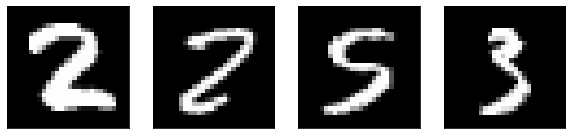

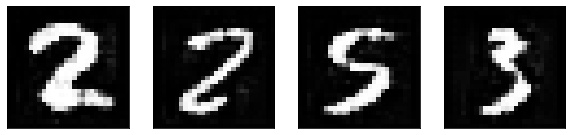

saving...

epoch 58
epoch 58 batch 0 batch total loss 0.006002284
epoch 58 batch 0 batch cluster loss 3.2387023e-05
epoch 58 batch 0 batch regen loss 0.005969897
saving...



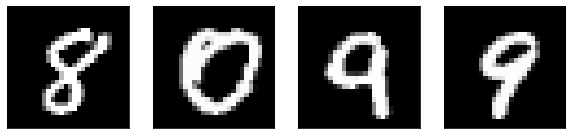

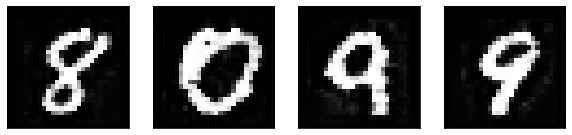

time taken in min: 0.7187779506047567
epoch 58 batch 50 batch total loss 0.0060054124
epoch 58 batch 50 batch cluster loss 3.1780237e-05
epoch 58 batch 50 batch regen loss 0.005973632
saving...



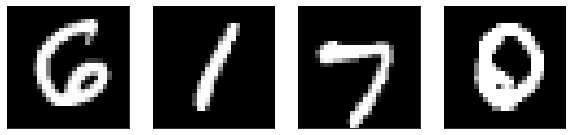

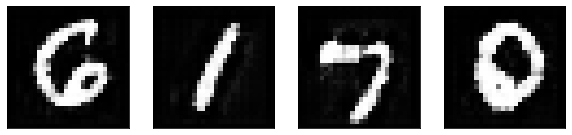

time taken in min: 2.0862398306528727
epoch 58 batch 100 batch total loss 0.0059485068
epoch 58 batch 100 batch cluster loss 3.2196232e-05
epoch 58 batch 100 batch regen loss 0.0059163105
saving...



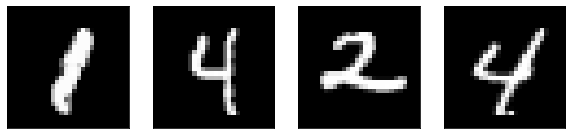

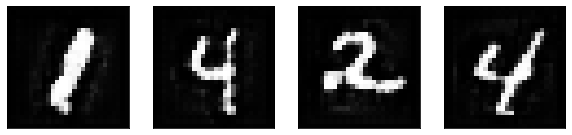

time taken in min: 2.0910224318504333

epoch 58 epoch avg loss 0.006133322094930178
epoch 58 epoch avg cluster loss 3.151152446600648e-05
epoch 58 epoch avg regen loss 0.0061018105588411375



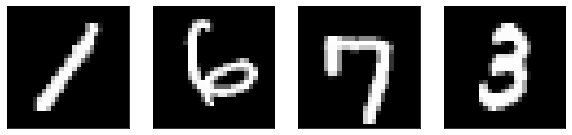

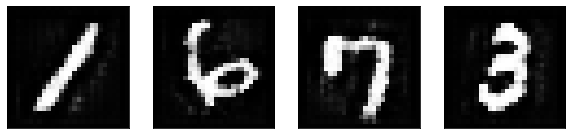

saving...

epoch 59
epoch 59 batch 0 batch total loss 0.0061397483
epoch 59 batch 0 batch cluster loss 3.0893814e-05
epoch 59 batch 0 batch regen loss 0.0061088544
saving...



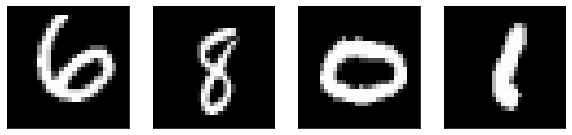

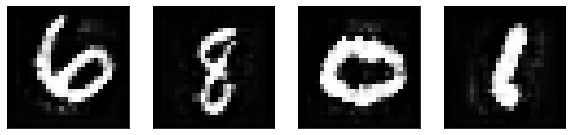

time taken in min: 0.7201575517654419
epoch 59 batch 50 batch total loss 0.0060155
epoch 59 batch 50 batch cluster loss 3.093877e-05
epoch 59 batch 50 batch regen loss 0.005984561
saving...



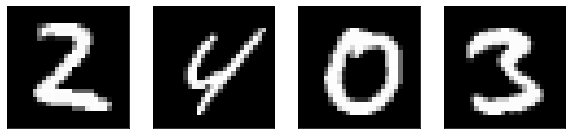

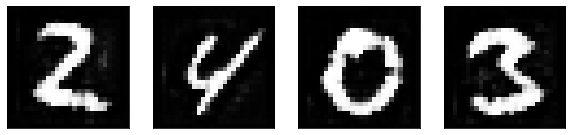

time taken in min: 2.089482041200002
epoch 59 batch 100 batch total loss 0.0061966516
epoch 59 batch 100 batch cluster loss 2.9515562e-05
epoch 59 batch 100 batch regen loss 0.006167136
saving...



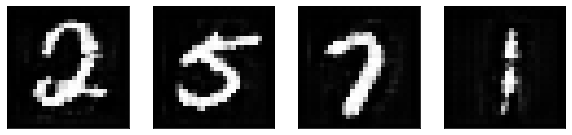

time taken in min: 2.0888697187105816

epoch 59 epoch avg loss 0.0061194995552364545
epoch 59 epoch avg cluster loss 3.081858237962124e-05
epoch 59 epoch avg regen loss 0.006088680978390878



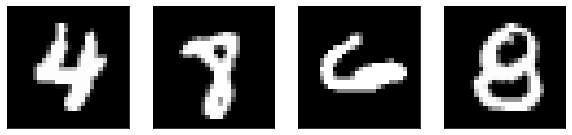

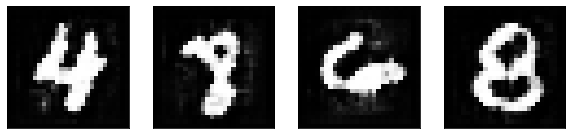

saving...

epoch 60
epoch 60 batch 0 batch total loss 0.0061200685
epoch 60 batch 0 batch cluster loss 3.1103737e-05
epoch 60 batch 0 batch regen loss 0.0060889646
saving...



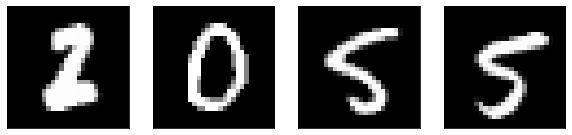

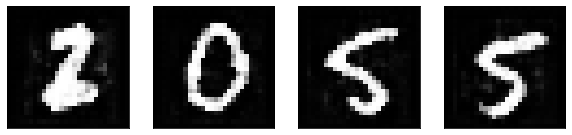

time taken in min: 0.717778750260671
epoch 60 batch 50 batch total loss 0.0060376353
epoch 60 batch 50 batch cluster loss 3.0140109e-05
epoch 60 batch 50 batch regen loss 0.0060074953
saving...



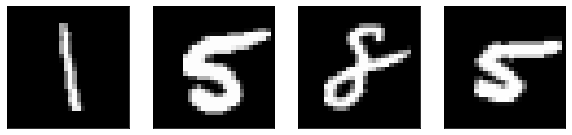

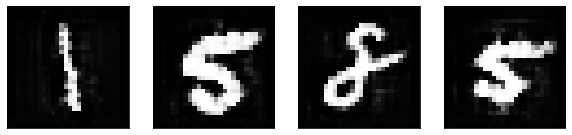

time taken in min: 2.082561123371124
epoch 60 batch 100 batch total loss 0.006030258
epoch 60 batch 100 batch cluster loss 3.0575993e-05
epoch 60 batch 100 batch regen loss 0.005999682
saving...



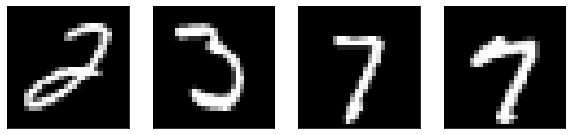

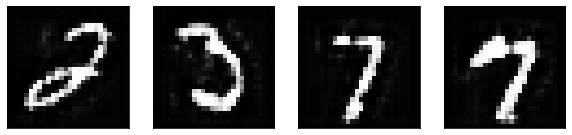

time taken in min: 2.0911413192749024

epoch 60 epoch avg loss 0.006110380956176984
epoch 60 epoch avg cluster loss 3.058002739172958e-05
epoch 60 epoch avg regen loss 0.006079800920245253



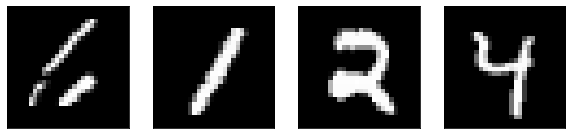

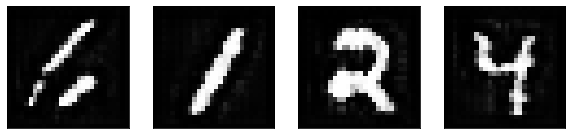

saving...

epoch 61
epoch 61 batch 0 batch total loss 0.006101493
epoch 61 batch 0 batch cluster loss 3.1801137e-05
epoch 61 batch 0 batch regen loss 0.006069692
saving...



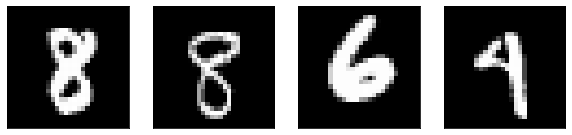

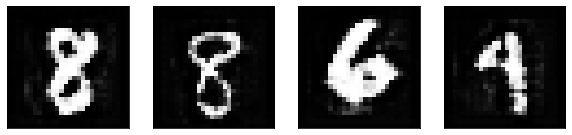

time taken in min: 0.7217980662981669
epoch 61 batch 50 batch total loss 0.0063037463
epoch 61 batch 50 batch cluster loss 2.9440409e-05
epoch 61 batch 50 batch regen loss 0.0062743057
saving...



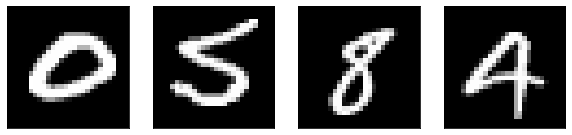

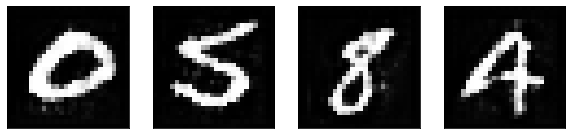

time taken in min: 2.0884235978126524
epoch 61 batch 100 batch total loss 0.006029391
epoch 61 batch 100 batch cluster loss 3.095145e-05
epoch 61 batch 100 batch regen loss 0.0059984396
saving...



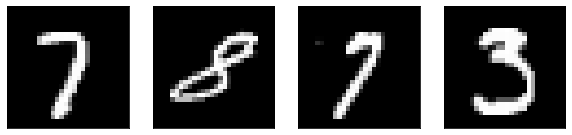

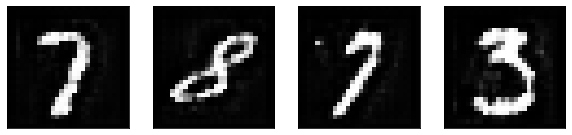

time taken in min: 2.091192313035329

epoch 61 epoch avg loss 0.006095824834211903
epoch 61 epoch avg cluster loss 2.9903615571946198e-05
epoch 61 epoch avg regen loss 0.00606592121470909



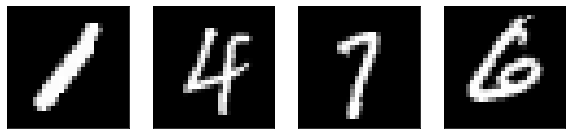

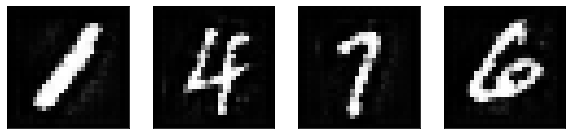

saving...

epoch 62
epoch 62 batch 0 batch total loss 0.0060755615
epoch 62 batch 0 batch cluster loss 2.9000134e-05
epoch 62 batch 0 batch regen loss 0.0060465615
saving...



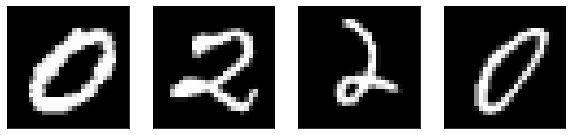

time taken in min: 0.7193689028422038
epoch 62 batch 50 batch total loss 0.0059688943
epoch 62 batch 50 batch cluster loss 2.766927e-05
epoch 62 batch 50 batch regen loss 0.005941225
saving...



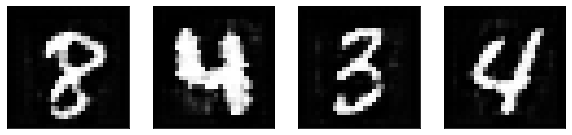

time taken in min: 2.0898434082667032
epoch 62 batch 100 batch total loss 0.0061637387
epoch 62 batch 100 batch cluster loss 2.8780787e-05
epoch 62 batch 100 batch regen loss 0.006134958
saving...



time taken in min: 2.0820493578910826

epoch 62 epoch avg loss 0.006085328339457007
epoch 62 epoch avg cluster loss 2.9530842489216642e-05
epoch 62 epoch avg regen loss 0.006055797497599812



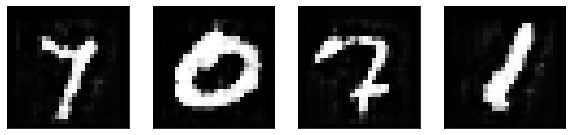

saving...

epoch 63
epoch 63 batch 0 batch total loss 0.0061175493
epoch 63 batch 0 batch cluster loss 3.0355006e-05
epoch 63 batch 0 batch regen loss 0.006087194
saving...



time taken in min: 0.7163423736890157
epoch 63 batch 50 batch total loss 0.006174544
epoch 63 batch 50 batch cluster loss 2.9842826e-05
epoch 63 batch 50 batch regen loss 0.006144701
saving...



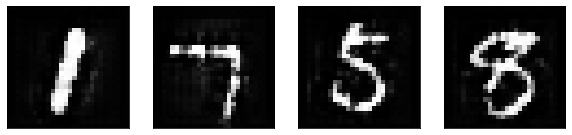

time taken in min: 2.0803175806999206
epoch 63 batch 100 batch total loss 0.0060586547
epoch 63 batch 100 batch cluster loss 2.8251736e-05
epoch 63 batch 100 batch regen loss 0.006030403
saving...



time taken in min: 2.0885750969250996

epoch 63 epoch avg loss 0.006072768546893435
epoch 63 epoch avg cluster loss 2.9127141468792214e-05
epoch 63 epoch avg regen loss 0.006043641393909515



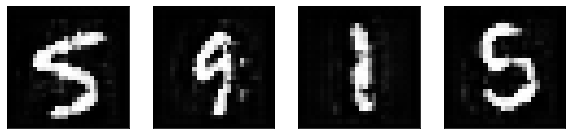

saving...

epoch 64
epoch 64 batch 0 batch total loss 0.006051067
epoch 64 batch 0 batch cluster loss 2.9022234e-05
epoch 64 batch 0 batch regen loss 0.0060220445
saving...



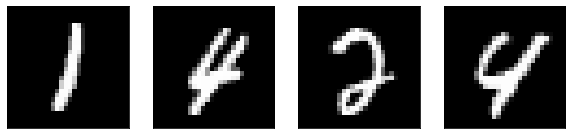

time taken in min: 0.7202850143114726
epoch 64 batch 50 batch total loss 0.0059903385
epoch 64 batch 50 batch cluster loss 2.8875638e-05
epoch 64 batch 50 batch regen loss 0.005961463
saving...



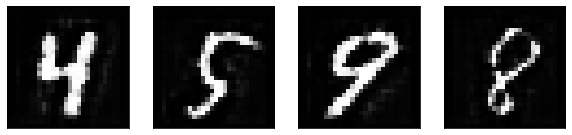

time taken in min: 2.082673160235087
epoch 64 batch 100 batch total loss 0.0059421193
epoch 64 batch 100 batch cluster loss 2.8537508e-05
epoch 64 batch 100 batch regen loss 0.0059135817
saving...



time taken in min: 2.0819624145825704

epoch 64 epoch avg loss 0.006060688318368994
epoch 64 epoch avg cluster loss 2.8576637259132025e-05
epoch 64 epoch avg regen loss 0.006032111687522571



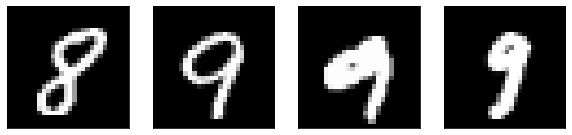

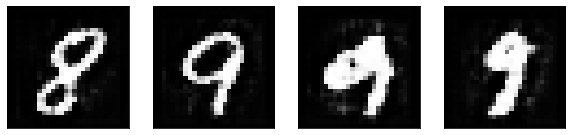

saving...

epoch 65
epoch 65 batch 0 batch total loss 0.005997036
epoch 65 batch 0 batch cluster loss 2.7294322e-05
epoch 65 batch 0 batch regen loss 0.005969742
saving...



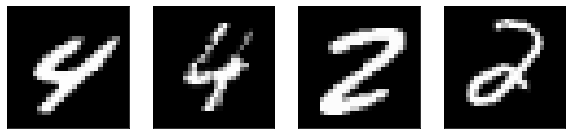

time taken in min: 0.7144543369611104
epoch 65 batch 50 batch total loss 0.006096714
epoch 65 batch 50 batch cluster loss 2.7691587e-05
epoch 65 batch 50 batch regen loss 0.0060690227
saving...



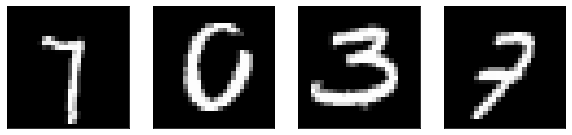

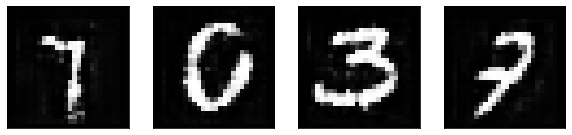

time taken in min: 2.0850931763648988
epoch 65 batch 100 batch total loss 0.0059349844
epoch 65 batch 100 batch cluster loss 2.7674287e-05
epoch 65 batch 100 batch regen loss 0.00590731
saving...



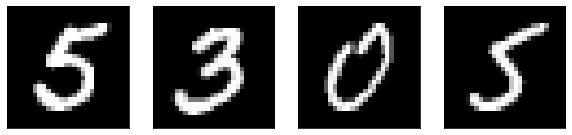

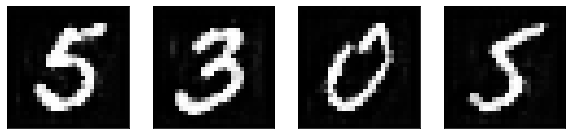

time taken in min: 2.083953110376994

epoch 65 epoch avg loss 0.0060499748136153665
epoch 65 epoch avg cluster loss 2.826516559915775e-05
epoch 65 epoch avg regen loss 0.006021709643083357



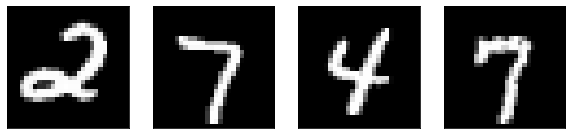

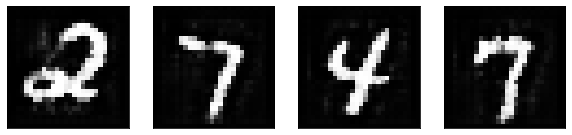

saving...

epoch 66
epoch 66 batch 0 batch total loss 0.006121859
epoch 66 batch 0 batch cluster loss 2.8063969e-05
epoch 66 batch 0 batch regen loss 0.006093795
saving...



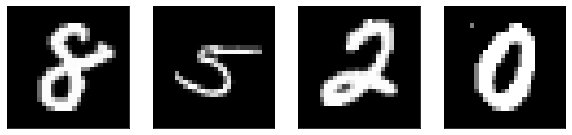

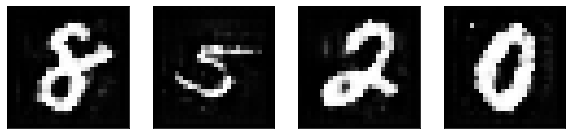

time taken in min: 0.7160094698270162
epoch 66 batch 50 batch total loss 0.006006702
epoch 66 batch 50 batch cluster loss 2.9487648e-05
epoch 66 batch 50 batch regen loss 0.0059772143
saving...



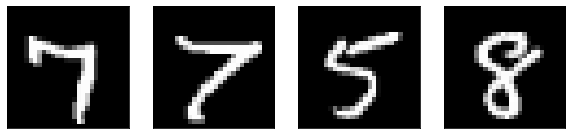

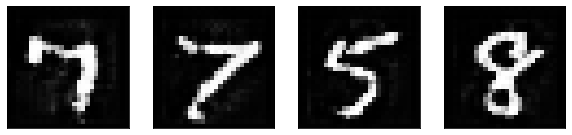

time taken in min: 2.0824276407559714
epoch 66 batch 100 batch total loss 0.0060607255
epoch 66 batch 100 batch cluster loss 2.8853927e-05
epoch 66 batch 100 batch regen loss 0.006031872
saving...



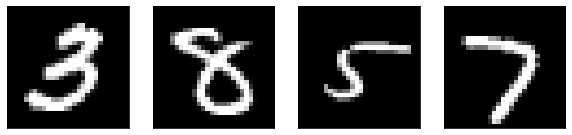

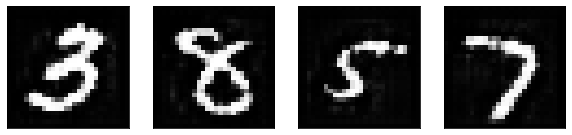

time taken in min: 2.0876623312632243

epoch 66 epoch avg loss 0.006038562639348082
epoch 66 epoch avg cluster loss 2.7932538984514087e-05
epoch 66 epoch avg regen loss 0.006010630112772776



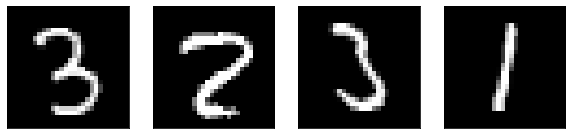

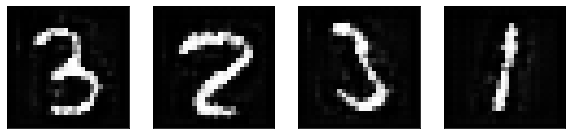

saving...

epoch 67
epoch 67 batch 0 batch total loss 0.0060417894
epoch 67 batch 0 batch cluster loss 2.7701915e-05
epoch 67 batch 0 batch regen loss 0.0060140877
saving...



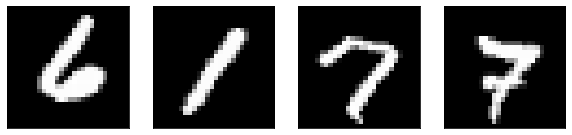

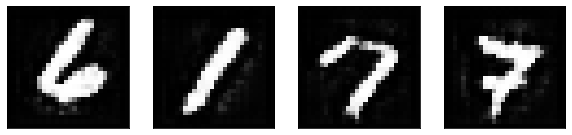

time taken in min: 0.7181324521700542
epoch 67 batch 50 batch total loss 0.006016375
epoch 67 batch 50 batch cluster loss 2.7284274e-05
epoch 67 batch 50 batch regen loss 0.0059890905
saving...



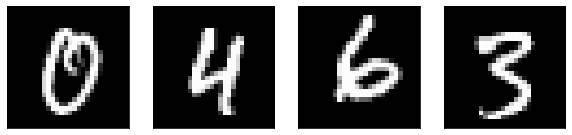

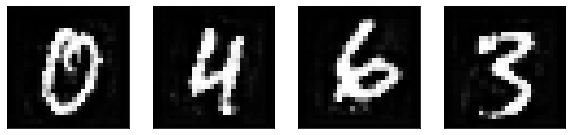

time taken in min: 2.0907502730687457
epoch 67 batch 100 batch total loss 0.0059864786
epoch 67 batch 100 batch cluster loss 2.654381e-05
epoch 67 batch 100 batch regen loss 0.005959935
saving...



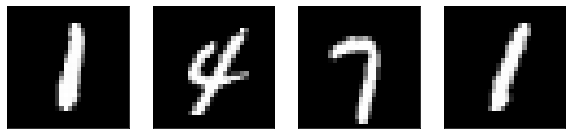

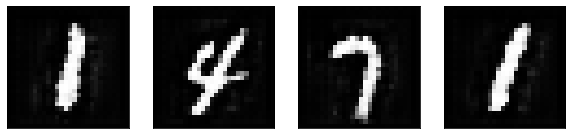

time taken in min: 2.0909226735432944

epoch 67 epoch avg loss 0.006024939564482893
epoch 67 epoch avg cluster loss 2.7582343753207263e-05
epoch 67 epoch avg regen loss 0.005997357203356795



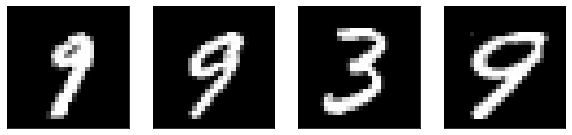

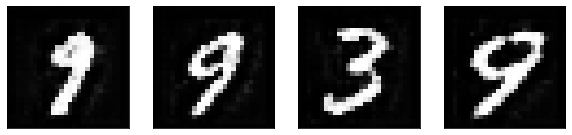

saving...

epoch 68
epoch 68 batch 0 batch total loss 0.0059762336
epoch 68 batch 0 batch cluster loss 2.6644768e-05
epoch 68 batch 0 batch regen loss 0.005949589
saving...



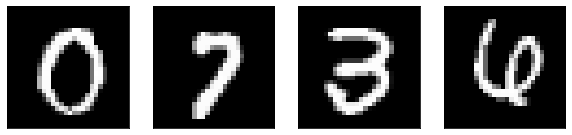

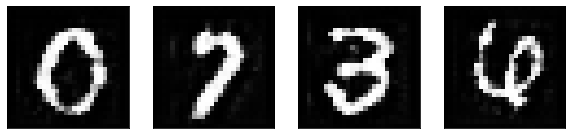

time taken in min: 0.7204680522282918
epoch 68 batch 50 batch total loss 0.0059063286
epoch 68 batch 50 batch cluster loss 2.6937349e-05
epoch 68 batch 50 batch regen loss 0.005879391
saving...



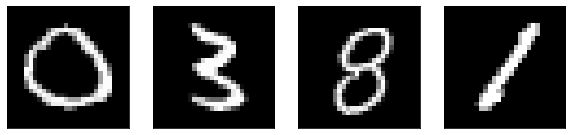

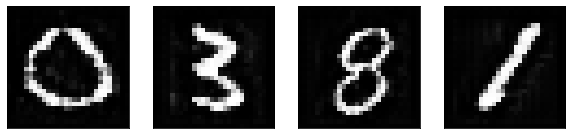

time taken in min: 2.0878299037615458
epoch 68 batch 100 batch total loss 0.0059530316
epoch 68 batch 100 batch cluster loss 2.810462e-05
epoch 68 batch 100 batch regen loss 0.005924927
saving...



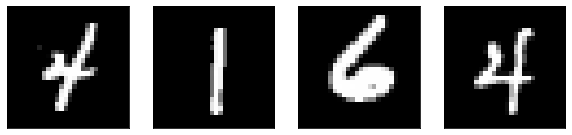

time taken in min: 2.0753737648328143

epoch 68 epoch avg loss 0.00601894015414735
epoch 68 epoch avg cluster loss 2.7149901328257175e-05
epoch 68 epoch avg regen loss 0.005991790246344724



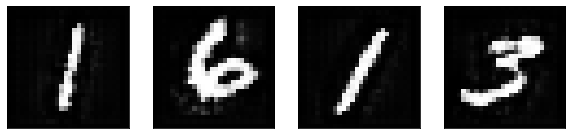

saving...

epoch 69
epoch 69 batch 0 batch total loss 0.0061780894
epoch 69 batch 0 batch cluster loss 2.604134e-05
epoch 69 batch 0 batch regen loss 0.0061520482
saving...



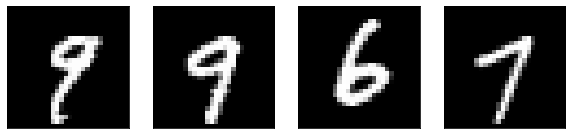

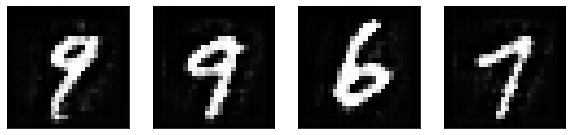

time taken in min: 0.7209275126457214
epoch 69 batch 50 batch total loss 0.0060483715
epoch 69 batch 50 batch cluster loss 2.5850582e-05
epoch 69 batch 50 batch regen loss 0.006022521
saving...



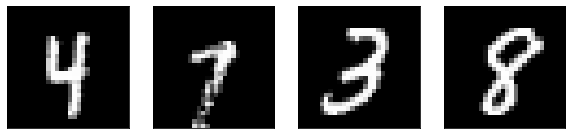

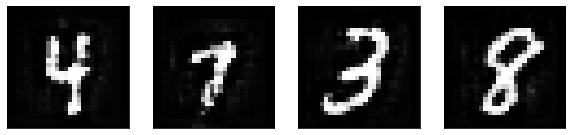

time taken in min: 2.0937433441480002
epoch 69 batch 100 batch total loss 0.0059629655
epoch 69 batch 100 batch cluster loss 2.6908487e-05
epoch 69 batch 100 batch regen loss 0.005936057
saving...



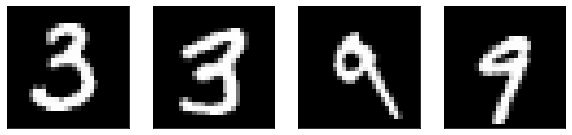

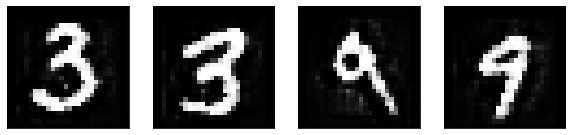

time taken in min: 2.0947017510732016

epoch 69 epoch avg loss 0.006005027489263123
epoch 69 epoch avg cluster loss 2.694666033938243e-05
epoch 69 epoch avg regen loss 0.005978080838666124



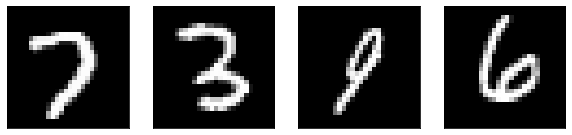

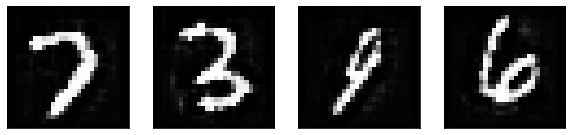

saving...

epoch 70
epoch 70 batch 0 batch total loss 0.0058560027
epoch 70 batch 0 batch cluster loss 2.5877589e-05
epoch 70 batch 0 batch regen loss 0.005830125
saving...



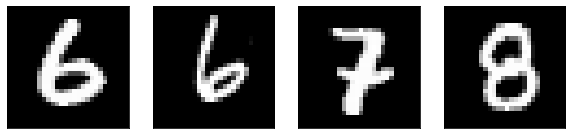

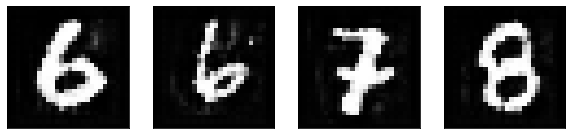

time taken in min: 0.7219695369402568
epoch 70 batch 50 batch total loss 0.005824253
epoch 70 batch 50 batch cluster loss 2.7123047e-05
epoch 70 batch 50 batch regen loss 0.00579713
saving...



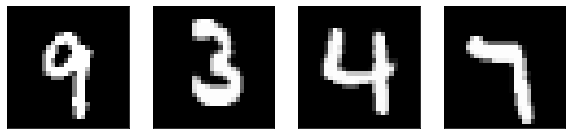

time taken in min: 2.086172942320506
epoch 70 batch 100 batch total loss 0.005893997
epoch 70 batch 100 batch cluster loss 2.6530588e-05
epoch 70 batch 100 batch regen loss 0.0058674663
saving...



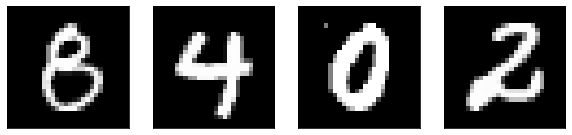

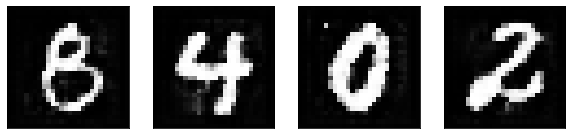

time taken in min: 2.0950529177983603

epoch 70 epoch avg loss 0.005995369839908208
epoch 70 epoch avg cluster loss 2.647441454166132e-05
epoch 70 epoch avg regen loss 0.0059688954211582065



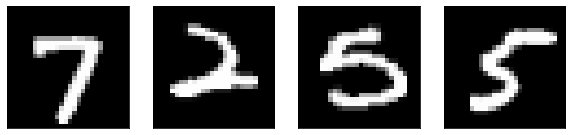

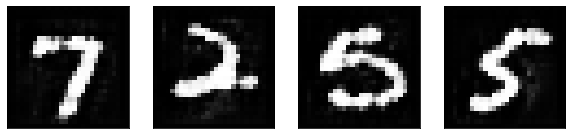

saving...

epoch 71
epoch 71 batch 0 batch total loss 0.0058411127
epoch 71 batch 0 batch cluster loss 2.5086269e-05
epoch 71 batch 0 batch regen loss 0.0058160266
saving...



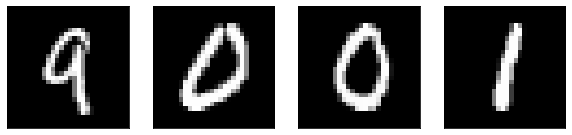

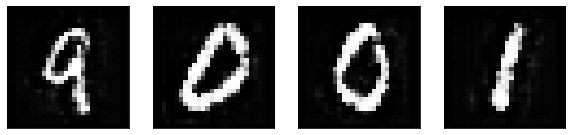

time taken in min: 0.7215141614278158
epoch 71 batch 50 batch total loss 0.0058625843
epoch 71 batch 50 batch cluster loss 2.6439258e-05
epoch 71 batch 50 batch regen loss 0.005836145
saving...



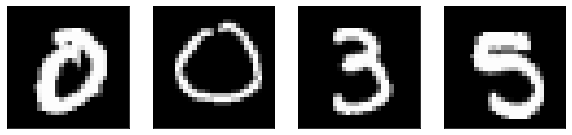

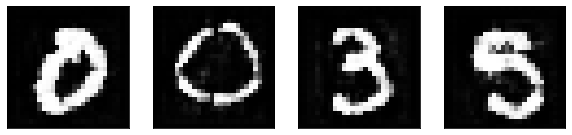

time taken in min: 2.0878212412198383
epoch 71 batch 100 batch total loss 0.005909784
epoch 71 batch 100 batch cluster loss 2.5851417e-05
epoch 71 batch 100 batch regen loss 0.005883933
saving...



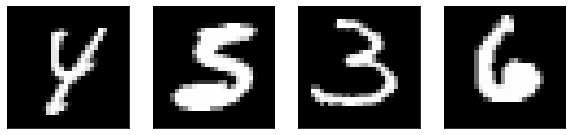

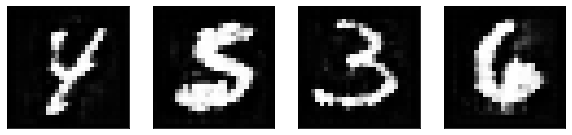

time taken in min: 2.09032305876414

epoch 71 epoch avg loss 0.005985036070095533
epoch 71 epoch avg cluster loss 2.6105313936876866e-05
epoch 71 epoch avg regen loss 0.005958930786572776



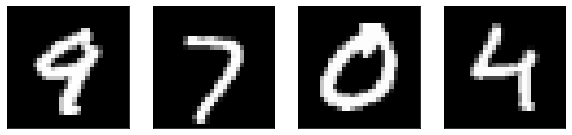

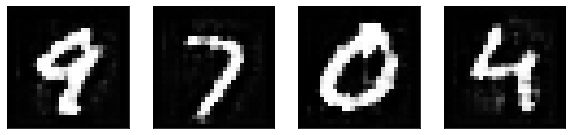

saving...

epoch 72
epoch 72 batch 0 batch total loss 0.006038775
epoch 72 batch 0 batch cluster loss 2.5966125e-05
epoch 72 batch 0 batch regen loss 0.006012809
saving...



time taken in min: 0.7222161849339803
epoch 72 batch 50 batch total loss 0.005872561
epoch 72 batch 50 batch cluster loss 2.3856603e-05
epoch 72 batch 50 batch regen loss 0.0058487044
saving...



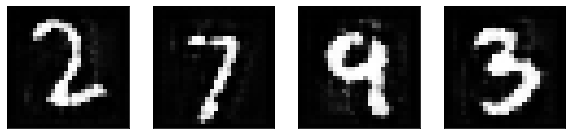

time taken in min: 2.0893079241116843
epoch 72 batch 100 batch total loss 0.0060128346
epoch 72 batch 100 batch cluster loss 2.6366675e-05
epoch 72 batch 100 batch regen loss 0.005986468
saving...



time taken in min: 2.0898803075154624

epoch 72 epoch avg loss 0.005973946496497019
epoch 72 epoch avg cluster loss 2.5791771712015438e-05
epoch 72 epoch avg regen loss 0.00594815469773139



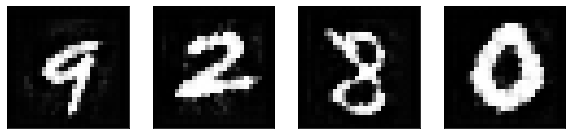

saving...

epoch 73
epoch 73 batch 0 batch total loss 0.0059385933
epoch 73 batch 0 batch cluster loss 2.6597369e-05
epoch 73 batch 0 batch regen loss 0.005911996
saving...



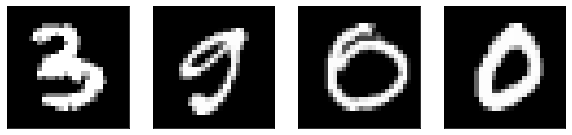

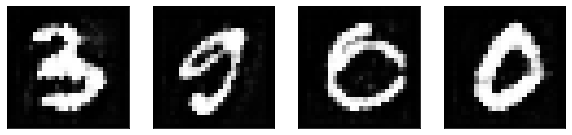

time taken in min: 0.7199997385342916
epoch 73 batch 50 batch total loss 0.0057876403
epoch 73 batch 50 batch cluster loss 2.456195e-05
epoch 73 batch 50 batch regen loss 0.0057630786
saving...



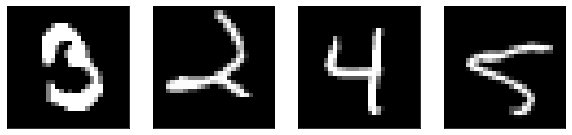

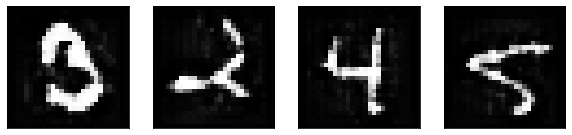

time taken in min: 2.087297821044922
epoch 73 batch 100 batch total loss 0.0059066685
epoch 73 batch 100 batch cluster loss 2.7223577e-05
epoch 73 batch 100 batch regen loss 0.005879445
saving...



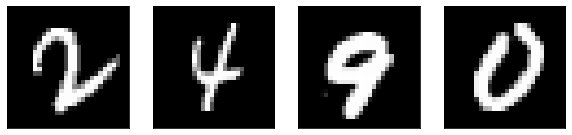

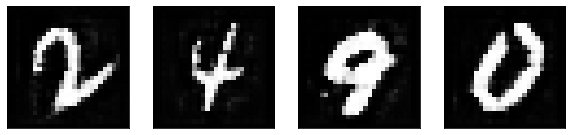

time taken in min: 2.0823751131693524

epoch 73 epoch avg loss 0.0059605433045239265
epoch 73 epoch avg cluster loss 2.5358750755944036e-05
epoch 73 epoch avg regen loss 0.005935184558916648



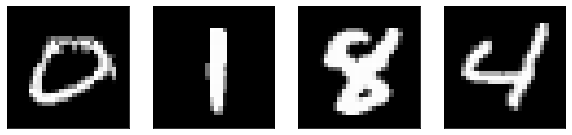

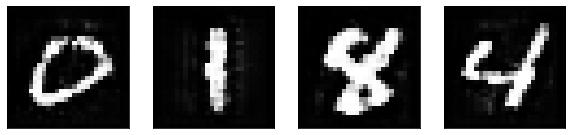

saving...

epoch 74
epoch 74 batch 0 batch total loss 0.006009357
epoch 74 batch 0 batch cluster loss 2.3155639e-05
epoch 74 batch 0 batch regen loss 0.0059862016
saving...



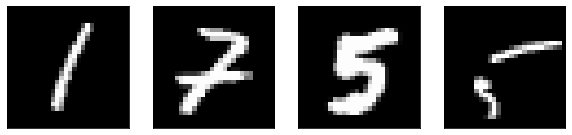

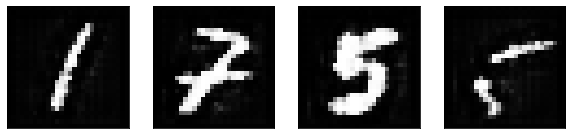

time taken in min: 0.71629745165507
epoch 74 batch 50 batch total loss 0.00602156
epoch 74 batch 50 batch cluster loss 2.5472238e-05
epoch 74 batch 50 batch regen loss 0.005996088
saving...



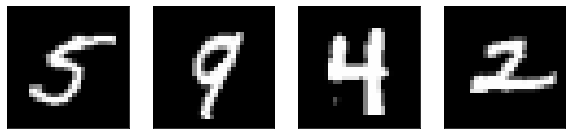

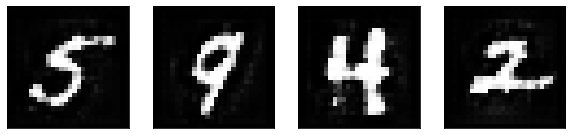

time taken in min: 2.083922572930654
epoch 74 batch 100 batch total loss 0.0060550366
epoch 74 batch 100 batch cluster loss 2.551744e-05
epoch 74 batch 100 batch regen loss 0.0060295193
saving...



time taken in min: 2.0857294758160907

epoch 74 epoch avg loss 0.005952181436626588
epoch 74 epoch avg cluster loss 2.5063522733004086e-05
epoch 74 epoch avg regen loss 0.005927117928168026



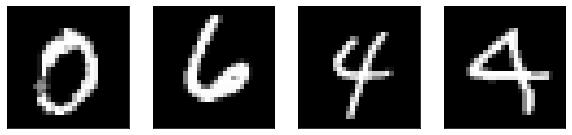

saving...

epoch 75
epoch 75 batch 0 batch total loss 0.0058956794
epoch 75 batch 0 batch cluster loss 2.3585852e-05
epoch 75 batch 0 batch regen loss 0.0058720936
saving...



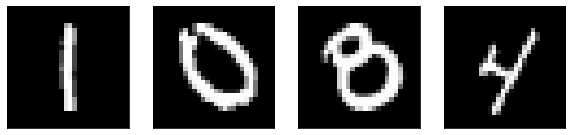

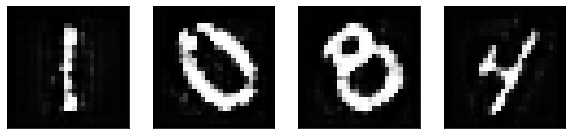

time taken in min: 0.7178492625554402
epoch 75 batch 50 batch total loss 0.0060523734
epoch 75 batch 50 batch cluster loss 2.5568872e-05
epoch 75 batch 50 batch regen loss 0.0060268044
saving...



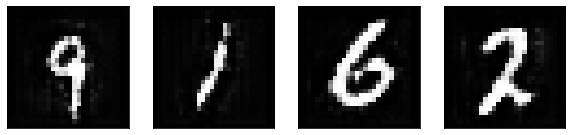

time taken in min: 2.0828474879264833
epoch 75 batch 100 batch total loss 0.0059611434
epoch 75 batch 100 batch cluster loss 2.4540152e-05
epoch 75 batch 100 batch regen loss 0.005936603
saving...



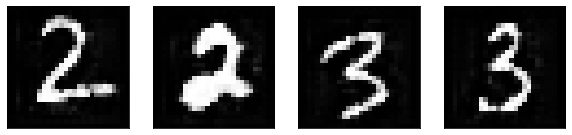

time taken in min: 2.0851122895876566

epoch 75 epoch avg loss 0.005942207212575664
epoch 75 epoch avg cluster loss 2.4685705315185537e-05
epoch 75 epoch avg regen loss 0.00591752150932611



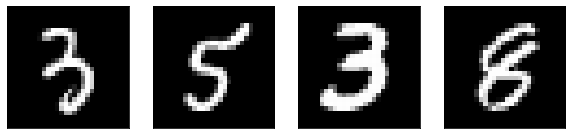

saving...

epoch 76
epoch 76 batch 0 batch total loss 0.0060511455
epoch 76 batch 0 batch cluster loss 2.4946747e-05
epoch 76 batch 0 batch regen loss 0.0060261986
saving...



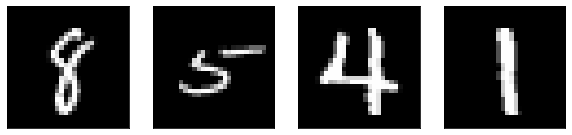

time taken in min: 0.7204895973205566
epoch 76 batch 50 batch total loss 0.005950117
epoch 76 batch 50 batch cluster loss 2.5353014e-05
epoch 76 batch 50 batch regen loss 0.005924764
saving...



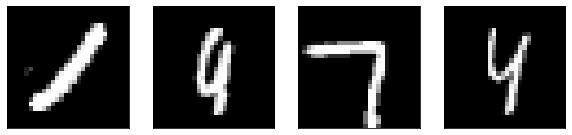

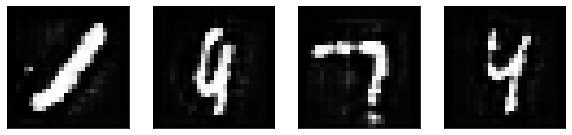

time taken in min: 2.089150083065033
epoch 76 batch 100 batch total loss 0.005823721
epoch 76 batch 100 batch cluster loss 2.2996748e-05
epoch 76 batch 100 batch regen loss 0.0058007245
saving...



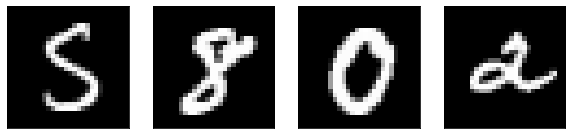

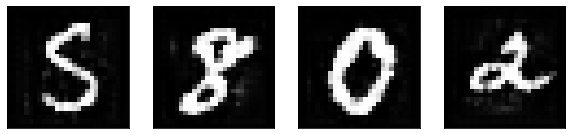

time taken in min: 2.0910006960233054

epoch 76 epoch avg loss 0.005936256665105032
epoch 76 epoch avg cluster loss 2.4403109140837193e-05
epoch 76 epoch avg regen loss 0.005911853555116361



saving...

epoch 77
epoch 77 batch 0 batch total loss 0.0060093906
epoch 77 batch 0 batch cluster loss 2.4862533e-05
epoch 77 batch 0 batch regen loss 0.005984528
saving...



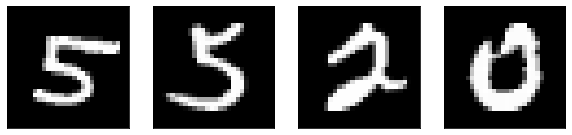

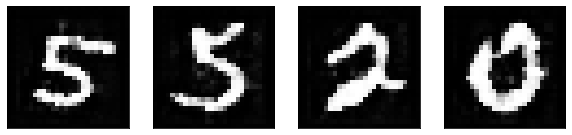

time taken in min: 0.7203107118606568
epoch 77 batch 50 batch total loss 0.0059107775
epoch 77 batch 50 batch cluster loss 2.3938663e-05
epoch 77 batch 50 batch regen loss 0.005886839
saving...



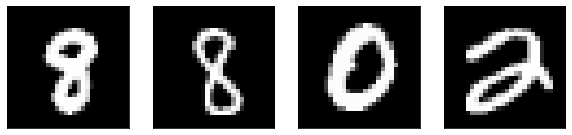

time taken in min: 2.0983731826146443
epoch 77 batch 100 batch total loss 0.00587489
epoch 77 batch 100 batch cluster loss 2.3939978e-05
epoch 77 batch 100 batch regen loss 0.00585095
saving...



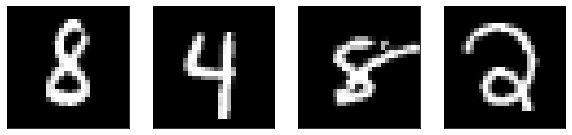

time taken in min: 2.08329926331838

epoch 77 epoch avg loss 0.0059247667017250745
epoch 77 epoch avg cluster loss 2.419830653414434e-05
epoch 77 epoch avg regen loss 0.005900568391938331



saving...

epoch 78
epoch 78 batch 0 batch total loss 0.005849511
epoch 78 batch 0 batch cluster loss 2.3452918e-05
epoch 78 batch 0 batch regen loss 0.005826058
saving...



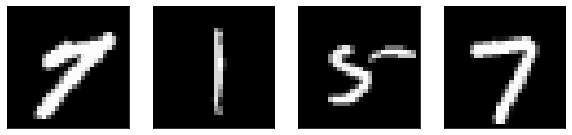

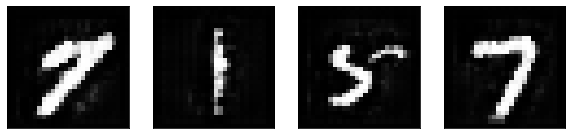

time taken in min: 0.7147374947865804
epoch 78 batch 50 batch total loss 0.005934813
epoch 78 batch 50 batch cluster loss 2.433116e-05
epoch 78 batch 50 batch regen loss 0.005910482
saving...



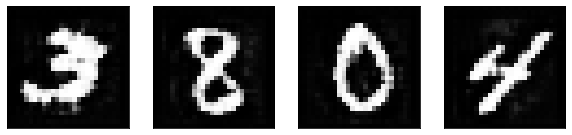

time taken in min: 2.077584179242452
epoch 78 batch 100 batch total loss 0.005875449
epoch 78 batch 100 batch cluster loss 2.3806155e-05
epoch 78 batch 100 batch regen loss 0.005851643
saving...



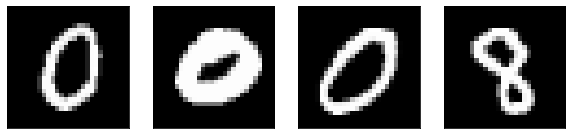

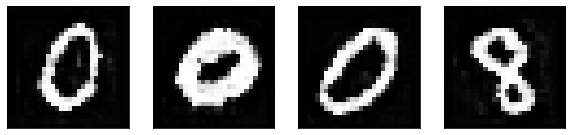

time taken in min: 2.0807227969169615

epoch 78 epoch avg loss 0.005912405371634385
epoch 78 epoch avg cluster loss 2.3892840899707614e-05
epoch 78 epoch avg regen loss 0.0058885125514372425



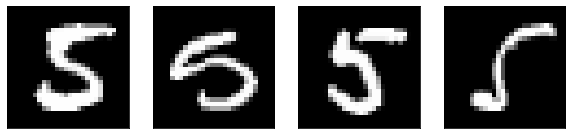

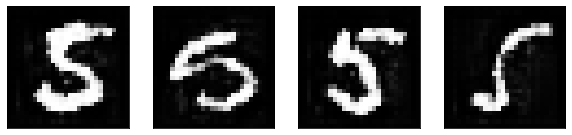

saving...

epoch 79
epoch 79 batch 0 batch total loss 0.00593803
epoch 79 batch 0 batch cluster loss 2.4611649e-05
epoch 79 batch 0 batch regen loss 0.0059134183
saving...



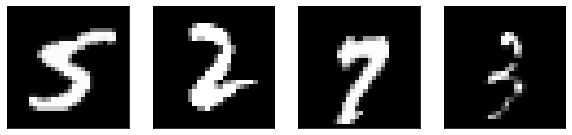

time taken in min: 0.7151277581850688
epoch 79 batch 50 batch total loss 0.005845167
epoch 79 batch 50 batch cluster loss 2.368783e-05
epoch 79 batch 50 batch regen loss 0.0058214795
saving...



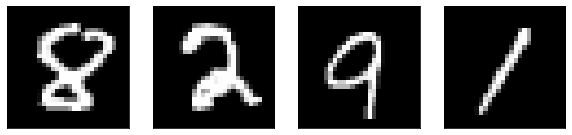

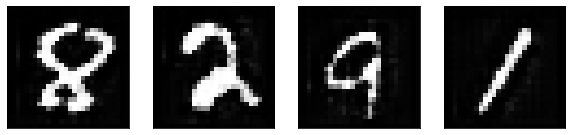

time taken in min: 2.091261637210846
epoch 79 batch 100 batch total loss 0.0058724196
epoch 79 batch 100 batch cluster loss 2.3790955e-05
epoch 79 batch 100 batch regen loss 0.0058486285
saving...



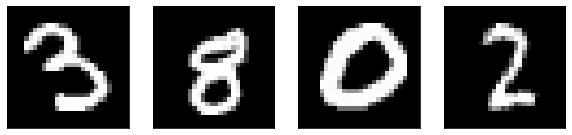

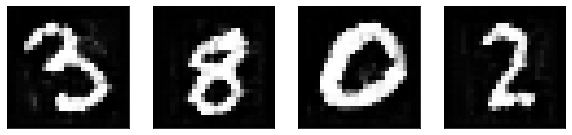

time taken in min: 2.090659972031911

epoch 79 epoch avg loss 0.00590322939363324
epoch 79 epoch avg cluster loss 2.3586426908939573e-05
epoch 79 epoch avg regen loss 0.0058796429667243005



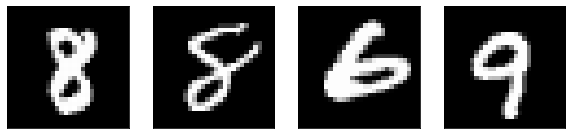

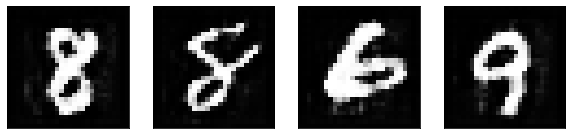

saving...

epoch 80
epoch 80 batch 0 batch total loss 0.0059678936
epoch 80 batch 0 batch cluster loss 2.5820447e-05
epoch 80 batch 0 batch regen loss 0.005942073
saving...



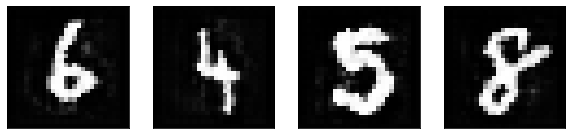

time taken in min: 0.7207038124402364
epoch 80 batch 50 batch total loss 0.005915316
epoch 80 batch 50 batch cluster loss 2.3762996e-05
epoch 80 batch 50 batch regen loss 0.0058915527
saving...



time taken in min: 2.096901766459147
epoch 80 batch 100 batch total loss 0.005765679
epoch 80 batch 100 batch cluster loss 2.2924727e-05
epoch 80 batch 100 batch regen loss 0.0057427543
saving...



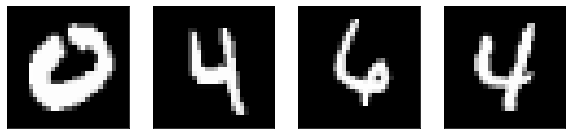

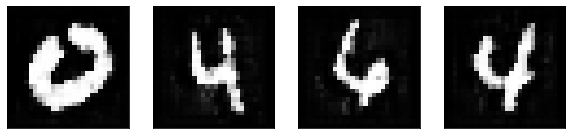

time taken in min: 2.0871421496073403

epoch 80 epoch avg loss 0.005891264664893181
epoch 80 epoch avg cluster loss 2.3210745416305392e-05
epoch 80 epoch avg regen loss 0.005868053931932328



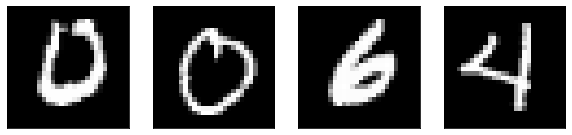

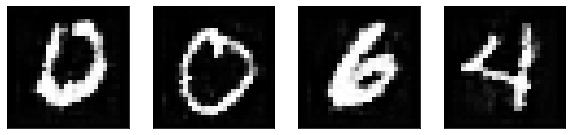

saving...

epoch 81
epoch 81 batch 0 batch total loss 0.005922493
epoch 81 batch 0 batch cluster loss 2.196892e-05
epoch 81 batch 0 batch regen loss 0.005900524
saving...



time taken in min: 0.7167803525924683
epoch 81 batch 50 batch total loss 0.005778663
epoch 81 batch 50 batch cluster loss 2.2701592e-05
epoch 81 batch 50 batch regen loss 0.0057559614
saving...



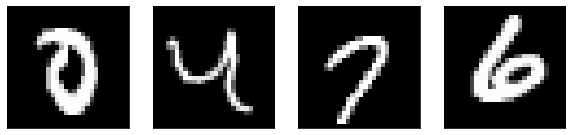

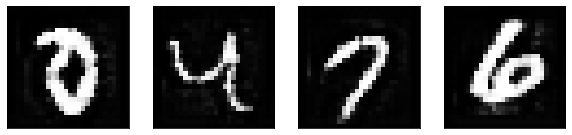

time taken in min: 2.10073504447937
epoch 81 batch 100 batch total loss 0.0059296084
epoch 81 batch 100 batch cluster loss 2.3010603e-05
epoch 81 batch 100 batch regen loss 0.0059065977
saving...



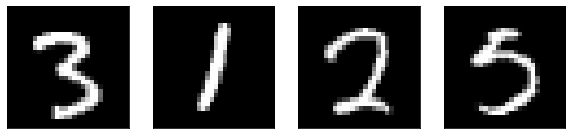

time taken in min: 2.1006423195203143

epoch 81 epoch avg loss 0.005884323284913928
epoch 81 epoch avg cluster loss 2.2977247018558447e-05
epoch 81 epoch avg regen loss 0.0058613460455721215



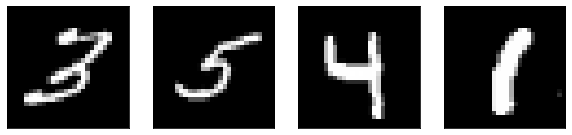

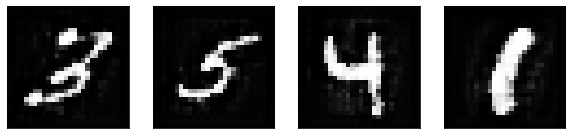

saving...

epoch 82
epoch 82 batch 0 batch total loss 0.0058227214
epoch 82 batch 0 batch cluster loss 2.31816e-05
epoch 82 batch 0 batch regen loss 0.00579954
saving...



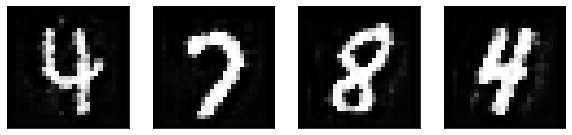

time taken in min: 0.7225992918014527
epoch 82 batch 50 batch total loss 0.005811829
epoch 82 batch 50 batch cluster loss 2.2606102e-05
epoch 82 batch 50 batch regen loss 0.005789223
saving...



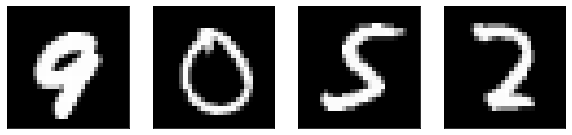

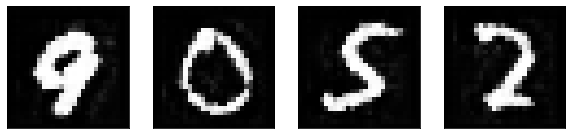

time taken in min: 2.094324239095052
epoch 82 batch 100 batch total loss 0.0058003035
epoch 82 batch 100 batch cluster loss 2.2380354e-05
epoch 82 batch 100 batch regen loss 0.0057779234
saving...



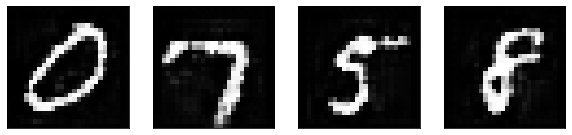

time taken in min: 2.0957602739334105

epoch 82 epoch avg loss 0.0058741548919450425
epoch 82 epoch avg cluster loss 2.2786228898547637e-05
epoch 82 epoch avg regen loss 0.005851368668441803



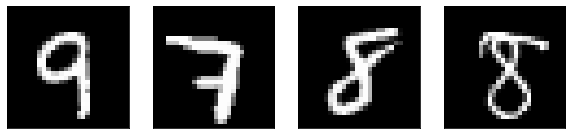

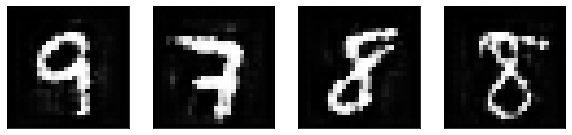

saving...

epoch 83
epoch 83 batch 0 batch total loss 0.005857122
epoch 83 batch 0 batch cluster loss 2.161983e-05
epoch 83 batch 0 batch regen loss 0.0058355024
saving...



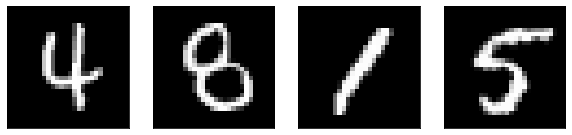

time taken in min: 0.7189357360204061
epoch 83 batch 50 batch total loss 0.0058962875
epoch 83 batch 50 batch cluster loss 2.2531147e-05
epoch 83 batch 50 batch regen loss 0.0058737565
saving...



time taken in min: 2.095315949122111
epoch 83 batch 100 batch total loss 0.0059779165
epoch 83 batch 100 batch cluster loss 2.2053735e-05
epoch 83 batch 100 batch regen loss 0.005955863
saving...



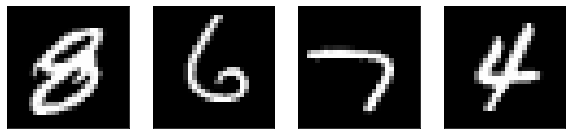

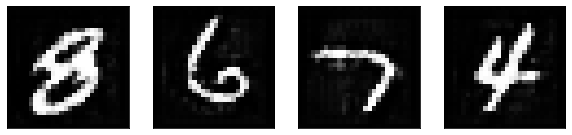

time taken in min: 2.0968872785568236

epoch 83 epoch avg loss 0.005865009923828608
epoch 83 epoch avg cluster loss 2.2423285156684746e-05
epoch 83 epoch avg regen loss 0.005842586624104593



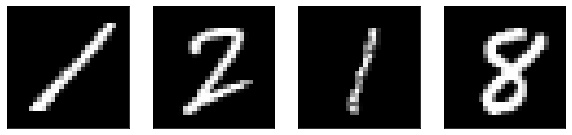

saving...

epoch 84
epoch 84 batch 0 batch total loss 0.0060244636
epoch 84 batch 0 batch cluster loss 2.3023018e-05
epoch 84 batch 0 batch regen loss 0.0060014403
saving...



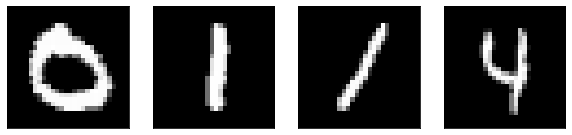

time taken in min: 0.7179609100023906
epoch 84 batch 50 batch total loss 0.0059176236
epoch 84 batch 50 batch cluster loss 2.2652352e-05
epoch 84 batch 50 batch regen loss 0.005894971
saving...



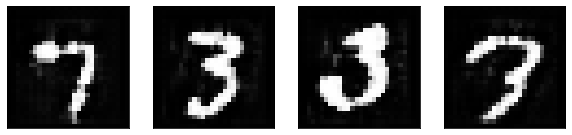

time taken in min: 2.0901957114537555
epoch 84 batch 100 batch total loss 0.0058565713
epoch 84 batch 100 batch cluster loss 2.0759378e-05
epoch 84 batch 100 batch regen loss 0.005835812
saving...



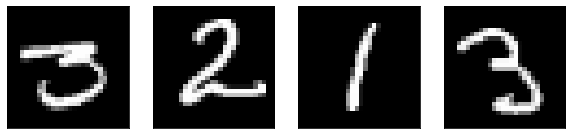

time taken in min: 2.093161714076996

epoch 84 epoch avg loss 0.005855632077713134
epoch 84 epoch avg cluster loss 2.21556870432539e-05
epoch 84 epoch avg regen loss 0.005833476375378037



saving...

epoch 85
epoch 85 batch 0 batch total loss 0.0057778233
epoch 85 batch 0 batch cluster loss 2.2294631e-05
epoch 85 batch 0 batch regen loss 0.005755529
saving...



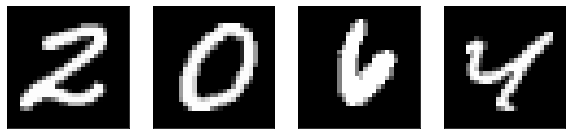

time taken in min: 0.7221346577008565
epoch 85 batch 50 batch total loss 0.005870971
epoch 85 batch 50 batch cluster loss 2.1520786e-05
epoch 85 batch 50 batch regen loss 0.00584945
saving...



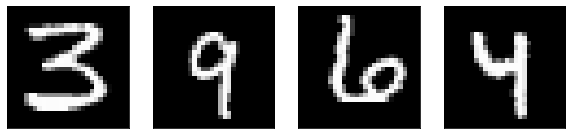

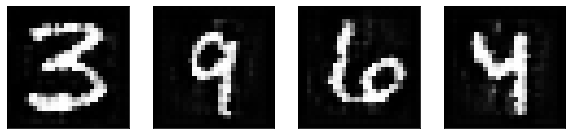

time taken in min: 2.084523304303487
epoch 85 batch 100 batch total loss 0.005813784
epoch 85 batch 100 batch cluster loss 2.163586e-05
epoch 85 batch 100 batch regen loss 0.005792148
saving...



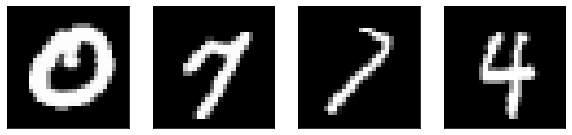

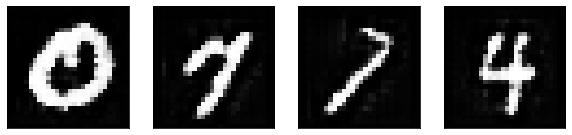

time taken in min: 2.09651403427124

epoch 85 epoch avg loss 0.005844232136920347
epoch 85 epoch avg cluster loss 2.2037520990371547e-05
epoch 85 epoch avg regen loss 0.005822194602056328



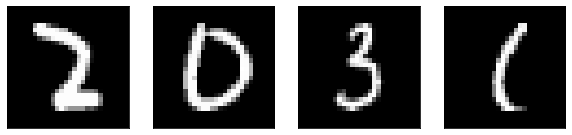

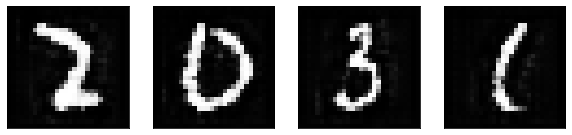

saving...

epoch 86
epoch 86 batch 0 batch total loss 0.0057606613
epoch 86 batch 0 batch cluster loss 2.1337713e-05
epoch 86 batch 0 batch regen loss 0.005739324
saving...



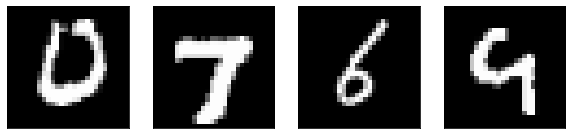

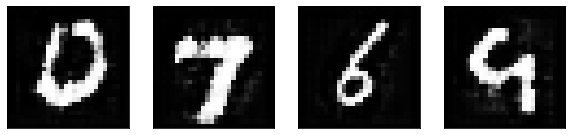

time taken in min: 0.7193769256273905
epoch 86 batch 50 batch total loss 0.0058667124
epoch 86 batch 50 batch cluster loss 2.1298161e-05
epoch 86 batch 50 batch regen loss 0.0058454145
saving...



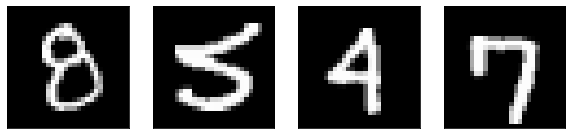

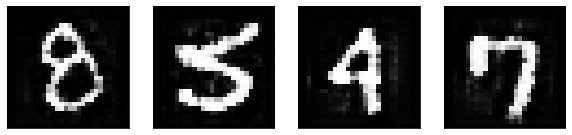

time taken in min: 2.084995432694753
epoch 86 batch 100 batch total loss 0.005860718
epoch 86 batch 100 batch cluster loss 2.1818247e-05
epoch 86 batch 100 batch regen loss 0.0058389
saving...



time taken in min: 2.0893182595570883

epoch 86 epoch avg loss 0.005837468604036307
epoch 86 epoch avg cluster loss 2.168768938737862e-05
epoch 86 epoch avg regen loss 0.005815780926811493



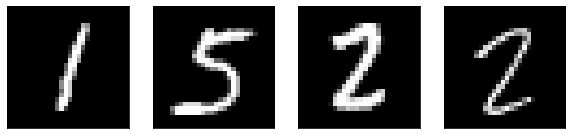

saving...

epoch 87
epoch 87 batch 0 batch total loss 0.0058264975
epoch 87 batch 0 batch cluster loss 2.2226479e-05
epoch 87 batch 0 batch regen loss 0.005804271
saving...



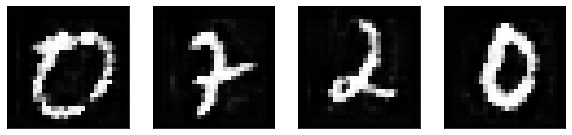

time taken in min: 0.7218023697535197
epoch 87 batch 50 batch total loss 0.005903662
epoch 87 batch 50 batch cluster loss 2.1436284e-05
epoch 87 batch 50 batch regen loss 0.005882226
saving...



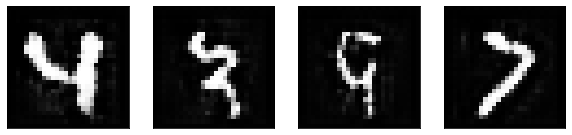

time taken in min: 2.0909241437911987
epoch 87 batch 100 batch total loss 0.005944061
epoch 87 batch 100 batch cluster loss 2.035994e-05
epoch 87 batch 100 batch regen loss 0.005923701
saving...



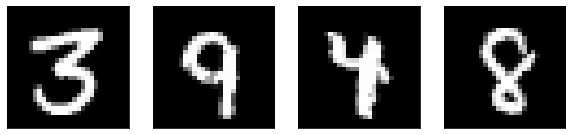

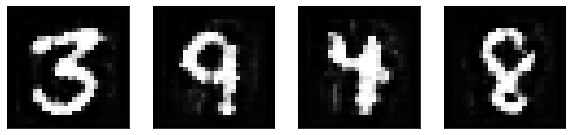

time taken in min: 2.0945643822352094

epoch 87 epoch avg loss 0.005829726554990067
epoch 87 epoch avg cluster loss 2.1558134903898463e-05
epoch 87 epoch avg regen loss 0.005808168418421331



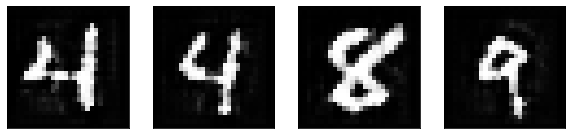

saving...

epoch 88
epoch 88 batch 0 batch total loss 0.0059477775
epoch 88 batch 0 batch cluster loss 2.1150703e-05
epoch 88 batch 0 batch regen loss 0.0059266267
saving...



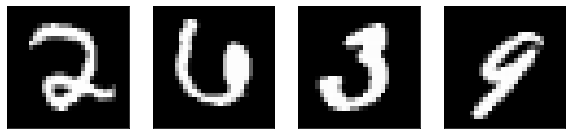

time taken in min: 0.7223117192586263
epoch 88 batch 50 batch total loss 0.005870416
epoch 88 batch 50 batch cluster loss 2.0227311e-05
epoch 88 batch 50 batch regen loss 0.0058501884
saving...



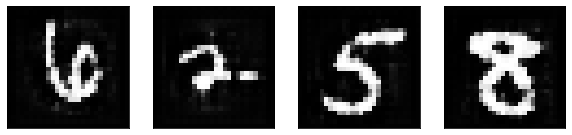

time taken in min: 2.085412355264028
epoch 88 batch 100 batch total loss 0.0059075295
epoch 88 batch 100 batch cluster loss 2.1029438e-05
epoch 88 batch 100 batch regen loss 0.0058865002
saving...



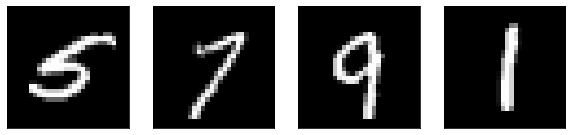

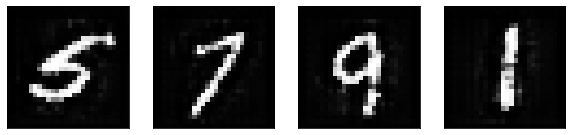

time taken in min: 2.0862862785657246

epoch 88 epoch avg loss 0.005819573122376608
epoch 88 epoch avg cluster loss 2.1284649739169194e-05
epoch 88 epoch avg regen loss 0.00579828845921083



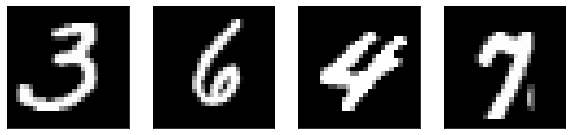

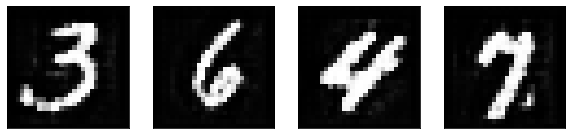

saving...

epoch 89
epoch 89 batch 0 batch total loss 0.0058811307
epoch 89 batch 0 batch cluster loss 2.1283975e-05
epoch 89 batch 0 batch regen loss 0.0058598467
saving...



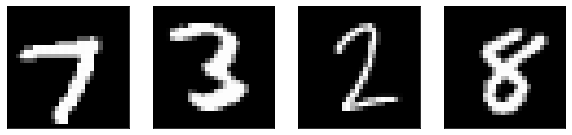

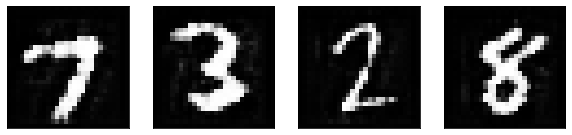

time taken in min: 0.7172195553779602
epoch 89 batch 50 batch total loss 0.00591535
epoch 89 batch 50 batch cluster loss 2.1112324e-05
epoch 89 batch 50 batch regen loss 0.0058942377
saving...



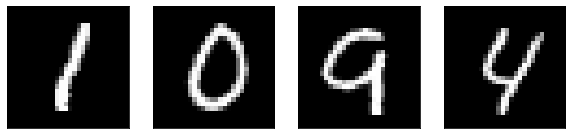

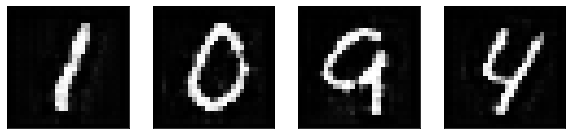

time taken in min: 2.088946239153544
epoch 89 batch 100 batch total loss 0.0057676597
epoch 89 batch 100 batch cluster loss 2.0842574e-05
epoch 89 batch 100 batch regen loss 0.005746817
saving...



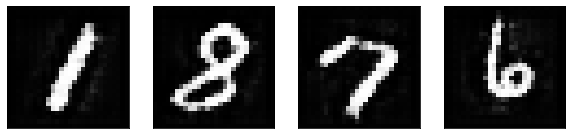

time taken in min: 2.0952132900555926

epoch 89 epoch avg loss 0.005809840174013023
epoch 89 epoch avg cluster loss 2.107598009974088e-05
epoch 89 epoch avg regen loss 0.005788764198137037



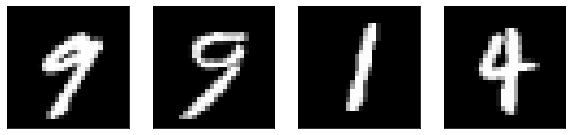

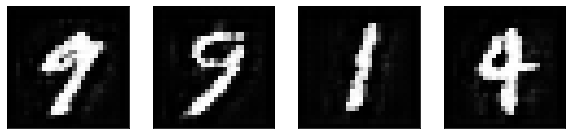

saving...

epoch 90
epoch 90 batch 0 batch total loss 0.005759953
epoch 90 batch 0 batch cluster loss 2.0404119e-05
epoch 90 batch 0 batch regen loss 0.0057395487
saving...



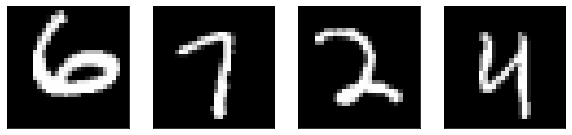

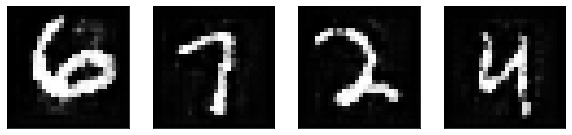

time taken in min: 0.7228400468826294
epoch 90 batch 50 batch total loss 0.005958394
epoch 90 batch 50 batch cluster loss 2.0902142e-05
epoch 90 batch 50 batch regen loss 0.005937492
saving...



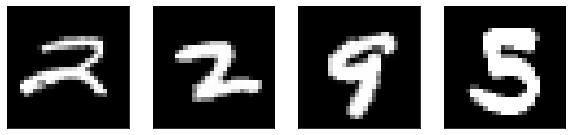

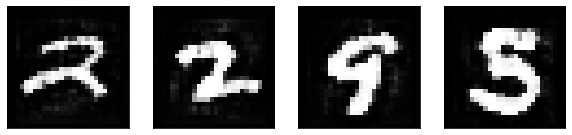

time taken in min: 2.0995370388031005
epoch 90 batch 100 batch total loss 0.0057882974
epoch 90 batch 100 batch cluster loss 2.1301195e-05
epoch 90 batch 100 batch regen loss 0.005766996
saving...



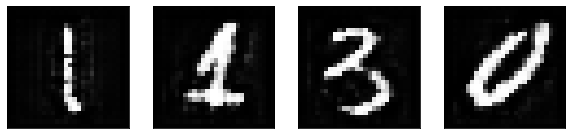

time taken in min: 2.0945513407389322

epoch 90 epoch avg loss 0.005801704088699514
epoch 90 epoch avg cluster loss 2.0778150382423104e-05
epoch 90 epoch avg regen loss 0.00578092591900189



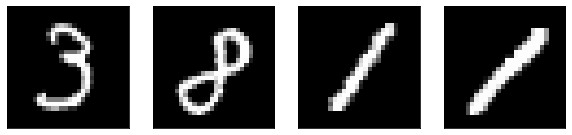

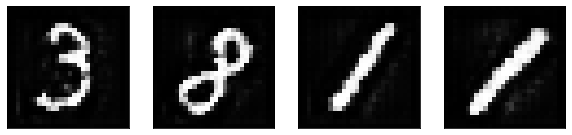

saving...

epoch 91
epoch 91 batch 0 batch total loss 0.005824479
epoch 91 batch 0 batch cluster loss 2.0302681e-05
epoch 91 batch 0 batch regen loss 0.005804176
saving...



time taken in min: 0.7261937419573467
epoch 91 batch 50 batch total loss 0.005722043
epoch 91 batch 50 batch cluster loss 2.0065978e-05
epoch 91 batch 50 batch regen loss 0.0057019773
saving...



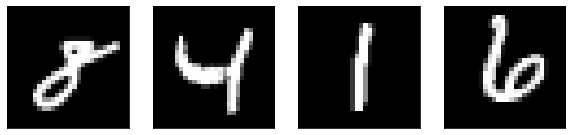

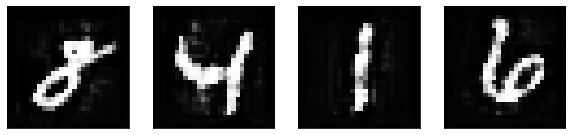

time taken in min: 2.1021077632904053
epoch 91 batch 100 batch total loss 0.005952519
epoch 91 batch 100 batch cluster loss 2.0646357e-05
epoch 91 batch 100 batch regen loss 0.0059318724
saving...



time taken in min: 2.0987922310829163

epoch 91 epoch avg loss 0.00579559776174315
epoch 91 epoch avg cluster loss 2.062136322280621e-05
epoch 91 epoch avg regen loss 0.005774976393618321



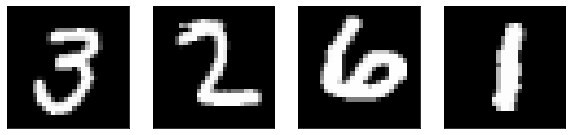

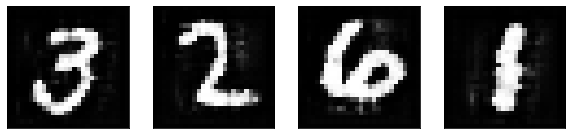

saving...

epoch 92
epoch 92 batch 0 batch total loss 0.00591848
epoch 92 batch 0 batch cluster loss 2.1201931e-05
epoch 92 batch 0 batch regen loss 0.005897278
saving...



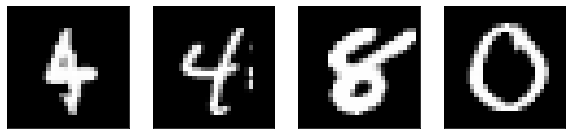

time taken in min: 0.7209494868914287
epoch 92 batch 50 batch total loss 0.0057778554
epoch 92 batch 50 batch cluster loss 1.8858676e-05
epoch 92 batch 50 batch regen loss 0.0057589966
saving...



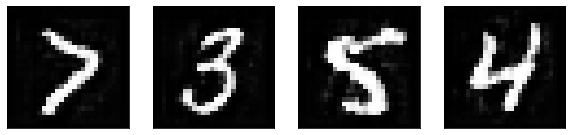

time taken in min: 2.10037678082784
epoch 92 batch 100 batch total loss 0.0056772484
epoch 92 batch 100 batch cluster loss 2.09484e-05
epoch 92 batch 100 batch regen loss 0.0056563
saving...



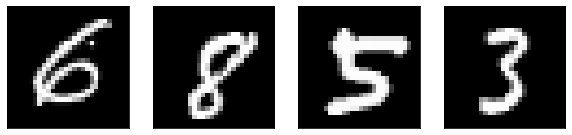

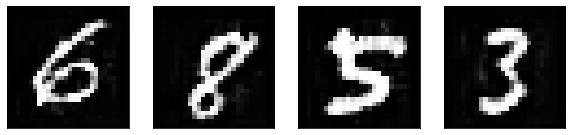

time taken in min: 2.098626927534739

epoch 92 epoch avg loss 0.005786073666413204
epoch 92 epoch avg cluster loss 2.0381044154326724e-05
epoch 92 epoch avg regen loss 0.005765692622921729



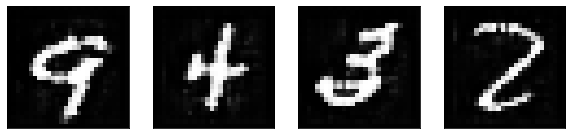

saving...

epoch 93
epoch 93 batch 0 batch total loss 0.005821937
epoch 93 batch 0 batch cluster loss 1.9523493e-05
epoch 93 batch 0 batch regen loss 0.005802414
saving...



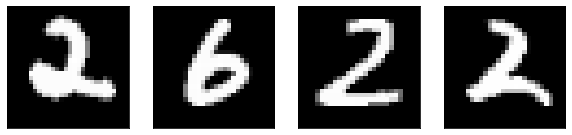

time taken in min: 0.7277622818946838
epoch 93 batch 50 batch total loss 0.0058001173
epoch 93 batch 50 batch cluster loss 2.0437254e-05
epoch 93 batch 50 batch regen loss 0.00577968
saving...



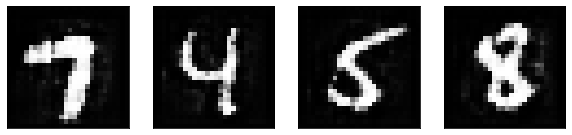

time taken in min: 2.0935442209243775
epoch 93 batch 100 batch total loss 0.0057902057
epoch 93 batch 100 batch cluster loss 2.0517273e-05
epoch 93 batch 100 batch regen loss 0.005769688
saving...



time taken in min: 2.08726198275884

epoch 93 epoch avg loss 0.005780555335489117
epoch 93 epoch avg cluster loss 2.0281092752233914e-05
epoch 93 epoch avg regen loss 0.00576027423159172



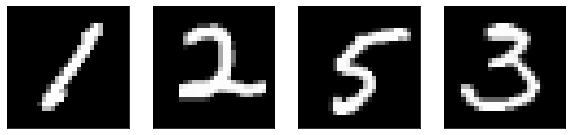

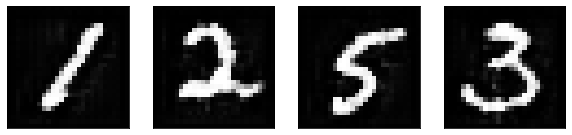

saving...

epoch 94
epoch 94 batch 0 batch total loss 0.0058691837
epoch 94 batch 0 batch cluster loss 1.9866206e-05
epoch 94 batch 0 batch regen loss 0.0058493176
saving...



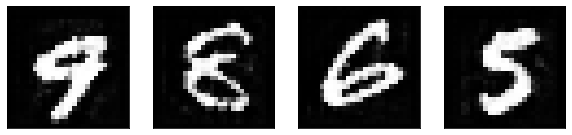

time taken in min: 0.7145751714706421
epoch 94 batch 50 batch total loss 0.005776851
epoch 94 batch 50 batch cluster loss 2.100154e-05
epoch 94 batch 50 batch regen loss 0.0057558496
saving...



time taken in min: 2.088084840774536
epoch 94 batch 100 batch total loss 0.005793237
epoch 94 batch 100 batch cluster loss 1.9497196e-05
epoch 94 batch 100 batch regen loss 0.00577374
saving...



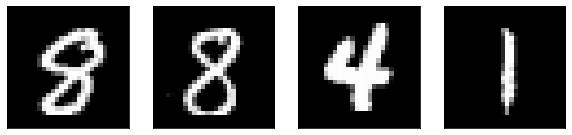

time taken in min: 2.091947869459788

epoch 94 epoch avg loss 0.005770602476609461
epoch 94 epoch avg cluster loss 2.0083212170979774e-05
epoch 94 epoch avg regen loss 0.005750519251135193



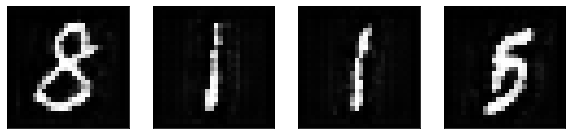

saving...

epoch 95
epoch 95 batch 0 batch total loss 0.005911574
epoch 95 batch 0 batch cluster loss 1.9255716e-05
epoch 95 batch 0 batch regen loss 0.005892318
saving...



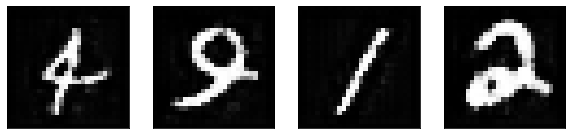

time taken in min: 0.7196856419245402
epoch 95 batch 50 batch total loss 0.0057798238
epoch 95 batch 50 batch cluster loss 1.9543459e-05
epoch 95 batch 50 batch regen loss 0.0057602804
saving...



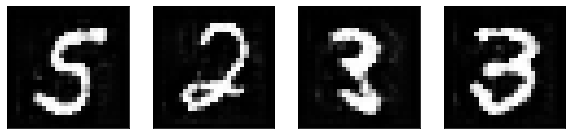

time taken in min: 2.086333990097046
epoch 95 batch 100 batch total loss 0.0057843695
epoch 95 batch 100 batch cluster loss 1.9741958e-05
epoch 95 batch 100 batch regen loss 0.0057646274
saving...



time taken in min: 2.0830036282539366

epoch 95 epoch avg loss 0.005761474453828345
epoch 95 epoch avg cluster loss 1.9824118804165865e-05
epoch 95 epoch avg regen loss 0.005741650337290208



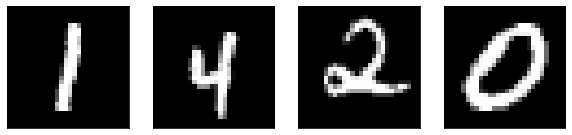

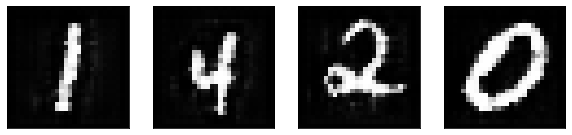

saving...

epoch 96
epoch 96 batch 0 batch total loss 0.0057123094
epoch 96 batch 0 batch cluster loss 1.9377863e-05
epoch 96 batch 0 batch regen loss 0.0056929314
saving...



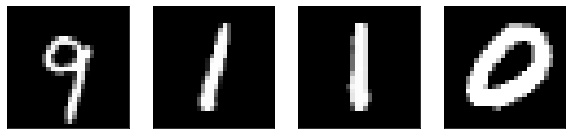

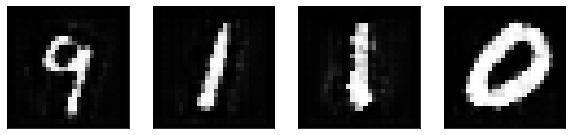

time taken in min: 0.7183131059010823
epoch 96 batch 50 batch total loss 0.0059193126
epoch 96 batch 50 batch cluster loss 1.9438237e-05
epoch 96 batch 50 batch regen loss 0.0058998745
saving...



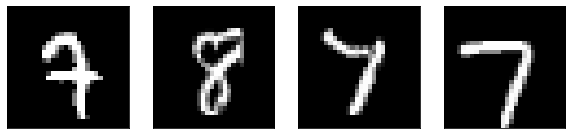

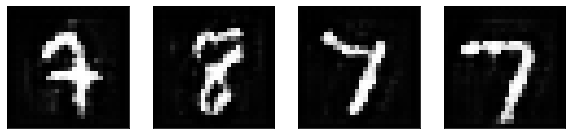

time taken in min: 2.0860060652097068
epoch 96 batch 100 batch total loss 0.005648965
epoch 96 batch 100 batch cluster loss 1.9697634e-05
epoch 96 batch 100 batch regen loss 0.0056292675
saving...



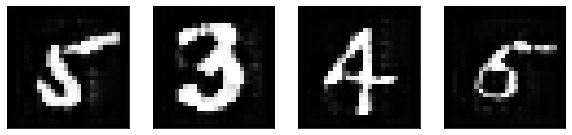

time taken in min: 2.0927267630894977

epoch 96 epoch avg loss 0.005756296971181439
epoch 96 epoch avg cluster loss 1.9606775729976184e-05
epoch 96 epoch avg regen loss 0.0057366901961297305



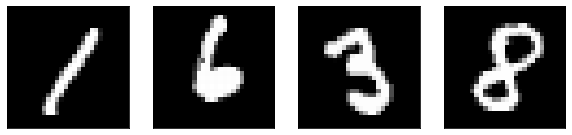

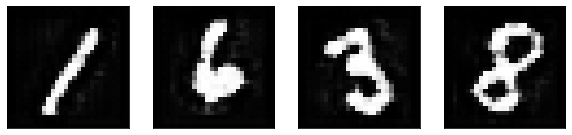

saving...

epoch 97
epoch 97 batch 0 batch total loss 0.005713019
epoch 97 batch 0 batch cluster loss 2.1499678e-05
epoch 97 batch 0 batch regen loss 0.0056915195
saving...



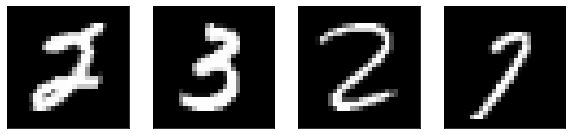

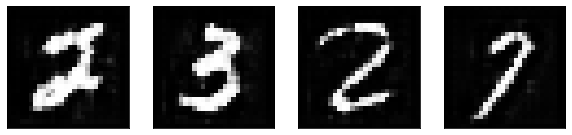

time taken in min: 0.7241481026013692
epoch 97 batch 50 batch total loss 0.00570261
epoch 97 batch 50 batch cluster loss 1.8948618e-05
epoch 97 batch 50 batch regen loss 0.0056836614
saving...



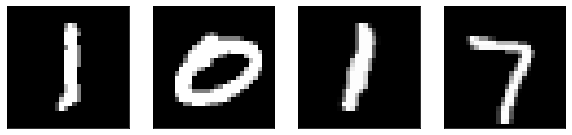

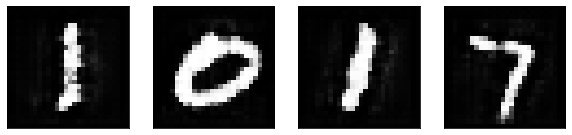

time taken in min: 2.0916725794474282
epoch 97 batch 100 batch total loss 0.005736704
epoch 97 batch 100 batch cluster loss 1.8883102e-05
epoch 97 batch 100 batch regen loss 0.005717821
saving...



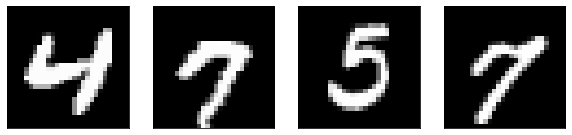

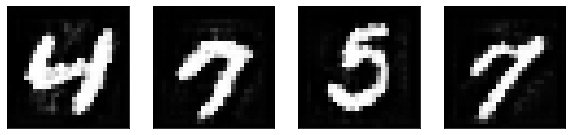

time taken in min: 2.0892732898394266

epoch 97 epoch avg loss 0.005746465302624945
epoch 97 epoch avg cluster loss 1.9506063543272924e-05
epoch 97 epoch avg regen loss 0.005726959240638604



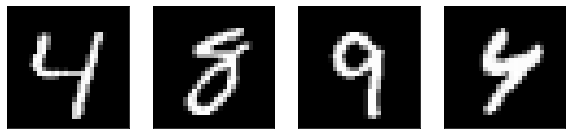

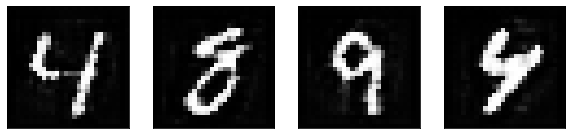

saving...

epoch 98
epoch 98 batch 0 batch total loss 0.005790974
epoch 98 batch 0 batch cluster loss 2.000482e-05
epoch 98 batch 0 batch regen loss 0.005770969
saving...



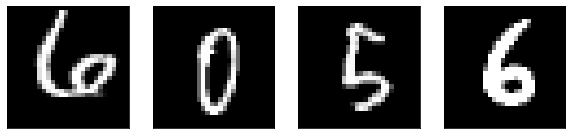

time taken in min: 0.7183873216311137
epoch 98 batch 50 batch total loss 0.005787228
epoch 98 batch 50 batch cluster loss 1.9171068e-05
epoch 98 batch 50 batch regen loss 0.0057680565
saving...



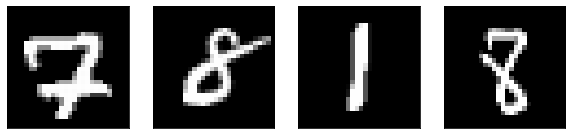

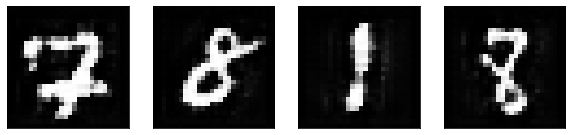

time taken in min: 2.0875967144966125
epoch 98 batch 100 batch total loss 0.005638156
epoch 98 batch 100 batch cluster loss 1.8957026e-05
epoch 98 batch 100 batch regen loss 0.005619199
saving...



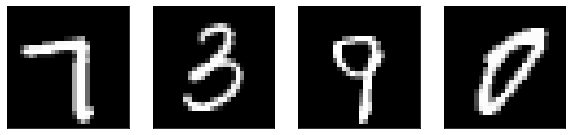

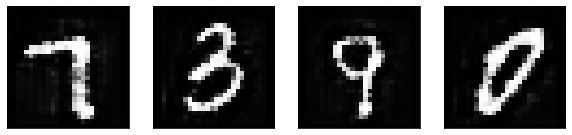

time taken in min: 2.0879242420196533

epoch 98 epoch avg loss 0.005736776465802627
epoch 98 epoch avg cluster loss 1.922309772869655e-05
epoch 98 epoch avg regen loss 0.005717553360135121



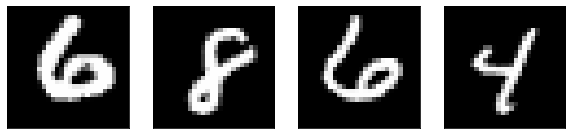

saving...

epoch 99
epoch 99 batch 0 batch total loss 0.0056111915
epoch 99 batch 0 batch cluster loss 1.838933e-05
epoch 99 batch 0 batch regen loss 0.005592802
saving...



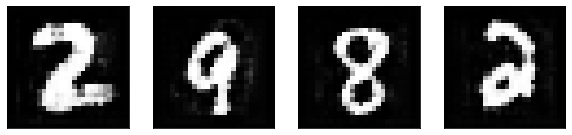

time taken in min: 0.7222540020942688
epoch 99 batch 50 batch total loss 0.0056745755
epoch 99 batch 50 batch cluster loss 1.886524e-05
epoch 99 batch 50 batch regen loss 0.00565571
saving...



time taken in min: 2.083700505892436
epoch 99 batch 100 batch total loss 0.0053921835
epoch 99 batch 100 batch cluster loss 1.9607438e-05
epoch 99 batch 100 batch regen loss 0.005372576
saving...



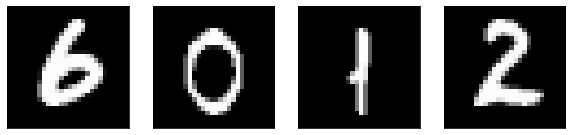

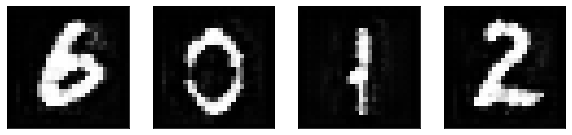

time taken in min: 2.083077847957611

epoch 99 epoch avg loss 0.005728690068126987
epoch 99 epoch avg cluster loss 1.913201582684158e-05
epoch 99 epoch avg regen loss 0.0057095580584353815



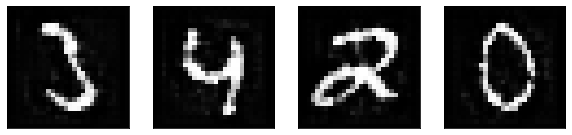

saving...

epoch 100
epoch 100 batch 0 batch total loss 0.005840126
epoch 100 batch 0 batch cluster loss 1.9527923e-05
epoch 100 batch 0 batch regen loss 0.005820598
saving...



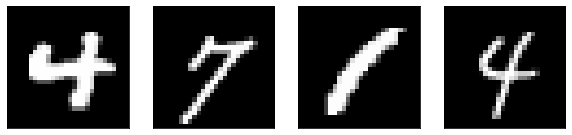

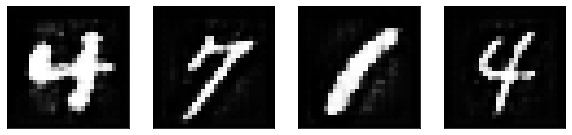

time taken in min: 0.7176158428192139
epoch 100 batch 50 batch total loss 0.0056382576
epoch 100 batch 50 batch cluster loss 1.9474304e-05
epoch 100 batch 50 batch regen loss 0.005618783
saving...



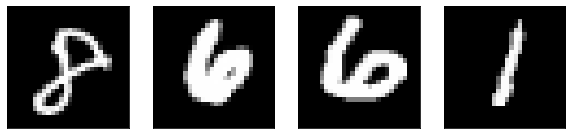

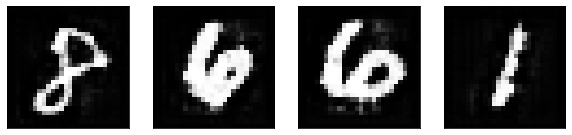

time taken in min: 2.088490315278371
epoch 100 batch 100 batch total loss 0.005626992
epoch 100 batch 100 batch cluster loss 1.925867e-05
epoch 100 batch 100 batch regen loss 0.005607733
saving...



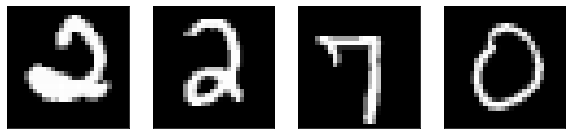

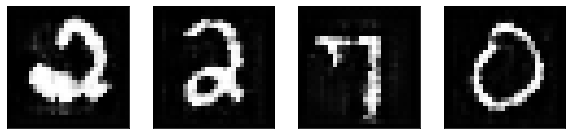

time taken in min: 2.089429493745168

epoch 100 epoch avg loss 0.0057208399698769645
epoch 100 epoch avg cluster loss 1.8830116182394025e-05
epoch 100 epoch avg regen loss 0.005702009858658253



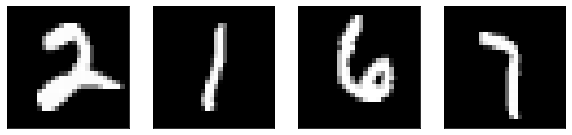

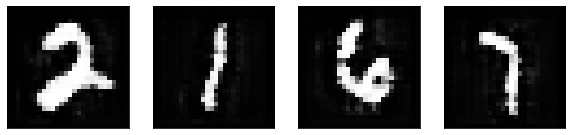

saving...

epoch 101
epoch 101 batch 0 batch total loss 0.0057426477
epoch 101 batch 0 batch cluster loss 1.929482e-05
epoch 101 batch 0 batch regen loss 0.005723353
saving...



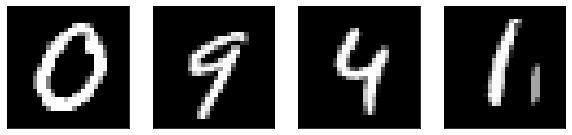

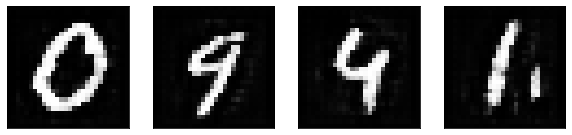

time taken in min: 0.7208422422409058
epoch 101 batch 50 batch total loss 0.0056518065
epoch 101 batch 50 batch cluster loss 1.9002258e-05
epoch 101 batch 50 batch regen loss 0.0056328042
saving...



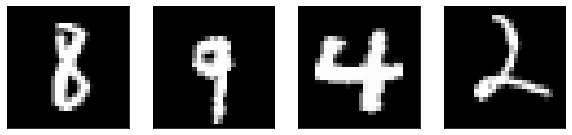

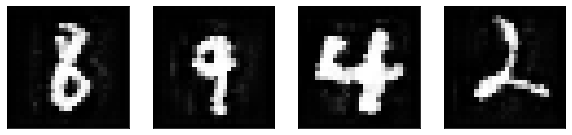

time taken in min: 2.092568242549896
epoch 101 batch 100 batch total loss 0.0055935043
epoch 101 batch 100 batch cluster loss 1.7507222e-05
epoch 101 batch 100 batch regen loss 0.0055759973
saving...



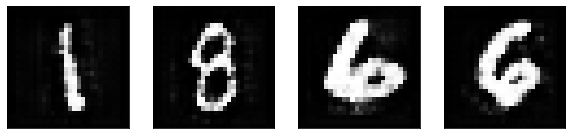

time taken in min: 2.0982210795084635

epoch 101 epoch avg loss 0.005716084936728417
epoch 101 epoch avg cluster loss 1.8659427396260532e-05
epoch 101 epoch avg regen loss 0.005697425514049196



saving...

epoch 102
epoch 102 batch 0 batch total loss 0.0056832237
epoch 102 batch 0 batch cluster loss 1.8492825e-05
epoch 102 batch 0 batch regen loss 0.005664731
saving...



time taken in min: 0.7192905147870382
epoch 102 batch 50 batch total loss 0.0057939473
epoch 102 batch 50 batch cluster loss 1.7242028e-05
epoch 102 batch 50 batch regen loss 0.005776705
saving...



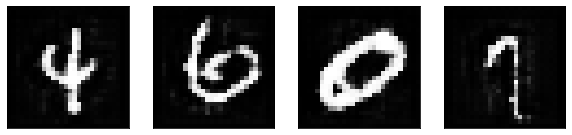

time taken in min: 2.0864813248316447
epoch 102 batch 100 batch total loss 0.0057411143
epoch 102 batch 100 batch cluster loss 1.7929087e-05
epoch 102 batch 100 batch regen loss 0.0057231854
saving...



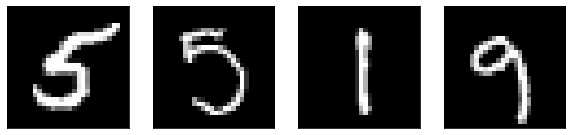

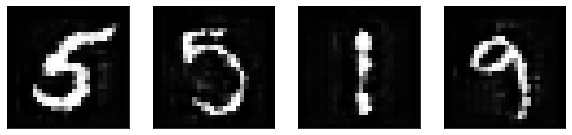

time taken in min: 2.086522134145101

epoch 102 epoch avg loss 0.005707489117443309
epoch 102 epoch avg cluster loss 1.8451155791793145e-05
epoch 102 epoch avg regen loss 0.005689037963747978



saving...

epoch 103
epoch 103 batch 0 batch total loss 0.005657003
epoch 103 batch 0 batch cluster loss 1.717459e-05
epoch 103 batch 0 batch regen loss 0.0056398283
saving...



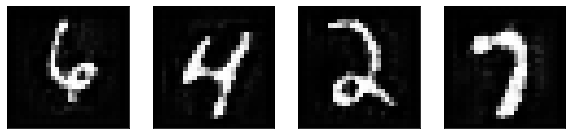

time taken in min: 0.7201764305432637
epoch 103 batch 50 batch total loss 0.0058579645
epoch 103 batch 50 batch cluster loss 1.8121615e-05
epoch 103 batch 50 batch regen loss 0.005839843
saving...



time taken in min: 2.090339386463165
epoch 103 batch 100 batch total loss 0.0054895515
epoch 103 batch 100 batch cluster loss 1.7764654e-05
epoch 103 batch 100 batch regen loss 0.005471787
saving...



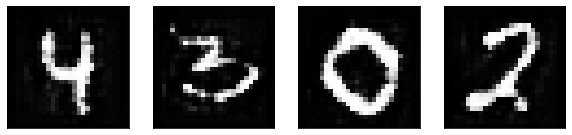

time taken in min: 2.0909181435902915

epoch 103 epoch avg loss 0.005698306387353499
epoch 103 epoch avg cluster loss 1.8342417761386507e-05
epoch 103 epoch avg regen loss 0.005679963957676191



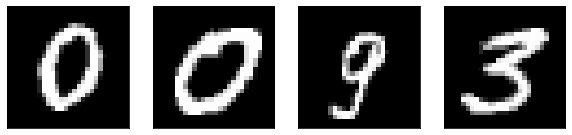

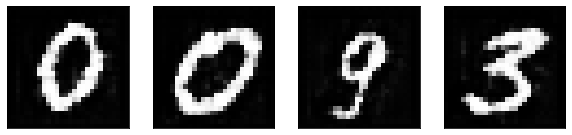

saving...

epoch 104
epoch 104 batch 0 batch total loss 0.0057448903
epoch 104 batch 0 batch cluster loss 1.7993736e-05
epoch 104 batch 0 batch regen loss 0.0057268967
saving...



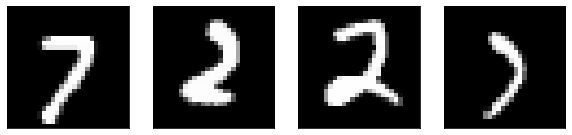

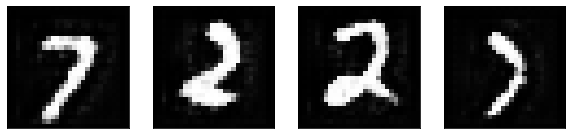

time taken in min: 0.7210113286972046
epoch 104 batch 50 batch total loss 0.0057618064
epoch 104 batch 50 batch cluster loss 1.7261635e-05
epoch 104 batch 50 batch regen loss 0.005744545
saving...



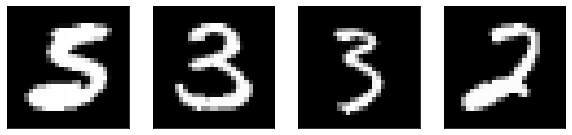

time taken in min: 2.0903112332026166
epoch 104 batch 100 batch total loss 0.0057415524
epoch 104 batch 100 batch cluster loss 1.809921e-05
epoch 104 batch 100 batch regen loss 0.005723453
saving...



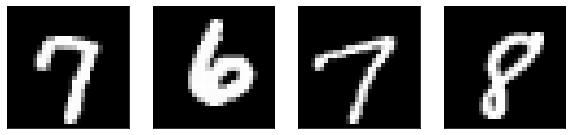

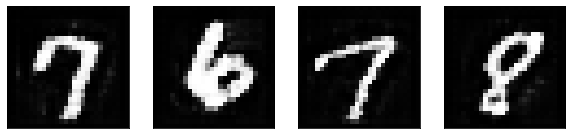

time taken in min: 2.083626667658488

epoch 104 epoch avg loss 0.005690069478478724
epoch 104 epoch avg cluster loss 1.8150086053553376e-05
epoch 104 epoch avg regen loss 0.005671919406375895



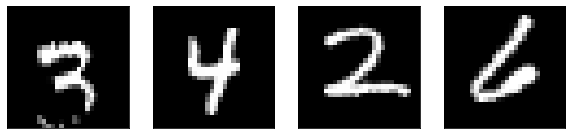

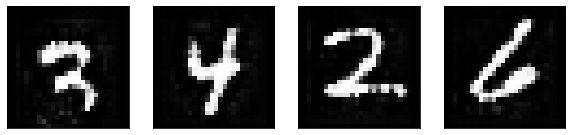

saving...

epoch 105
epoch 105 batch 0 batch total loss 0.0056967787
epoch 105 batch 0 batch cluster loss 1.8920773e-05
epoch 105 batch 0 batch regen loss 0.005677858
saving...



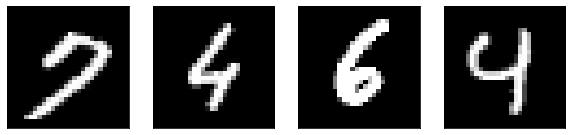

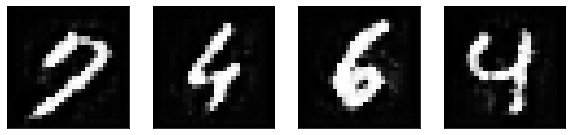

time taken in min: 0.7202376405398051
epoch 105 batch 50 batch total loss 0.005744736
epoch 105 batch 50 batch cluster loss 1.7877184e-05
epoch 105 batch 50 batch regen loss 0.005726859
saving...



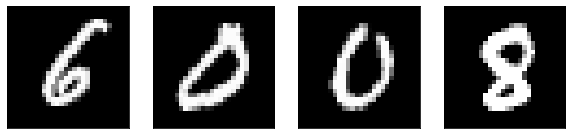

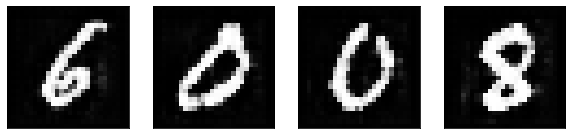

time taken in min: 2.084683692455292
epoch 105 batch 100 batch total loss 0.005640715
epoch 105 batch 100 batch cluster loss 1.8647535e-05
epoch 105 batch 100 batch regen loss 0.0056220675
saving...



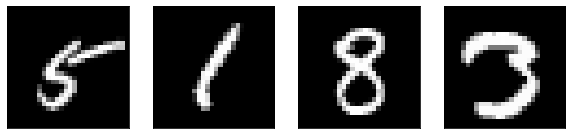

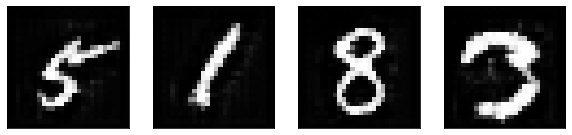

time taken in min: 2.0941195686658225

epoch 105 epoch avg loss 0.005681350436535174
epoch 105 epoch avg cluster loss 1.807473108783597e-05
epoch 105 epoch avg regen loss 0.005663275702903836



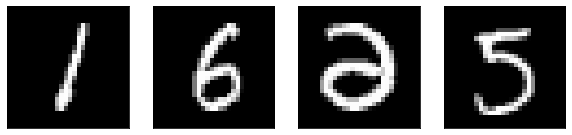

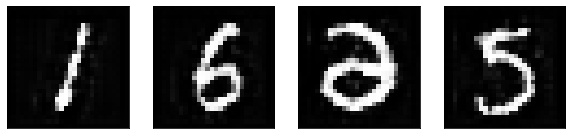

saving...

epoch 106
epoch 106 batch 0 batch total loss 0.0055923383
epoch 106 batch 0 batch cluster loss 1.7519535e-05
epoch 106 batch 0 batch regen loss 0.0055748187
saving...



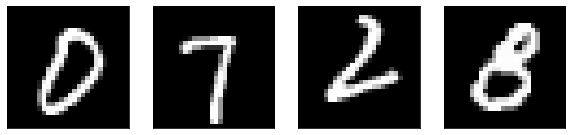

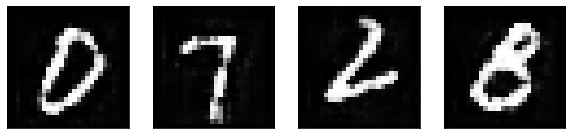

time taken in min: 0.7207603653271993
epoch 106 batch 50 batch total loss 0.0057694144
epoch 106 batch 50 batch cluster loss 1.8516974e-05
epoch 106 batch 50 batch regen loss 0.0057508973
saving...



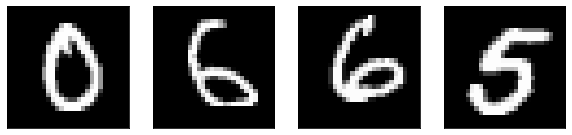

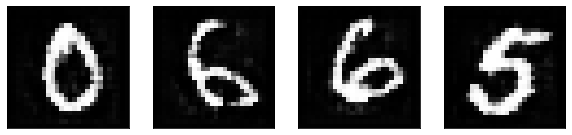

time taken in min: 2.0841748396555584
epoch 106 batch 100 batch total loss 0.005839377
epoch 106 batch 100 batch cluster loss 1.8578025e-05
epoch 106 batch 100 batch regen loss 0.005820799
saving...



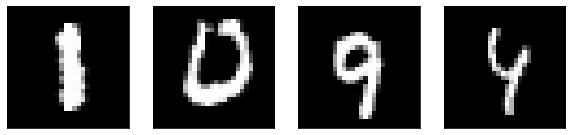

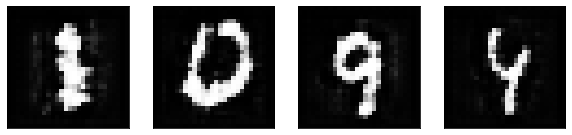

time taken in min: 2.085422956943512

epoch 106 epoch avg loss 0.005674452990514494
epoch 106 epoch avg cluster loss 1.7857979447260237e-05
epoch 106 epoch avg regen loss 0.005656595010373552



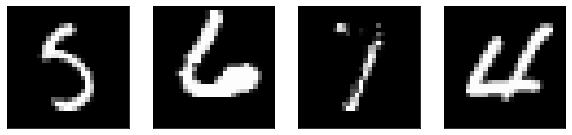

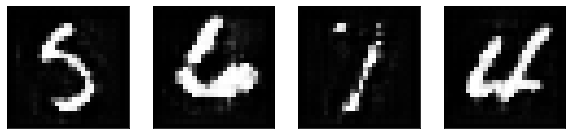

saving...

epoch 107
epoch 107 batch 0 batch total loss 0.0058930255
epoch 107 batch 0 batch cluster loss 1.798646e-05
epoch 107 batch 0 batch regen loss 0.005875039
saving...



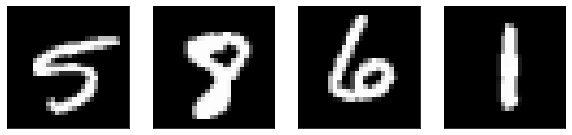

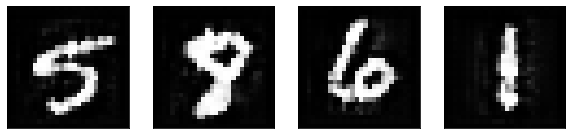

time taken in min: 0.7170791149139404
epoch 107 batch 50 batch total loss 0.0057243537
epoch 107 batch 50 batch cluster loss 1.7261622e-05
epoch 107 batch 50 batch regen loss 0.005707092
saving...



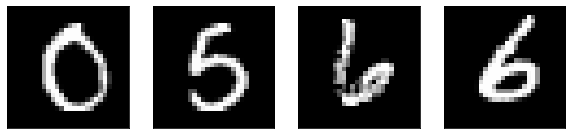

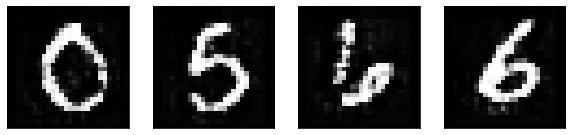

time taken in min: 2.0890980919202167
epoch 107 batch 100 batch total loss 0.0056435918
epoch 107 batch 100 batch cluster loss 1.6751015e-05
epoch 107 batch 100 batch regen loss 0.0056268405
saving...



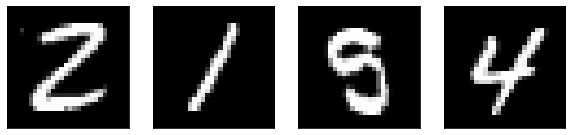

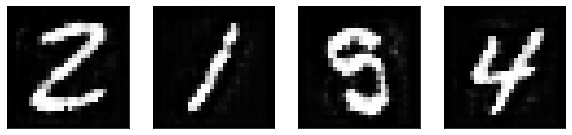

time taken in min: 2.091896426677704

epoch 107 epoch avg loss 0.0056732039409294974
epoch 107 epoch avg cluster loss 1.7635362197879812e-05
epoch 107 epoch avg regen loss 0.005655568566615299



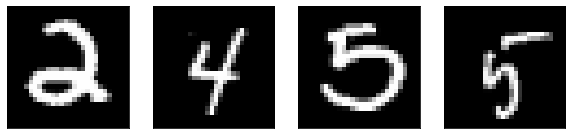

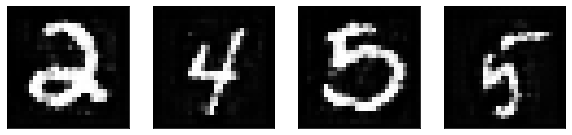

saving...

epoch 108
epoch 108 batch 0 batch total loss 0.0057795485
epoch 108 batch 0 batch cluster loss 1.8251034e-05
epoch 108 batch 0 batch regen loss 0.0057612974
saving...



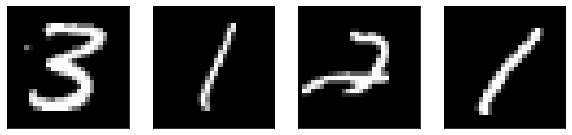

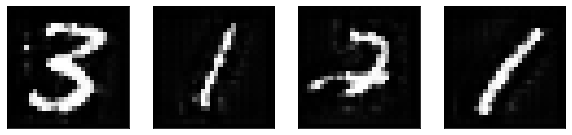

time taken in min: 0.7191191633542379
epoch 108 batch 50 batch total loss 0.0056914915
epoch 108 batch 50 batch cluster loss 1.8622855e-05
epoch 108 batch 50 batch regen loss 0.005672869
saving...



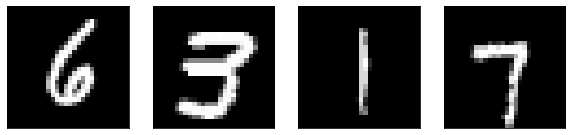

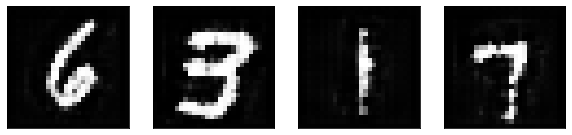

time taken in min: 2.0841450889905295
epoch 108 batch 100 batch total loss 0.0057036737
epoch 108 batch 100 batch cluster loss 1.8179542e-05
epoch 108 batch 100 batch regen loss 0.0056854943
saving...



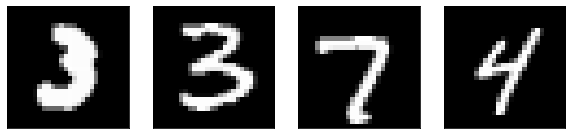

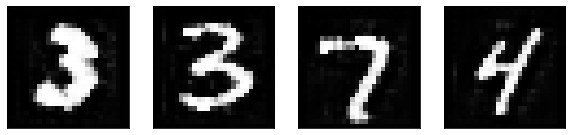

time taken in min: 2.0825447837511697

epoch 108 epoch avg loss 0.005664088392346087
epoch 108 epoch avg cluster loss 1.748017984937178e-05
epoch 108 epoch avg regen loss 0.005646608205575307



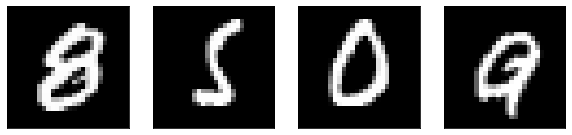

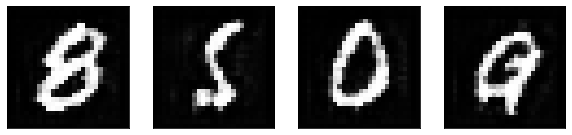

saving...

epoch 109
epoch 109 batch 0 batch total loss 0.0055686096
epoch 109 batch 0 batch cluster loss 1.8472314e-05
epoch 109 batch 0 batch regen loss 0.0055501373
saving...



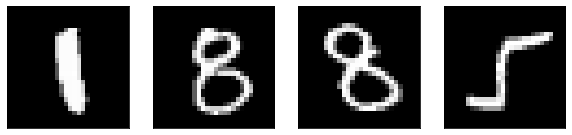

time taken in min: 0.7183089812596639
epoch 109 batch 50 batch total loss 0.0056349463
epoch 109 batch 50 batch cluster loss 1.732313e-05
epoch 109 batch 50 batch regen loss 0.005617623
saving...



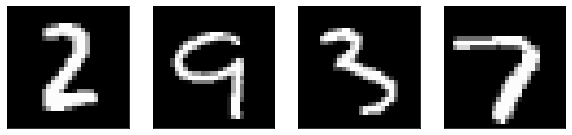

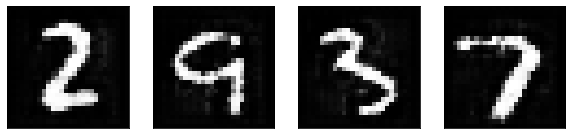

time taken in min: 2.091305955251058
epoch 109 batch 100 batch total loss 0.005479651
epoch 109 batch 100 batch cluster loss 1.6629223e-05
epoch 109 batch 100 batch regen loss 0.005463022
saving...



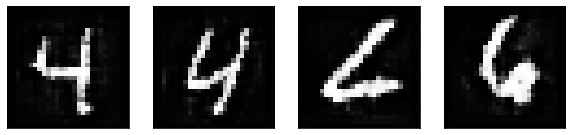

time taken in min: 2.0936718424161276

epoch 109 epoch avg loss 0.005657044286697598
epoch 109 epoch avg cluster loss 1.744410555902967e-05
epoch 109 epoch avg regen loss 0.005639600208407994



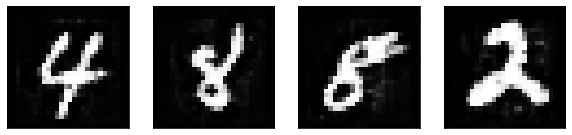

saving...

epoch 110
epoch 110 batch 0 batch total loss 0.0056726686
epoch 110 batch 0 batch cluster loss 1.7091663e-05
epoch 110 batch 0 batch regen loss 0.005655577
saving...



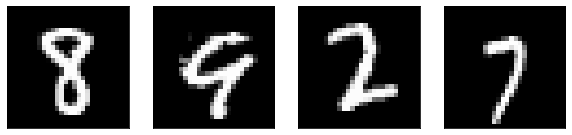

time taken in min: 0.71979318857193
epoch 110 batch 50 batch total loss 0.005801786
epoch 110 batch 50 batch cluster loss 1.6977656e-05
epoch 110 batch 50 batch regen loss 0.0057848087
saving...



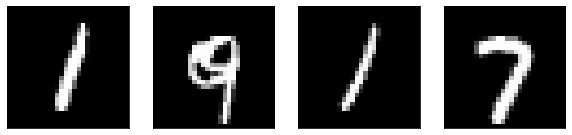

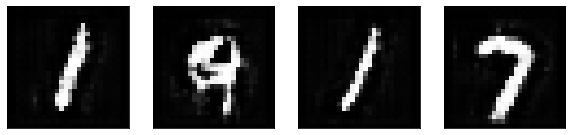

time taken in min: 2.097046891848246
epoch 110 batch 100 batch total loss 0.0056254542
epoch 110 batch 100 batch cluster loss 1.7257384e-05
epoch 110 batch 100 batch regen loss 0.005608197
saving...



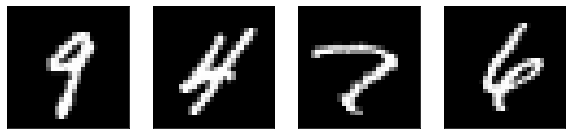

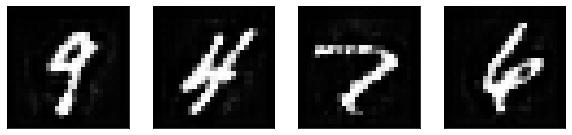

time taken in min: 2.0836744864781696

epoch 110 epoch avg loss 0.005650228954914768
epoch 110 epoch avg cluster loss 1.7207439961597535e-05
epoch 110 epoch avg regen loss 0.005633021503592194



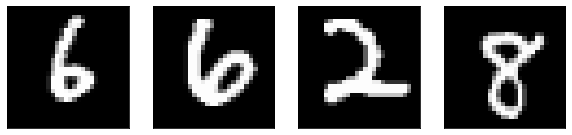

saving...

epoch 111
epoch 111 batch 0 batch total loss 0.005749665
epoch 111 batch 0 batch cluster loss 1.832825e-05
epoch 111 batch 0 batch regen loss 0.005731337
saving...



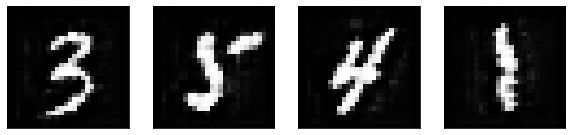

time taken in min: 0.7219560027122498
epoch 111 batch 50 batch total loss 0.005527487
epoch 111 batch 50 batch cluster loss 1.6365719e-05
epoch 111 batch 50 batch regen loss 0.0055111214
saving...



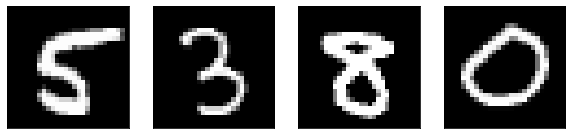

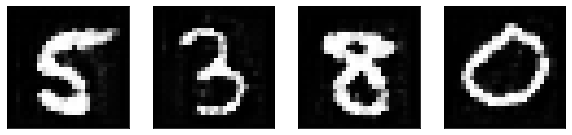

time taken in min: 2.0919790784517924
epoch 111 batch 100 batch total loss 0.005640029
epoch 111 batch 100 batch cluster loss 1.6903252e-05
epoch 111 batch 100 batch regen loss 0.005623126
saving...



time taken in min: 2.087508992354075

epoch 111 epoch avg loss 0.005642899631727803
epoch 111 epoch avg cluster loss 1.7082700188916918e-05
epoch 111 epoch avg regen loss 0.005625816934221125



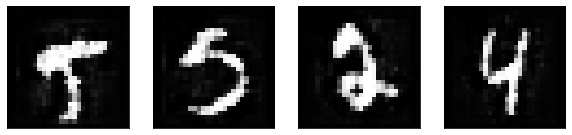

saving...

epoch 112
epoch 112 batch 0 batch total loss 0.0056351693
epoch 112 batch 0 batch cluster loss 1.6897096e-05
epoch 112 batch 0 batch regen loss 0.0056182723
saving...



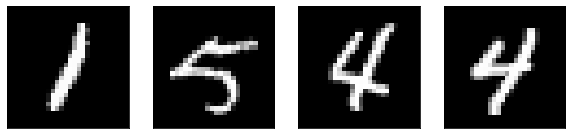

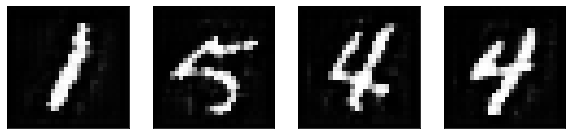

time taken in min: 0.7185012698173523
epoch 112 batch 50 batch total loss 0.0056848433
epoch 112 batch 50 batch cluster loss 1.6031783e-05
epoch 112 batch 50 batch regen loss 0.0056688115
saving...



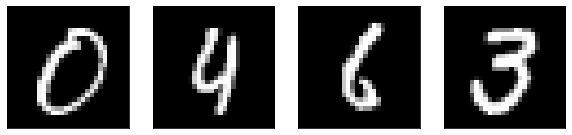

time taken in min: 2.087571076552073
epoch 112 batch 100 batch total loss 0.0058866767
epoch 112 batch 100 batch cluster loss 1.711488e-05
epoch 112 batch 100 batch regen loss 0.005869562
saving...



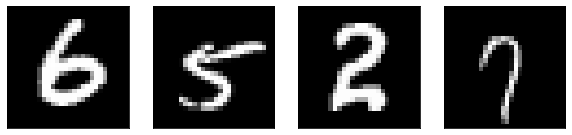

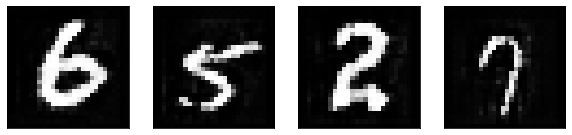

time taken in min: 2.0931033929189047

epoch 112 epoch avg loss 0.005634100610485016
epoch 112 epoch avg cluster loss 1.687453462536569e-05
epoch 112 epoch avg regen loss 0.005617226083305175



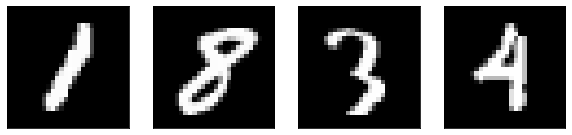

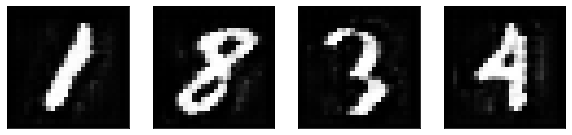

saving...

epoch 113
epoch 113 batch 0 batch total loss 0.0055983616
epoch 113 batch 0 batch cluster loss 1.7418166e-05
epoch 113 batch 0 batch regen loss 0.0055809435
saving...



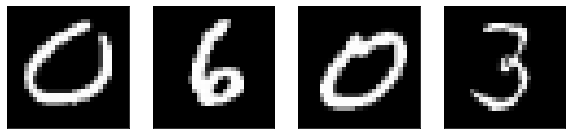

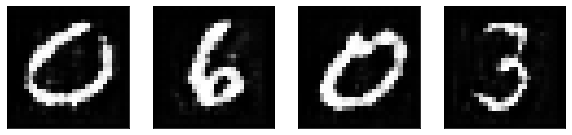

time taken in min: 0.7219372868537903
epoch 113 batch 50 batch total loss 0.0057028877
epoch 113 batch 50 batch cluster loss 1.7061162e-05
epoch 113 batch 50 batch regen loss 0.0056858263
saving...



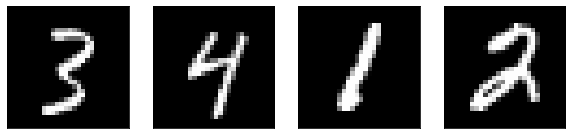

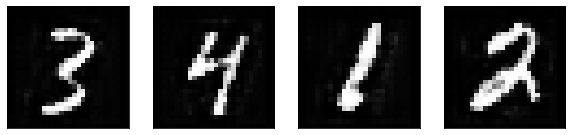

time taken in min: 2.087429682413737
epoch 113 batch 100 batch total loss 0.005612206
epoch 113 batch 100 batch cluster loss 1.6452099e-05
epoch 113 batch 100 batch regen loss 0.005595754
saving...



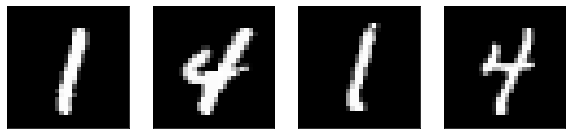

time taken in min: 2.0846965312957764

epoch 113 epoch avg loss 0.005627187320141722
epoch 113 epoch avg cluster loss 1.6750328109468435e-05
epoch 113 epoch avg regen loss 0.005610436978513154



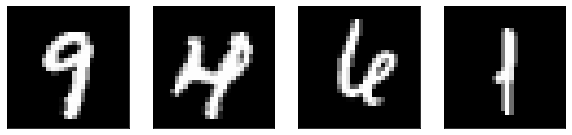

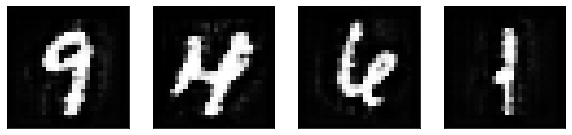

saving...

epoch 114
epoch 114 batch 0 batch total loss 0.0057032118
epoch 114 batch 0 batch cluster loss 1.6407892e-05
epoch 114 batch 0 batch regen loss 0.0056868037
saving...



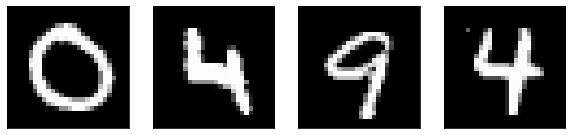

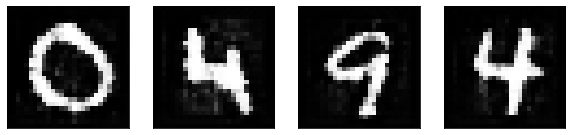

time taken in min: 0.7199494878451029
epoch 114 batch 50 batch total loss 0.0056294943
epoch 114 batch 50 batch cluster loss 1.659601e-05
epoch 114 batch 50 batch regen loss 0.005612898
saving...



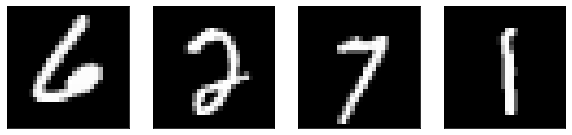

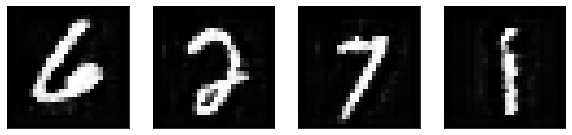

time taken in min: 2.076486110687256
epoch 114 batch 100 batch total loss 0.0057555423
epoch 114 batch 100 batch cluster loss 1.8129878e-05
epoch 114 batch 100 batch regen loss 0.0057374123
saving...



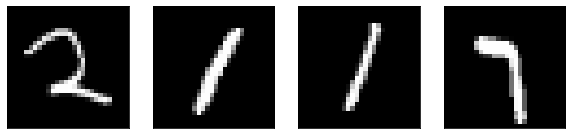

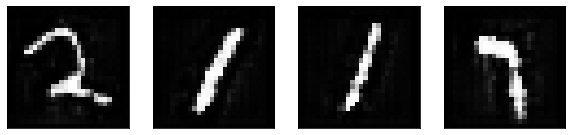

time taken in min: 2.0959911266962687

epoch 114 epoch avg loss 0.005619944120615216
epoch 114 epoch avg cluster loss 1.6657594881245917e-05
epoch 114 epoch avg regen loss 0.005603286524508464



saving...

epoch 115
epoch 115 batch 0 batch total loss 0.0056728227
epoch 115 batch 0 batch cluster loss 1.6117452e-05
epoch 115 batch 0 batch regen loss 0.0056567052
saving...



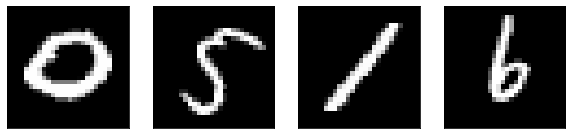

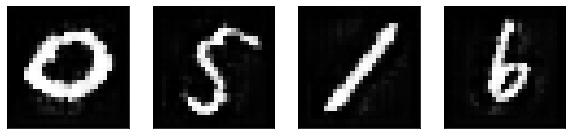

time taken in min: 0.7230420152346293
epoch 115 batch 50 batch total loss 0.0056705656
epoch 115 batch 50 batch cluster loss 1.645147e-05
epoch 115 batch 50 batch regen loss 0.0056541143
saving...



time taken in min: 2.0886267026265464
epoch 115 batch 100 batch total loss 0.005510706
epoch 115 batch 100 batch cluster loss 1.5613809e-05
epoch 115 batch 100 batch regen loss 0.0054950924
saving...



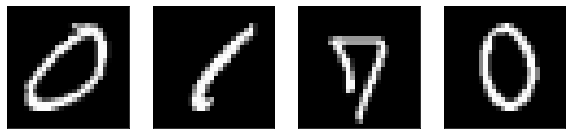

time taken in min: 2.0905155420303343

epoch 115 epoch avg loss 0.00561638958594304
epoch 115 epoch avg cluster loss 1.651168334365909e-05
epoch 115 epoch avg regen loss 0.005599877931240757



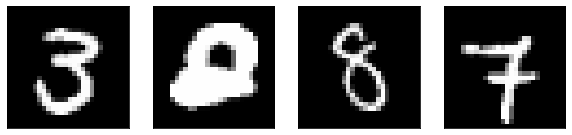

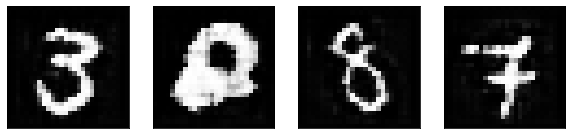

saving...

epoch 116
epoch 116 batch 0 batch total loss 0.0055597154
epoch 116 batch 0 batch cluster loss 1.6355869e-05
epoch 116 batch 0 batch regen loss 0.0055433596
saving...



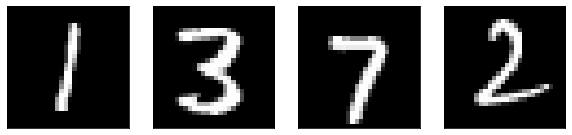

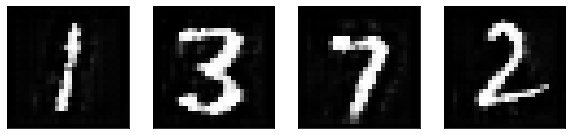

time taken in min: 0.7197707295417786
epoch 116 batch 50 batch total loss 0.0055252034
epoch 116 batch 50 batch cluster loss 1.646756e-05
epoch 116 batch 50 batch regen loss 0.005508736
saving...



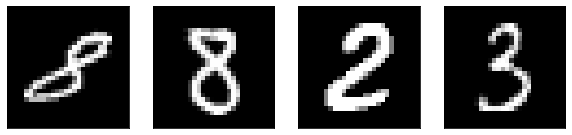

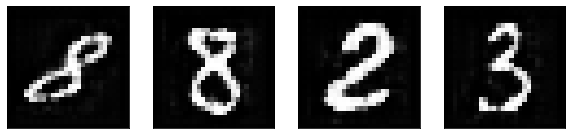

time taken in min: 2.085988461971283
epoch 116 batch 100 batch total loss 0.0055080745
epoch 116 batch 100 batch cluster loss 1.6123393e-05
epoch 116 batch 100 batch regen loss 0.005491951
saving...



time taken in min: 2.0915831009546917

epoch 116 epoch avg loss 0.005608539337734297
epoch 116 epoch avg cluster loss 1.6301232073478248e-05
epoch 116 epoch avg regen loss 0.005592238114578492



saving...

epoch 117
epoch 117 batch 0 batch total loss 0.005651435
epoch 117 batch 0 batch cluster loss 1.626209e-05
epoch 117 batch 0 batch regen loss 0.0056351726
saving...



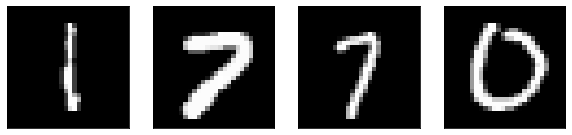

time taken in min: 0.7189743836720784
epoch 117 batch 50 batch total loss 0.005649403
epoch 117 batch 50 batch cluster loss 1.6072554e-05
epoch 117 batch 50 batch regen loss 0.0056333304
saving...



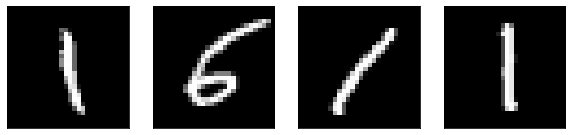

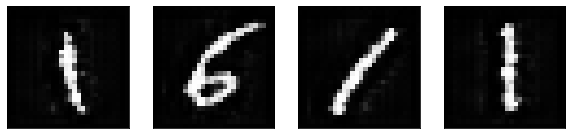

time taken in min: 2.0872052470842997
epoch 117 batch 100 batch total loss 0.005599837
epoch 117 batch 100 batch cluster loss 1.5794827e-05
epoch 117 batch 100 batch regen loss 0.005584042
saving...



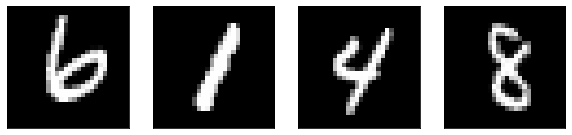

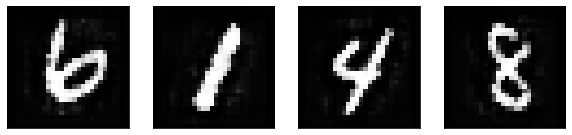

time taken in min: 2.0941943883895875

epoch 117 epoch avg loss 0.005601438101759906
epoch 117 epoch avg cluster loss 1.627673092594181e-05
epoch 117 epoch avg regen loss 0.005585161365284506



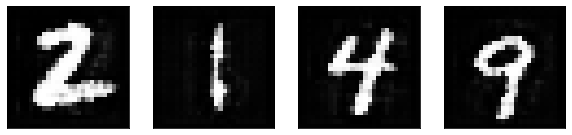

saving...

epoch 118
epoch 118 batch 0 batch total loss 0.00563769
epoch 118 batch 0 batch cluster loss 1.6199041e-05
epoch 118 batch 0 batch regen loss 0.005621491
saving...



time taken in min: 0.7204663991928101
epoch 118 batch 50 batch total loss 0.0057251477
epoch 118 batch 50 batch cluster loss 1.6170306e-05
epoch 118 batch 50 batch regen loss 0.0057089776
saving...



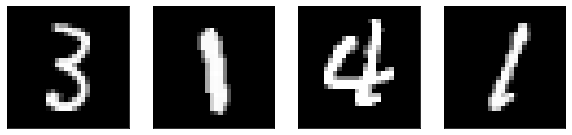

time taken in min: 2.098103670279185
epoch 118 batch 100 batch total loss 0.0057303486
epoch 118 batch 100 batch cluster loss 1.639432e-05
epoch 118 batch 100 batch regen loss 0.005713954
saving...



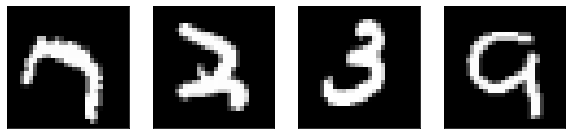

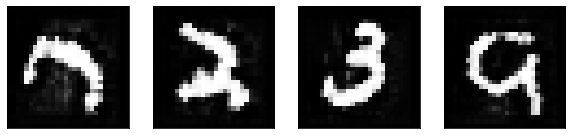

time taken in min: 2.098247786362966

epoch 118 epoch avg loss 0.005594782440496956
epoch 118 epoch avg cluster loss 1.6039905342225565e-05
epoch 118 epoch avg regen loss 0.005578742512517562



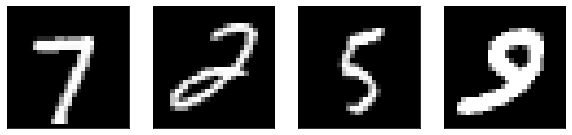

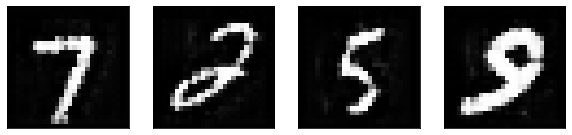

saving...

epoch 119
epoch 119 batch 0 batch total loss 0.005502443
epoch 119 batch 0 batch cluster loss 1.558617e-05
epoch 119 batch 0 batch regen loss 0.0054868567
saving...



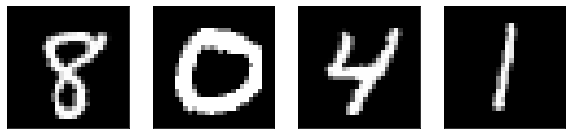

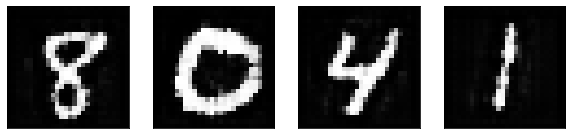

time taken in min: 0.7186050812403361
epoch 119 batch 50 batch total loss 0.0055457223
epoch 119 batch 50 batch cluster loss 1.5985179e-05
epoch 119 batch 50 batch regen loss 0.005529737
saving...



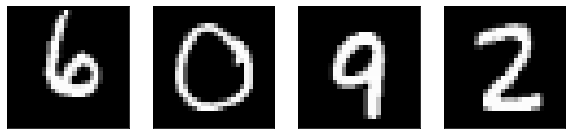

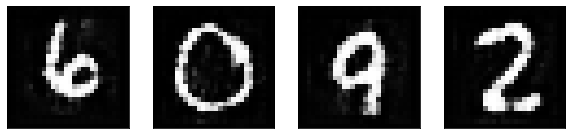

time taken in min: 2.079173485438029
epoch 119 batch 100 batch total loss 0.005766143
epoch 119 batch 100 batch cluster loss 1.5730448e-05
epoch 119 batch 100 batch regen loss 0.0057504126
saving...



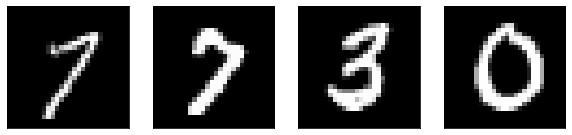

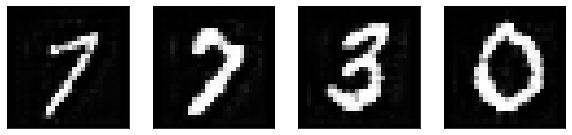

time taken in min: 2.0879192550977073

epoch 119 epoch avg loss 0.0055867988316310666
epoch 119 epoch avg cluster loss 1.5911902549197618e-05
epoch 119 epoch avg regen loss 0.005570886905257732



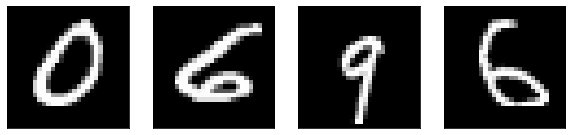

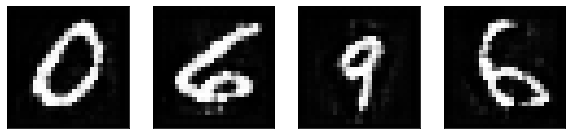

saving...

epoch 120
epoch 120 batch 0 batch total loss 0.0056050005
epoch 120 batch 0 batch cluster loss 1.5251145e-05
epoch 120 batch 0 batch regen loss 0.005589749
saving...



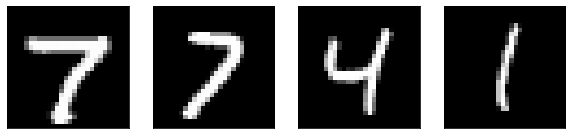

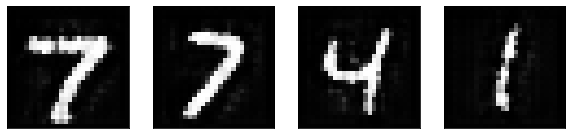

time taken in min: 0.7189378698666891
epoch 120 batch 50 batch total loss 0.005668543
epoch 120 batch 50 batch cluster loss 1.569958e-05
epoch 120 batch 50 batch regen loss 0.005652843
saving...



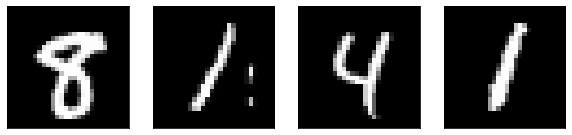

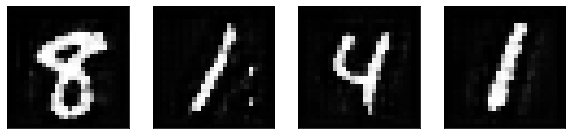

time taken in min: 2.09391180674235
epoch 120 batch 100 batch total loss 0.005648151
epoch 120 batch 100 batch cluster loss 1.5510319e-05
epoch 120 batch 100 batch regen loss 0.005632641
saving...



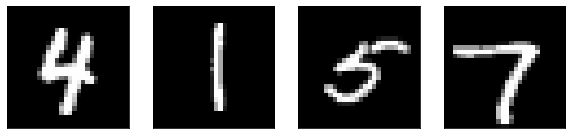

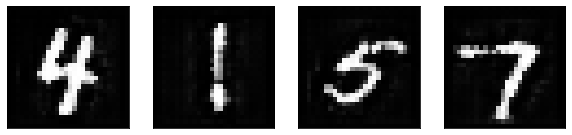

time taken in min: 2.099632473786672

epoch 120 epoch avg loss 0.0055819029043728515
epoch 120 epoch avg cluster loss 1.5811022067436618e-05
epoch 120 epoch avg regen loss 0.005566091876540144



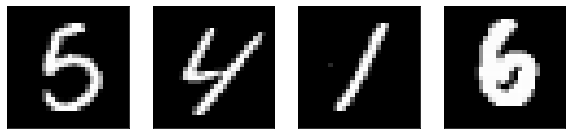

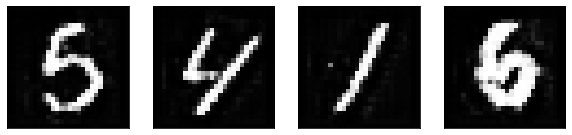

saving...

epoch 121
epoch 121 batch 0 batch total loss 0.0054219128
epoch 121 batch 0 batch cluster loss 1.6007245e-05
epoch 121 batch 0 batch regen loss 0.0054059057
saving...



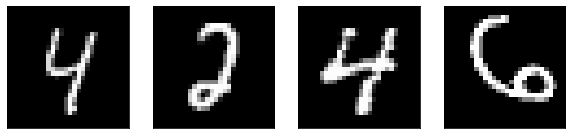

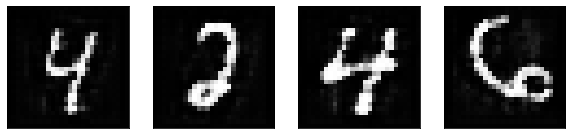

time taken in min: 0.7187858104705811
epoch 121 batch 50 batch total loss 0.005537016
epoch 121 batch 50 batch cluster loss 1.5779684e-05
epoch 121 batch 50 batch regen loss 0.005521236
saving...



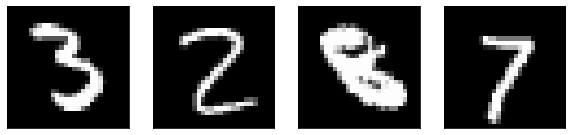

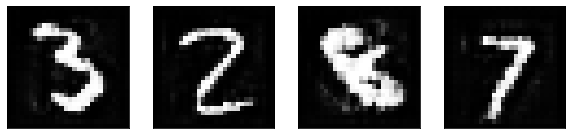

time taken in min: 2.0881798466046653
epoch 121 batch 100 batch total loss 0.0055514583
epoch 121 batch 100 batch cluster loss 1.6164888e-05
epoch 121 batch 100 batch regen loss 0.0055352934
saving...



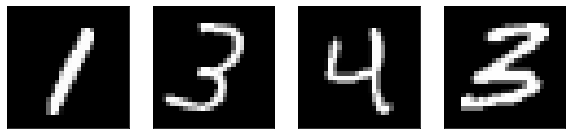

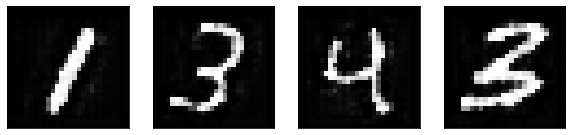

time taken in min: 2.0911020278930663

epoch 121 epoch avg loss 0.005577556303528659
epoch 121 epoch avg cluster loss 1.570562280749535e-05
epoch 121 epoch avg regen loss 0.005561850672998166



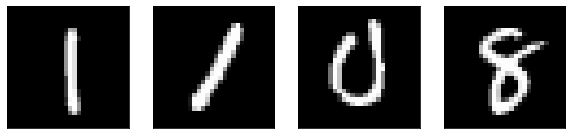

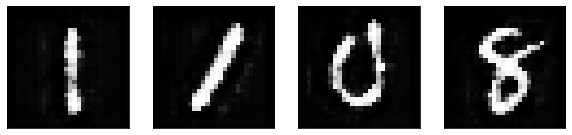

saving...

epoch 122
epoch 122 batch 0 batch total loss 0.0055352678
epoch 122 batch 0 batch cluster loss 1.5026234e-05
epoch 122 batch 0 batch regen loss 0.0055202413
saving...



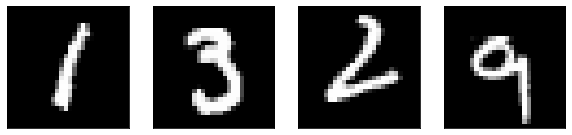

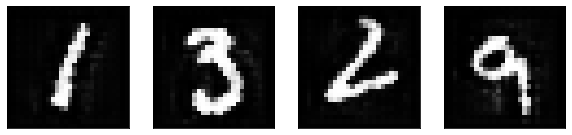

time taken in min: 0.7218896547953287
epoch 122 batch 50 batch total loss 0.005514911
epoch 122 batch 50 batch cluster loss 1.565392e-05
epoch 122 batch 50 batch regen loss 0.005499257
saving...



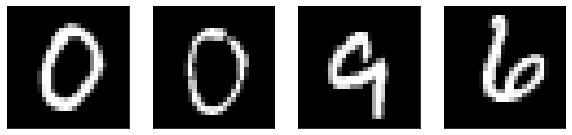

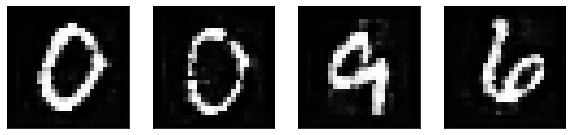

time taken in min: 2.0880967736244203
epoch 122 batch 100 batch total loss 0.005443252
epoch 122 batch 100 batch cluster loss 1.5116171e-05
epoch 122 batch 100 batch regen loss 0.005428136
saving...



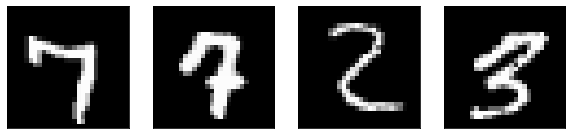

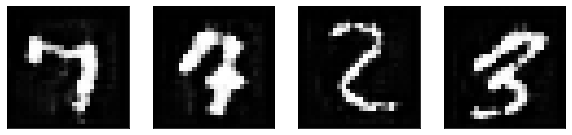

time taken in min: 2.0917199730873106

epoch 122 epoch avg loss 0.005571647160449776
epoch 122 epoch avg cluster loss 1.555608029729367e-05
epoch 122 epoch avg regen loss 0.005556091074279304



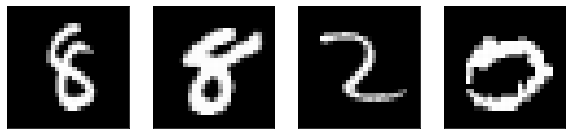

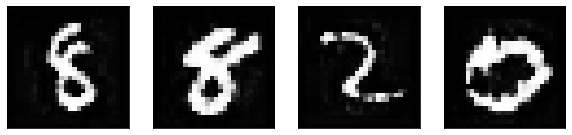

saving...

epoch 123
epoch 123 batch 0 batch total loss 0.0055373386
epoch 123 batch 0 batch cluster loss 1.48862355e-05
epoch 123 batch 0 batch regen loss 0.0055224523
saving...



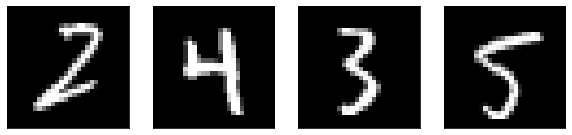

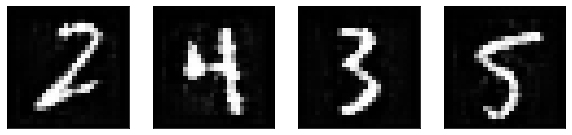

time taken in min: 0.7219455003738403
epoch 123 batch 50 batch total loss 0.005634098
epoch 123 batch 50 batch cluster loss 1.5106714e-05
epoch 123 batch 50 batch regen loss 0.0056189913
saving...



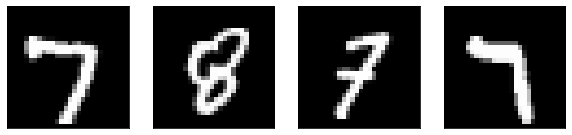

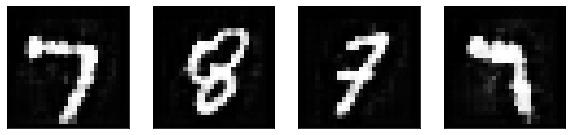

time taken in min: 2.092880006631215
epoch 123 batch 100 batch total loss 0.005411173
epoch 123 batch 100 batch cluster loss 1.6054184e-05
epoch 123 batch 100 batch regen loss 0.005395119
saving...



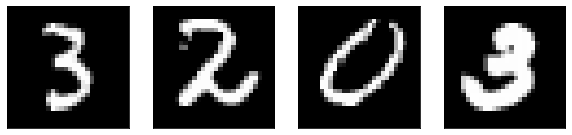

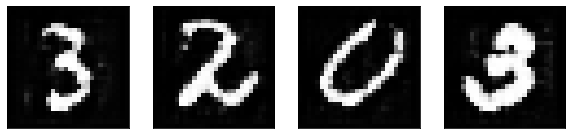

time taken in min: 2.089987548192342

epoch 123 epoch avg loss 0.005562648729626405
epoch 123 epoch avg cluster loss 1.5438459509607777e-05
epoch 123 epoch avg regen loss 0.005547210270286364



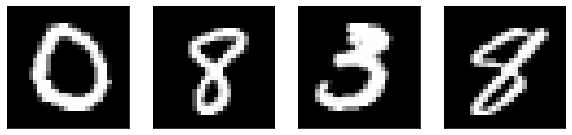

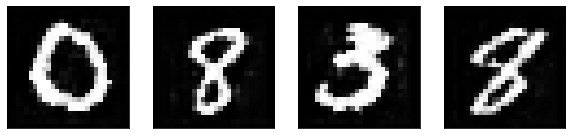

saving...

epoch 124
epoch 124 batch 0 batch total loss 0.0055727223
epoch 124 batch 0 batch cluster loss 1.5594544e-05
epoch 124 batch 0 batch regen loss 0.0055571278
saving...



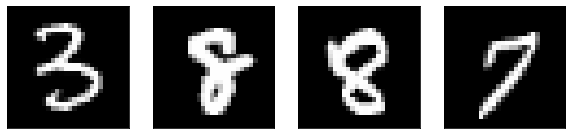

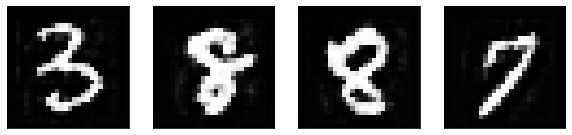

time taken in min: 0.715064263343811
epoch 124 batch 50 batch total loss 0.0057523875
epoch 124 batch 50 batch cluster loss 1.5635142e-05
epoch 124 batch 50 batch regen loss 0.0057367524
saving...



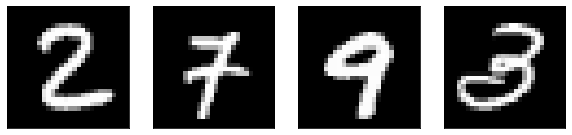

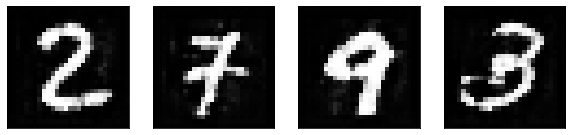

time taken in min: 2.0789610226949056
epoch 124 batch 100 batch total loss 0.00559133
epoch 124 batch 100 batch cluster loss 1.581761e-05
epoch 124 batch 100 batch regen loss 0.0055755125
saving...



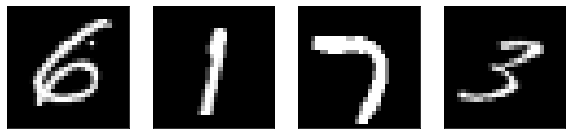

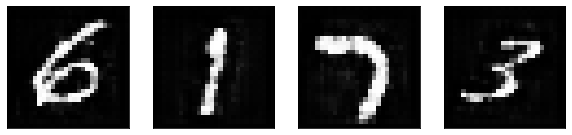

time taken in min: 2.083412599563599

epoch 124 epoch avg loss 0.0055585990865099225
epoch 124 epoch avg cluster loss 1.5367048868260316e-05
epoch 124 epoch avg regen loss 0.005543232027251842



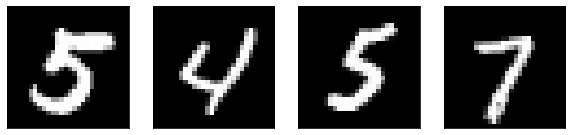

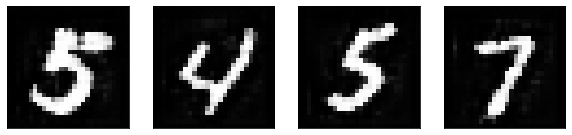

saving...

epoch 125
epoch 125 batch 0 batch total loss 0.005612
epoch 125 batch 0 batch cluster loss 1.5254434e-05
epoch 125 batch 0 batch regen loss 0.0055967453
saving...



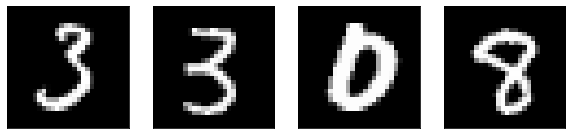

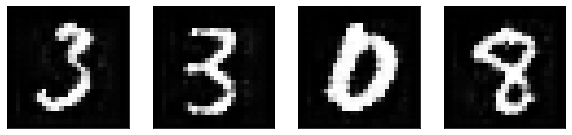

time taken in min: 0.7143390496571859
epoch 125 batch 50 batch total loss 0.0054476457
epoch 125 batch 50 batch cluster loss 1.5149439e-05
epoch 125 batch 50 batch regen loss 0.0054324963
saving...



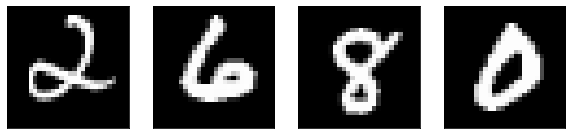

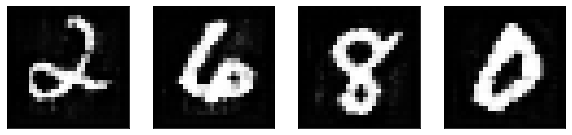

time taken in min: 2.0830369790395102
epoch 125 batch 100 batch total loss 0.005704388
epoch 125 batch 100 batch cluster loss 1.5881938e-05
epoch 125 batch 100 batch regen loss 0.005688506
saving...



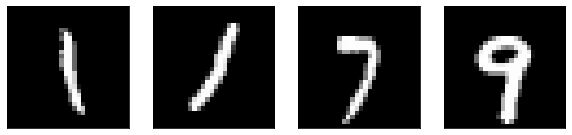

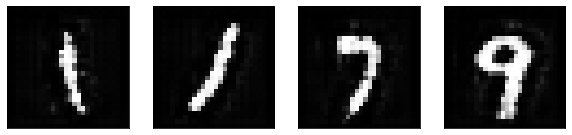

time taken in min: 2.0917851527531943

epoch 125 epoch avg loss 0.005550509456829247
epoch 125 epoch avg cluster loss 1.518305426713087e-05
epoch 125 epoch avg regen loss 0.0055353264127052946



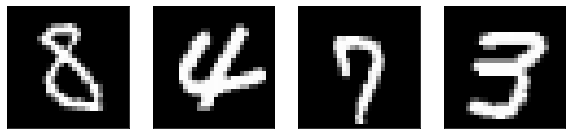

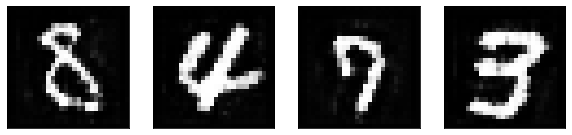

saving...

epoch 126
epoch 126 batch 0 batch total loss 0.005639473
epoch 126 batch 0 batch cluster loss 1.51747445e-05
epoch 126 batch 0 batch regen loss 0.005624298
saving...



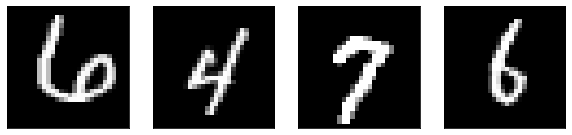

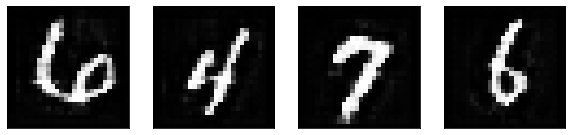

time taken in min: 0.7243991772333781
epoch 126 batch 50 batch total loss 0.005688085
epoch 126 batch 50 batch cluster loss 1.5037811e-05
epoch 126 batch 50 batch regen loss 0.0056730476
saving...



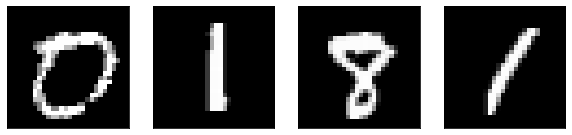

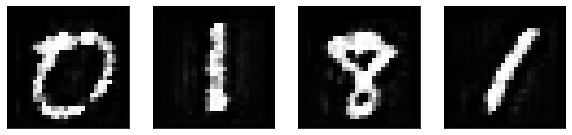

time taken in min: 2.0905826687812805
epoch 126 batch 100 batch total loss 0.0054784194
epoch 126 batch 100 batch cluster loss 1.5496764e-05
epoch 126 batch 100 batch regen loss 0.0054629226
saving...



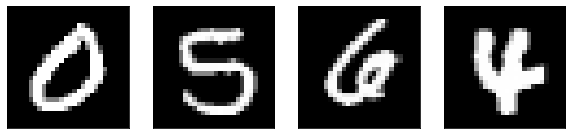

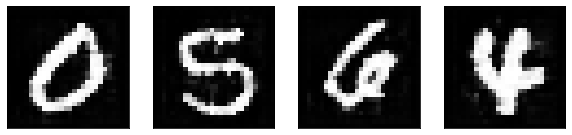

time taken in min: 2.0815163135528563

epoch 126 epoch avg loss 0.005544634658243444
epoch 126 epoch avg cluster loss 1.5119138995140605e-05
epoch 126 epoch avg regen loss 0.005529515520211751



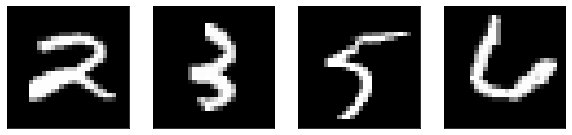

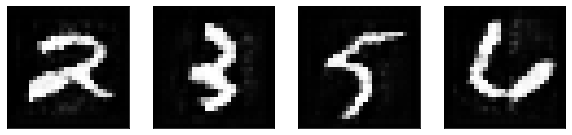

saving...

epoch 127
epoch 127 batch 0 batch total loss 0.005583815
epoch 127 batch 0 batch cluster loss 1.5955822e-05
epoch 127 batch 0 batch regen loss 0.005567859
saving...



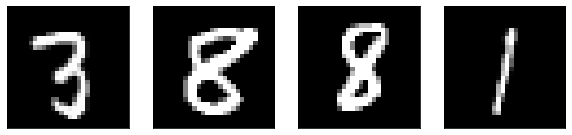

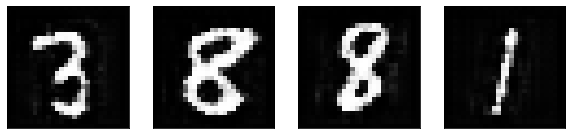

time taken in min: 0.7221060593922933
epoch 127 batch 50 batch total loss 0.0055787642
epoch 127 batch 50 batch cluster loss 1.5499658e-05
epoch 127 batch 50 batch regen loss 0.0055632647
saving...



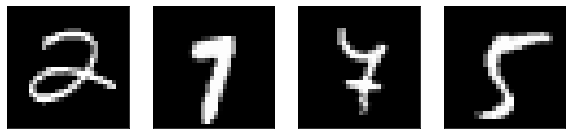

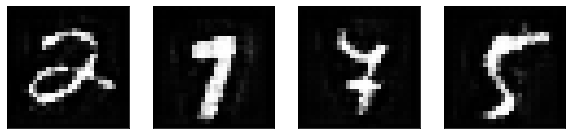

time taken in min: 2.0823908686637878
epoch 127 batch 100 batch total loss 0.005736248
epoch 127 batch 100 batch cluster loss 1.4859933e-05
epoch 127 batch 100 batch regen loss 0.0057213884
saving...



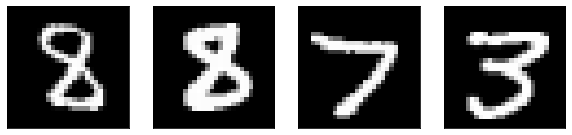

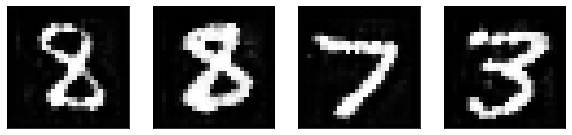

time taken in min: 2.08387957016627

epoch 127 epoch avg loss 0.00553798825495829
epoch 127 epoch avg cluster loss 1.4958644912393677e-05
epoch 127 epoch avg regen loss 0.005523029616165717



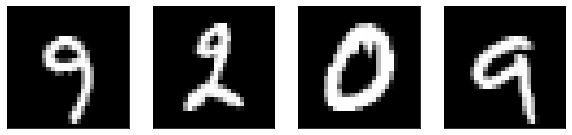

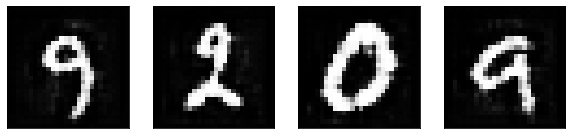

saving...

epoch 128
epoch 128 batch 0 batch total loss 0.0056246435
epoch 128 batch 0 batch cluster loss 1.4966409e-05
epoch 128 batch 0 batch regen loss 0.005609677
saving...



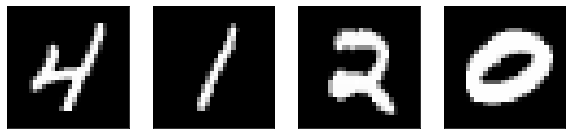

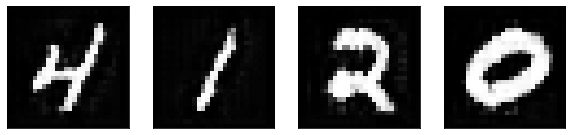

time taken in min: 0.717372183005015
epoch 128 batch 50 batch total loss 0.0055175745
epoch 128 batch 50 batch cluster loss 1.4915099e-05
epoch 128 batch 50 batch regen loss 0.0055026594
saving...



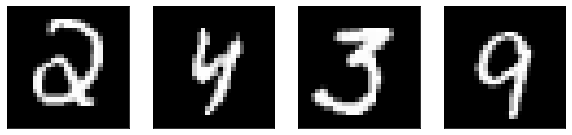

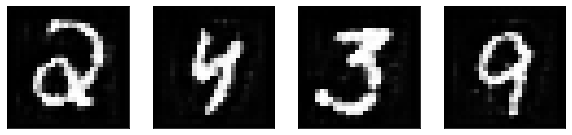

time taken in min: 2.0943649848302206
epoch 128 batch 100 batch total loss 0.0053346246
epoch 128 batch 100 batch cluster loss 1.4945499e-05
epoch 128 batch 100 batch regen loss 0.005319679
saving...



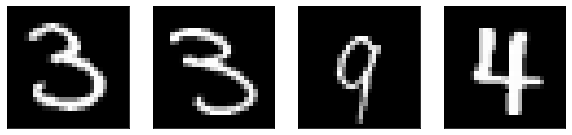

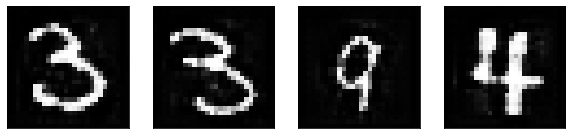

time taken in min: 2.0993913372357684

epoch 128 epoch avg loss 0.005529680983873748
epoch 128 epoch avg cluster loss 1.4827883629642833e-05
epoch 128 epoch avg regen loss 0.005514853105138419



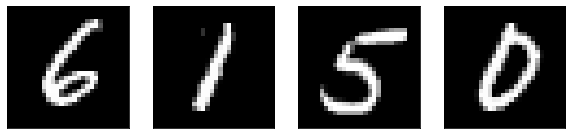

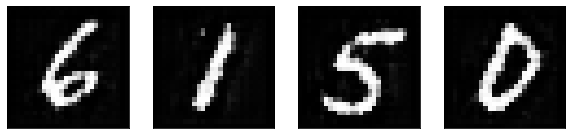

saving...

epoch 129
epoch 129 batch 0 batch total loss 0.005542858
epoch 129 batch 0 batch cluster loss 1.4341927e-05
epoch 129 batch 0 batch regen loss 0.005528516
saving...



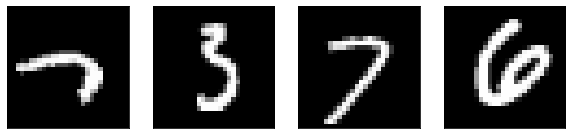

time taken in min: 0.7163544774055481
epoch 129 batch 50 batch total loss 0.00544137
epoch 129 batch 50 batch cluster loss 1.4877941e-05
epoch 129 batch 50 batch regen loss 0.005426492
saving...



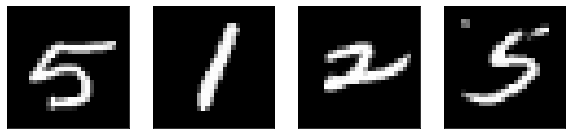

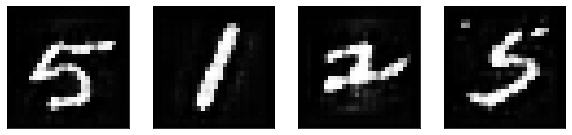

time taken in min: 2.093989364306132
epoch 129 batch 100 batch total loss 0.005503579
epoch 129 batch 100 batch cluster loss 1.569924e-05
epoch 129 batch 100 batch regen loss 0.0054878797
saving...



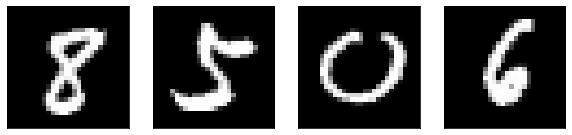

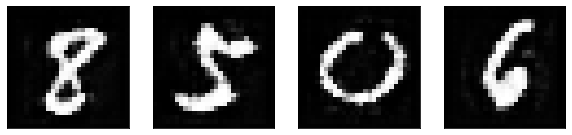

time taken in min: 2.088446513811747

epoch 129 epoch avg loss 0.005522116695104514
epoch 129 epoch avg cluster loss 1.4751957778725674e-05
epoch 129 epoch avg regen loss 0.005507364723105299



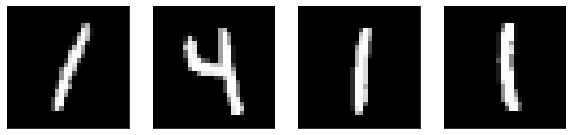

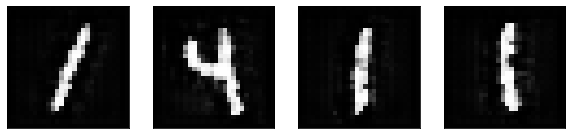

saving...

epoch 130
epoch 130 batch 0 batch total loss 0.00547387
epoch 130 batch 0 batch cluster loss 1.487406e-05
epoch 130 batch 0 batch regen loss 0.0054589957
saving...



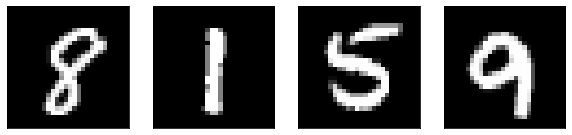

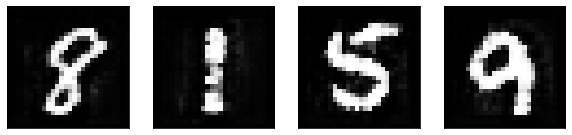

time taken in min: 0.7183776021003723
epoch 130 batch 50 batch total loss 0.005411924
epoch 130 batch 50 batch cluster loss 1.455932e-05
epoch 130 batch 50 batch regen loss 0.0053973645
saving...



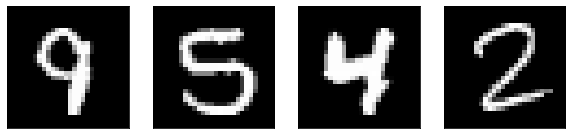

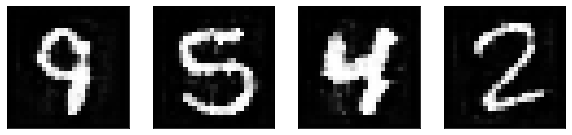

time taken in min: 2.091416331132253
epoch 130 batch 100 batch total loss 0.005627988
epoch 130 batch 100 batch cluster loss 1.51579325e-05
epoch 130 batch 100 batch regen loss 0.00561283
saving...



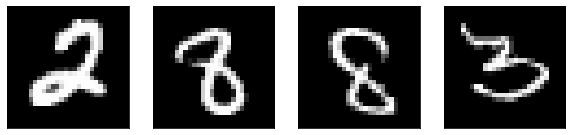

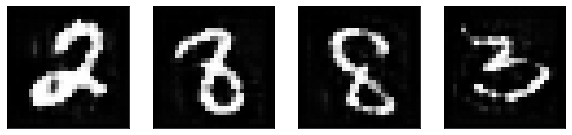

time taken in min: 2.101127831141154

epoch 130 epoch avg loss 0.005520901157347075
epoch 130 epoch avg cluster loss 1.462071154260923e-05
epoch 130 epoch avg regen loss 0.005506280466314342



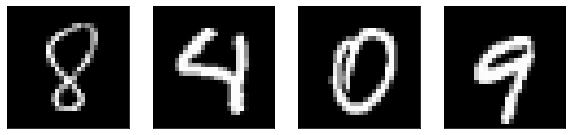

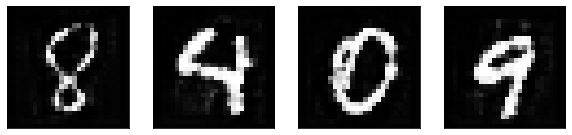

saving...

epoch 131
epoch 131 batch 0 batch total loss 0.0053546336
epoch 131 batch 0 batch cluster loss 1.4865756e-05
epoch 131 batch 0 batch regen loss 0.005339768
saving...



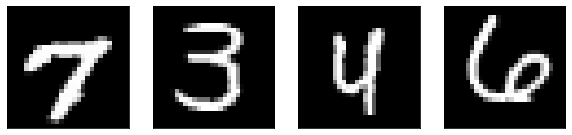

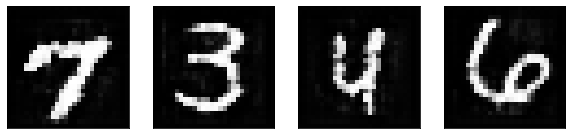

time taken in min: 0.7215255816777547
epoch 131 batch 50 batch total loss 0.0054272753
epoch 131 batch 50 batch cluster loss 1.397554e-05
epoch 131 batch 50 batch regen loss 0.0054133
saving...



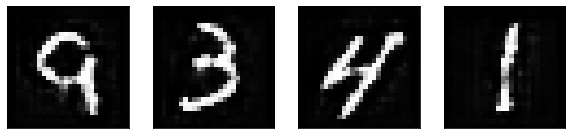

time taken in min: 2.0858368118604025
epoch 131 batch 100 batch total loss 0.0055924347
epoch 131 batch 100 batch cluster loss 1.5237414e-05
epoch 131 batch 100 batch regen loss 0.0055771973
saving...



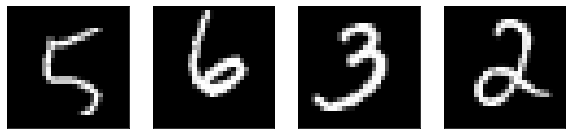

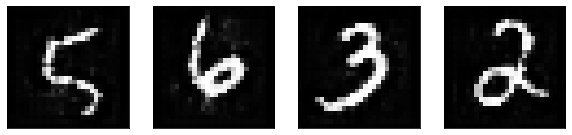

time taken in min: 2.0914957483609515

epoch 131 epoch avg loss 0.005511963846540804
epoch 131 epoch avg cluster loss 1.4570014666217394e-05
epoch 131 epoch avg regen loss 0.005497393857340439



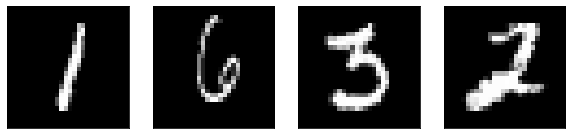

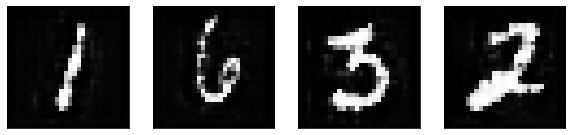

saving...

epoch 132
epoch 132 batch 0 batch total loss 0.0055545485
epoch 132 batch 0 batch cluster loss 1.4630839e-05
epoch 132 batch 0 batch regen loss 0.005539918
saving...



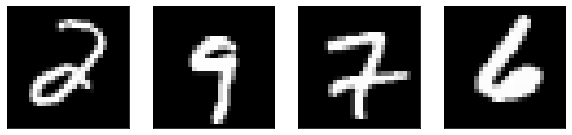

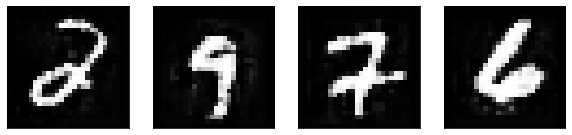

time taken in min: 0.7176774064699809
epoch 132 batch 50 batch total loss 0.005619754
epoch 132 batch 50 batch cluster loss 1.4162768e-05
epoch 132 batch 50 batch regen loss 0.0056055915
saving...



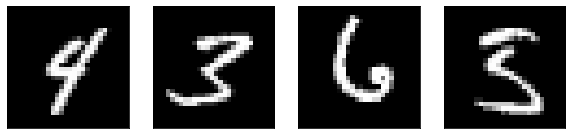

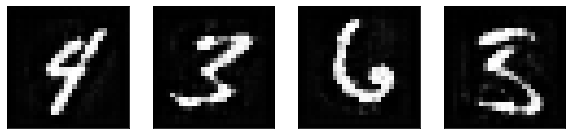

time taken in min: 2.0901968836784364
epoch 132 batch 100 batch total loss 0.005489772
epoch 132 batch 100 batch cluster loss 1.4628682e-05
epoch 132 batch 100 batch regen loss 0.0054751434
saving...



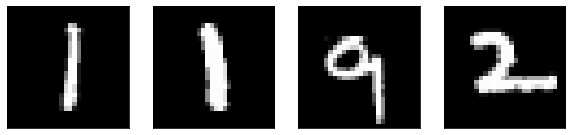

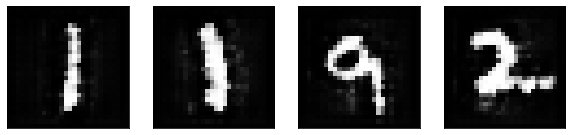

time taken in min: 2.0985965808232625

epoch 132 epoch avg loss 0.005505513790521329
epoch 132 epoch avg cluster loss 1.446942844453033e-05
epoch 132 epoch avg regen loss 0.0054910443683738935



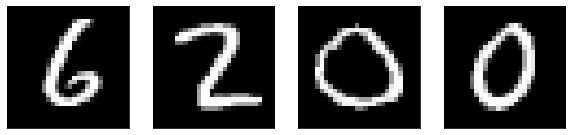

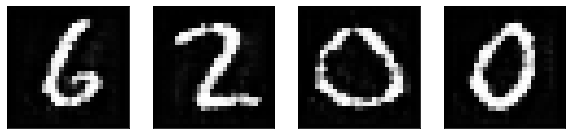

saving...

epoch 133
epoch 133 batch 0 batch total loss 0.005486584
epoch 133 batch 0 batch cluster loss 1.4395141e-05
epoch 133 batch 0 batch regen loss 0.005472189
saving...



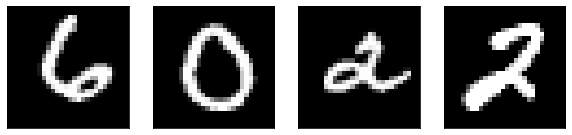

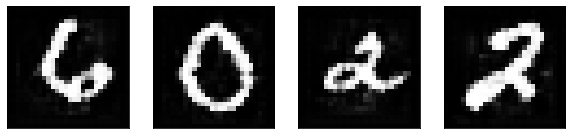

time taken in min: 0.7195435762405396
epoch 133 batch 50 batch total loss 0.0055411328
epoch 133 batch 50 batch cluster loss 1.3824585e-05
epoch 133 batch 50 batch regen loss 0.005527308
saving...



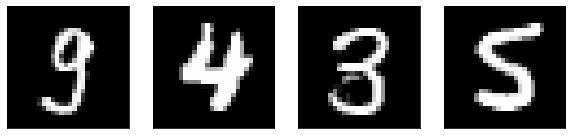

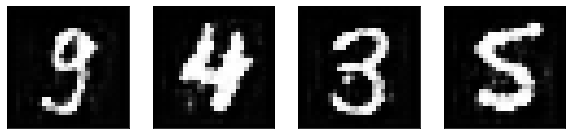

time taken in min: 2.0857539892196657
epoch 133 batch 100 batch total loss 0.00545832
epoch 133 batch 100 batch cluster loss 1.4314665e-05
epoch 133 batch 100 batch regen loss 0.005444005
saving...



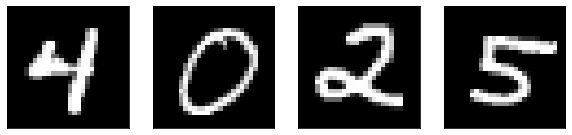

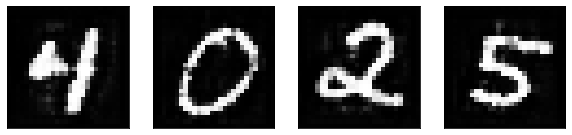

time taken in min: 2.0939555128415424

epoch 133 epoch avg loss 0.005499721090388247
epoch 133 epoch avg cluster loss 1.4324018986556793e-05
epoch 133 epoch avg regen loss 0.005485397061112069



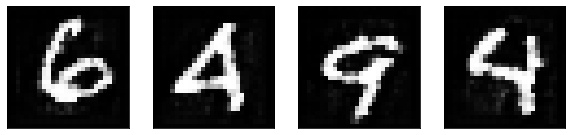

saving...

epoch 134
epoch 134 batch 0 batch total loss 0.005521255
epoch 134 batch 0 batch cluster loss 1.5778649e-05
epoch 134 batch 0 batch regen loss 0.0055054766
saving...



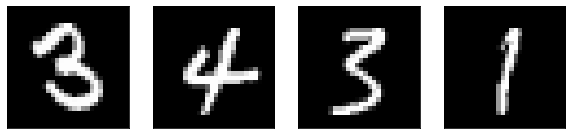

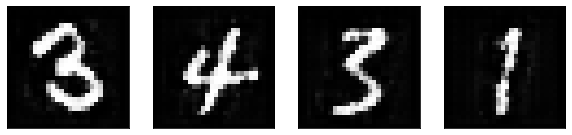

time taken in min: 0.7202698508898417
epoch 134 batch 50 batch total loss 0.0055483896
epoch 134 batch 50 batch cluster loss 1.4093527e-05
epoch 134 batch 50 batch regen loss 0.005534296
saving...



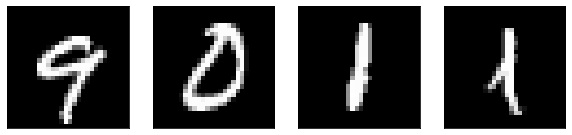

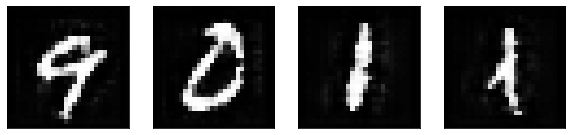

time taken in min: 2.086319653193156
epoch 134 batch 100 batch total loss 0.0054404
epoch 134 batch 100 batch cluster loss 1.3696089e-05
epoch 134 batch 100 batch regen loss 0.005426704
saving...



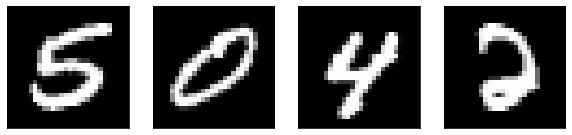

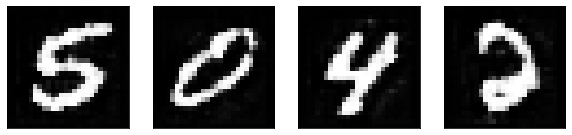

time taken in min: 2.0816959063212077

epoch 134 epoch avg loss 0.0054937402867727865
epoch 134 epoch avg cluster loss 1.4252387654007673e-05
epoch 134 epoch avg regen loss 0.005479487910140622



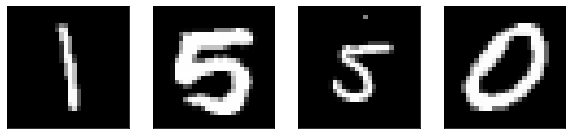

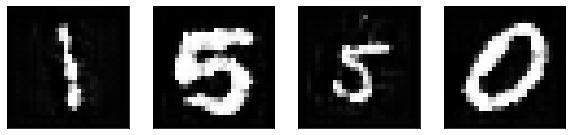

saving...

epoch 135
epoch 135 batch 0 batch total loss 0.0056158234
epoch 135 batch 0 batch cluster loss 1.4236879e-05
epoch 135 batch 0 batch regen loss 0.005601587
saving...



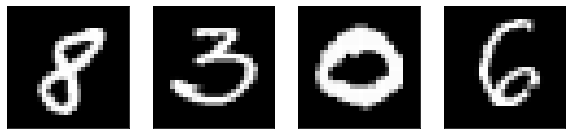

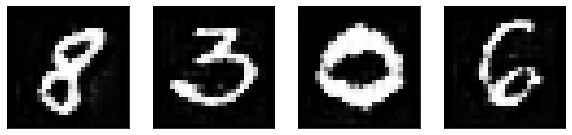

time taken in min: 0.7152807871500652
epoch 135 batch 50 batch total loss 0.0055413553
epoch 135 batch 50 batch cluster loss 1.4171049e-05
epoch 135 batch 50 batch regen loss 0.0055271843
saving...



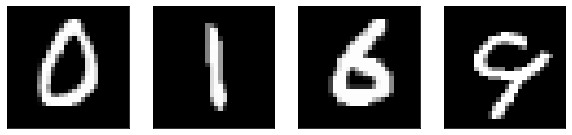

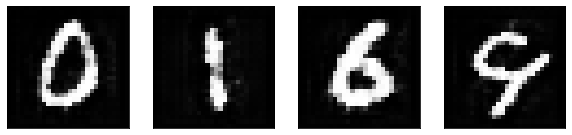

time taken in min: 2.094576632976532
epoch 135 batch 100 batch total loss 0.0054721576
epoch 135 batch 100 batch cluster loss 1.3658566e-05
epoch 135 batch 100 batch regen loss 0.005458499
saving...



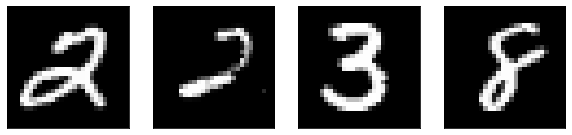

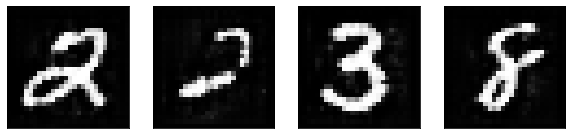

time taken in min: 2.097779373327891

epoch 135 epoch avg loss 0.005488688256433707
epoch 135 epoch avg cluster loss 1.4043997252575552e-05
epoch 135 epoch avg regen loss 0.005474644251388766



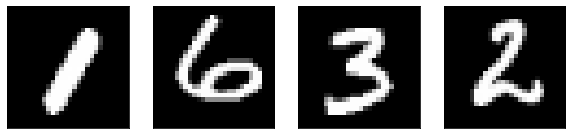

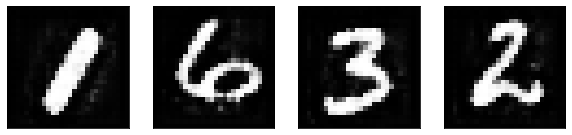

saving...

epoch 136
epoch 136 batch 0 batch total loss 0.0053991256
epoch 136 batch 0 batch cluster loss 1.2756911e-05
epoch 136 batch 0 batch regen loss 0.005386369
saving...



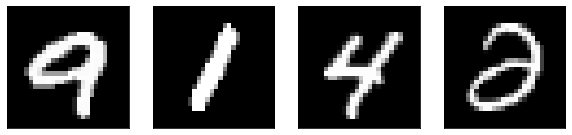

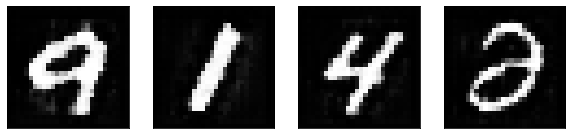

time taken in min: 0.7236091693242391
epoch 136 batch 50 batch total loss 0.0054470673
epoch 136 batch 50 batch cluster loss 1.4234382e-05
epoch 136 batch 50 batch regen loss 0.005432833
saving...



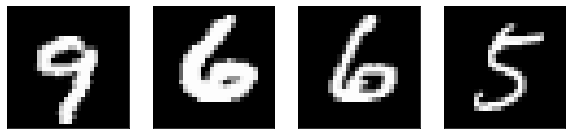

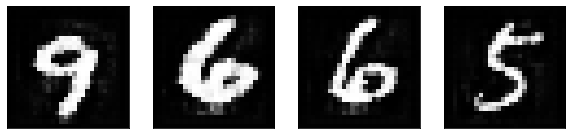

time taken in min: 2.0960259397824603
epoch 136 batch 100 batch total loss 0.005568374
epoch 136 batch 100 batch cluster loss 1.4497671e-05
epoch 136 batch 100 batch regen loss 0.005553876
saving...



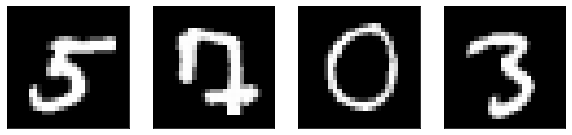

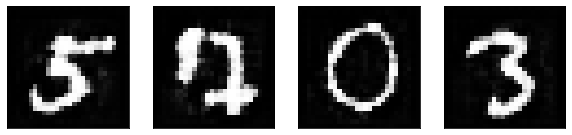

time taken in min: 2.087239595254262

epoch 136 epoch avg loss 0.00548234910277997
epoch 136 epoch avg cluster loss 1.3999644841656476e-05
epoch 136 epoch avg regen loss 0.005468349457892068



saving...

epoch 137
epoch 137 batch 0 batch total loss 0.005450165
epoch 137 batch 0 batch cluster loss 1.3549384e-05
epoch 137 batch 0 batch regen loss 0.0054366156
saving...



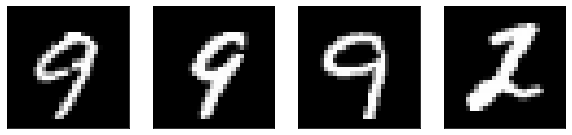

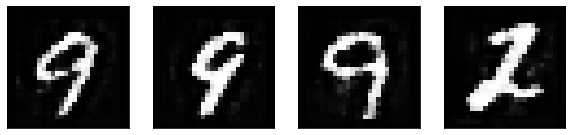

time taken in min: 0.7221301158269247
epoch 137 batch 50 batch total loss 0.0054463013
epoch 137 batch 50 batch cluster loss 1.3328953e-05
epoch 137 batch 50 batch regen loss 0.005432972
saving...



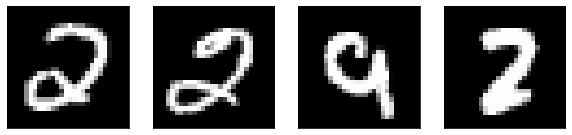

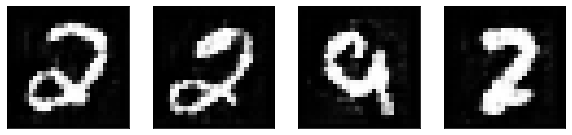

time taken in min: 2.0846808989842733
epoch 137 batch 100 batch total loss 0.0056506027
epoch 137 batch 100 batch cluster loss 1.3935106e-05
epoch 137 batch 100 batch regen loss 0.005636668
saving...



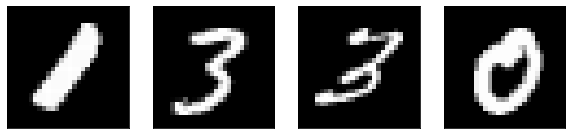

time taken in min: 2.0942116657892864

epoch 137 epoch avg loss 0.005478081794581928
epoch 137 epoch avg cluster loss 1.3951291417100238e-05
epoch 137 epoch avg regen loss 0.005464130535058804



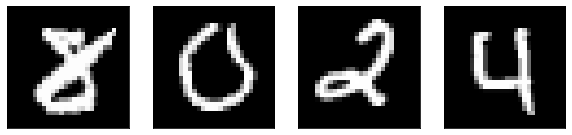

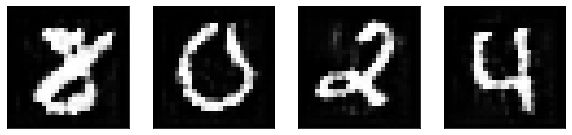

saving...

epoch 138
epoch 138 batch 0 batch total loss 0.0054849037
epoch 138 batch 0 batch cluster loss 1.41149585e-05
epoch 138 batch 0 batch regen loss 0.0054707886
saving...



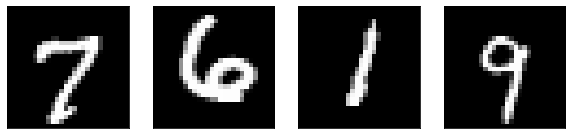

time taken in min: 0.7235244035720825
epoch 138 batch 50 batch total loss 0.005276095
epoch 138 batch 50 batch cluster loss 1.3542521e-05
epoch 138 batch 50 batch regen loss 0.0052625528
saving...



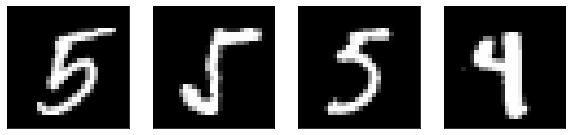

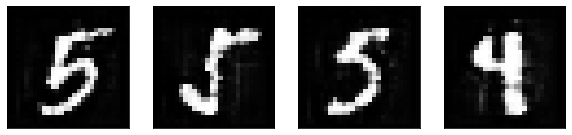

time taken in min: 2.0880759239196776
epoch 138 batch 100 batch total loss 0.005477475
epoch 138 batch 100 batch cluster loss 1.4161357e-05
epoch 138 batch 100 batch regen loss 0.005463314
saving...



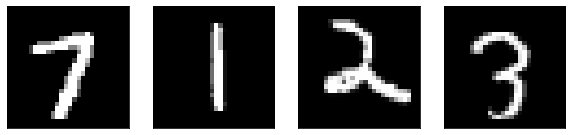

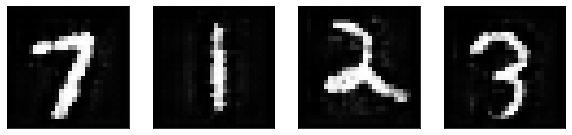

time taken in min: 2.0860468904177347

epoch 138 epoch avg loss 0.005470571258121123
epoch 138 epoch avg cluster loss 1.3834993990450916e-05
epoch 138 epoch avg regen loss 0.005456736283692516



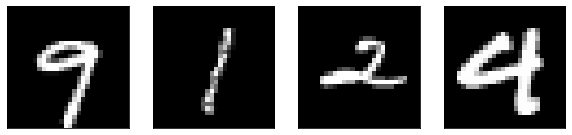

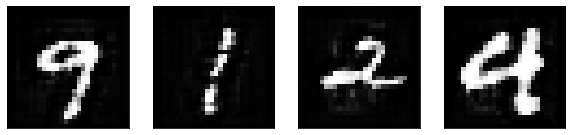

saving...

epoch 139
epoch 139 batch 0 batch total loss 0.0055010533
epoch 139 batch 0 batch cluster loss 1.4062105e-05
epoch 139 batch 0 batch regen loss 0.0054869913
saving...



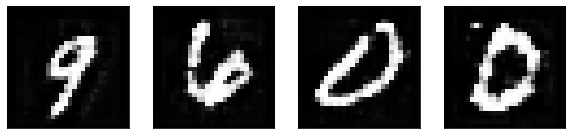

time taken in min: 0.7192554513613383
epoch 139 batch 50 batch total loss 0.005441924
epoch 139 batch 50 batch cluster loss 1.3619213e-05
epoch 139 batch 50 batch regen loss 0.005428305
saving...



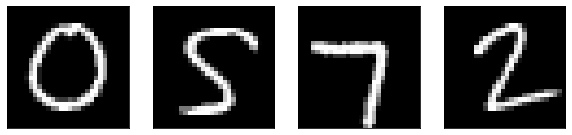

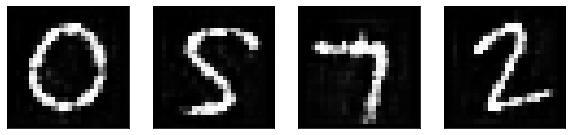

time taken in min: 2.0868337035179136
epoch 139 batch 100 batch total loss 0.005505338
epoch 139 batch 100 batch cluster loss 1.3800842e-05
epoch 139 batch 100 batch regen loss 0.005491537
saving...



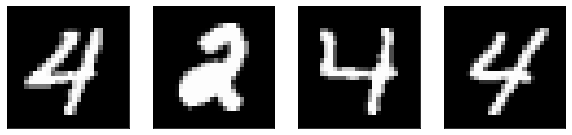

time taken in min: 2.0933371980985007

epoch 139 epoch avg loss 0.005469302098282566
epoch 139 epoch avg cluster loss 1.3762176692225848e-05
epoch 139 epoch avg regen loss 0.0054555399288123444



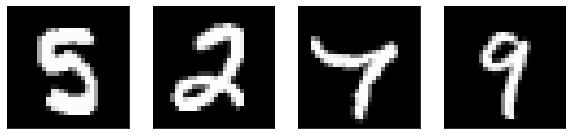

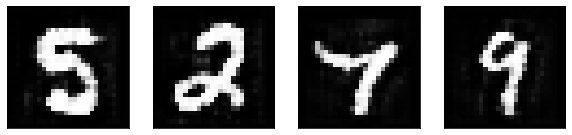

saving...

epoch 140
epoch 140 batch 0 batch total loss 0.005395961
epoch 140 batch 0 batch cluster loss 1.3980389e-05
epoch 140 batch 0 batch regen loss 0.0053819804
saving...



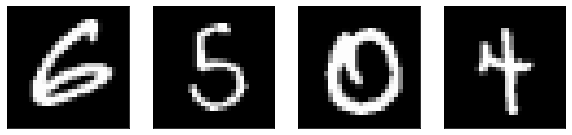

time taken in min: 0.7202685594558715
epoch 140 batch 50 batch total loss 0.0053812442
epoch 140 batch 50 batch cluster loss 1.3823912e-05
epoch 140 batch 50 batch regen loss 0.00536742
saving...



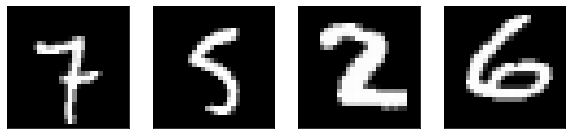

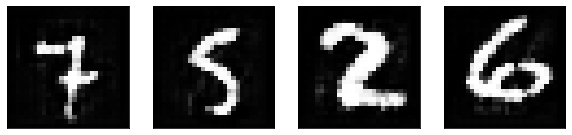

time taken in min: 2.098994235197703
epoch 140 batch 100 batch total loss 0.00546458
epoch 140 batch 100 batch cluster loss 1.3251562e-05
epoch 140 batch 100 batch regen loss 0.005451328
saving...



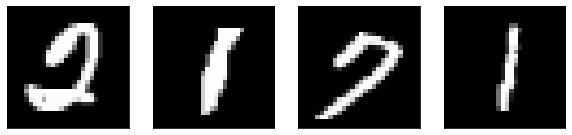

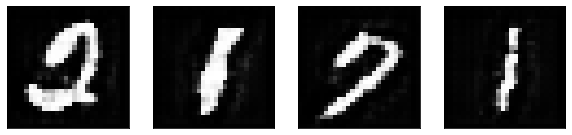

time taken in min: 2.0792577425638834

epoch 140 epoch avg loss 0.0054597385361853795
epoch 140 epoch avg cluster loss 1.3638812168025297e-05
epoch 140 epoch avg regen loss 0.005446099707762064



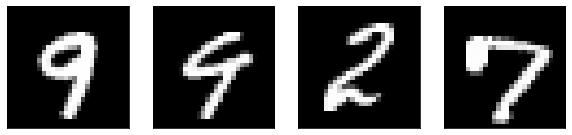

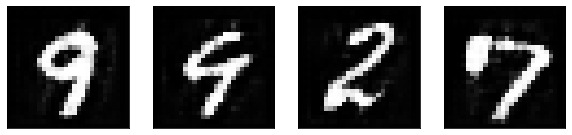

saving...

epoch 141
epoch 141 batch 0 batch total loss 0.005461087
epoch 141 batch 0 batch cluster loss 1.3190318e-05
epoch 141 batch 0 batch regen loss 0.0054478967
saving...



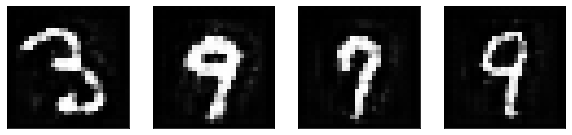

time taken in min: 0.717459789911906
epoch 141 batch 50 batch total loss 0.005628263
epoch 141 batch 50 batch cluster loss 1.415842e-05
epoch 141 batch 50 batch regen loss 0.0056141047
saving...



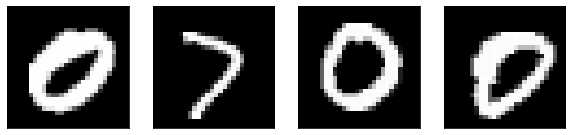

time taken in min: 2.08886833190918
epoch 141 batch 100 batch total loss 0.0055944114
epoch 141 batch 100 batch cluster loss 1.3812634e-05
epoch 141 batch 100 batch regen loss 0.005580599
saving...



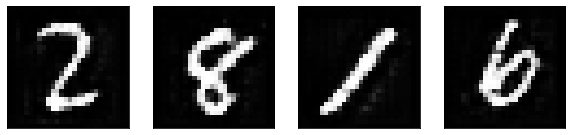

time taken in min: 2.0870471358299256

epoch 141 epoch avg loss 0.0054575664196479115
epoch 141 epoch avg cluster loss 1.3556820241797527e-05
epoch 141 epoch avg regen loss 0.005444009579181419



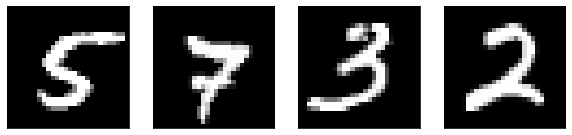

saving...

epoch 142
epoch 142 batch 0 batch total loss 0.0054264325
epoch 142 batch 0 batch cluster loss 1.4163179e-05
epoch 142 batch 0 batch regen loss 0.0054122694
saving...



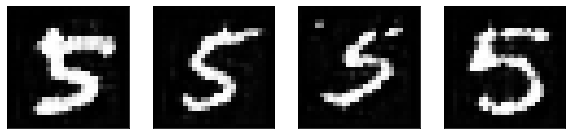

time taken in min: 0.722397514184316
epoch 142 batch 50 batch total loss 0.005399491
epoch 142 batch 50 batch cluster loss 1.3439758e-05
epoch 142 batch 50 batch regen loss 0.0053860513
saving...



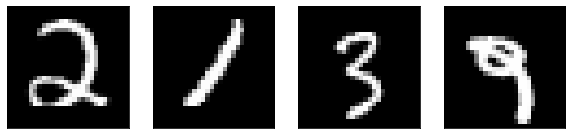

time taken in min: 2.0879753748575847
epoch 142 batch 100 batch total loss 0.0053939503
epoch 142 batch 100 batch cluster loss 1.3300079e-05
epoch 142 batch 100 batch regen loss 0.00538065
saving...



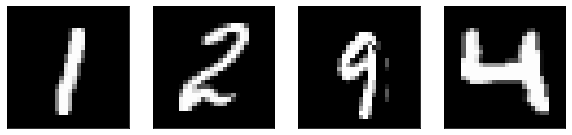

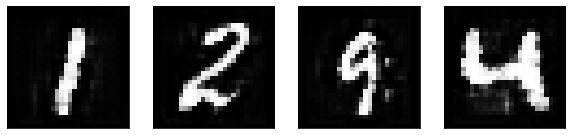

time taken in min: 2.081354188919067

epoch 142 epoch avg loss 0.005451806300019814
epoch 142 epoch avg cluster loss 1.3396743532335307e-05
epoch 142 epoch avg regen loss 0.005438409556271666



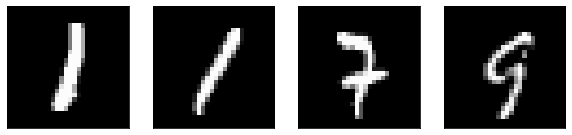

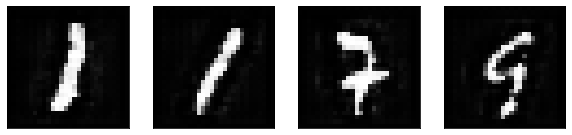

saving...

epoch 143
epoch 143 batch 0 batch total loss 0.005678039
epoch 143 batch 0 batch cluster loss 1.4458921e-05
epoch 143 batch 0 batch regen loss 0.0056635803
saving...



time taken in min: 0.7188158313433329
epoch 143 batch 50 batch total loss 0.005399896
epoch 143 batch 50 batch cluster loss 1.3023491e-05
epoch 143 batch 50 batch regen loss 0.005386872
saving...



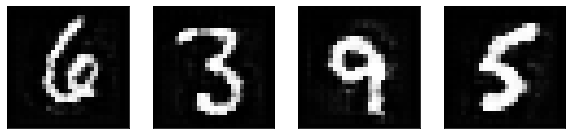

time taken in min: 2.0913987159729004
epoch 143 batch 100 batch total loss 0.0052945605
epoch 143 batch 100 batch cluster loss 1.26629275e-05
epoch 143 batch 100 batch regen loss 0.0052818977
saving...



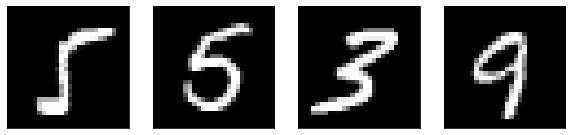

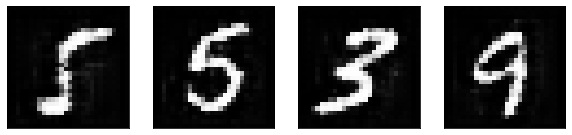

time taken in min: 2.085327156384786

epoch 143 epoch avg loss 0.0054467913647324355
epoch 143 epoch avg cluster loss 1.3340214736980655e-05
epoch 143 epoch avg regen loss 0.00543345115147531



saving...

epoch 144
epoch 144 batch 0 batch total loss 0.0055218902
epoch 144 batch 0 batch cluster loss 1.3248799e-05
epoch 144 batch 0 batch regen loss 0.0055086412
saving...



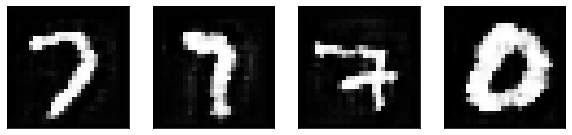

time taken in min: 0.7202299912770589
epoch 144 batch 50 batch total loss 0.0054385755
epoch 144 batch 50 batch cluster loss 1.3605318e-05
epoch 144 batch 50 batch regen loss 0.0054249703
saving...



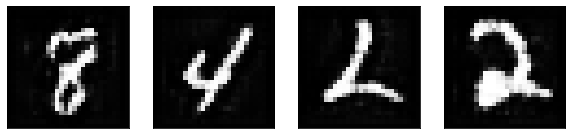

time taken in min: 2.0885721842447915
epoch 144 batch 100 batch total loss 0.005443334
epoch 144 batch 100 batch cluster loss 1.3190342e-05
epoch 144 batch 100 batch regen loss 0.005430144
saving...



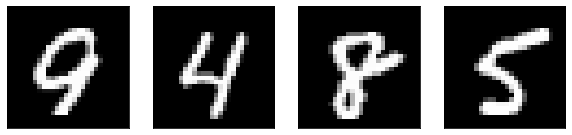

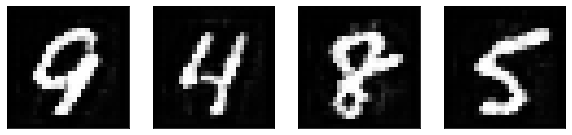

time taken in min: 2.0915314356486

epoch 144 epoch avg loss 0.005438028803189932
epoch 144 epoch avg cluster loss 1.3225241049039434e-05
epoch 144 epoch avg regen loss 0.005424803556969105



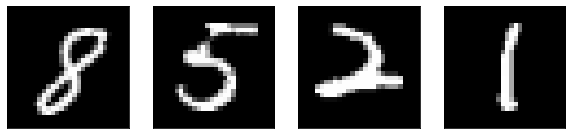

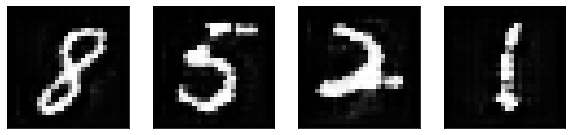

saving...

epoch 145
epoch 145 batch 0 batch total loss 0.0055067837
epoch 145 batch 0 batch cluster loss 1.2993921e-05
epoch 145 batch 0 batch regen loss 0.00549379
saving...



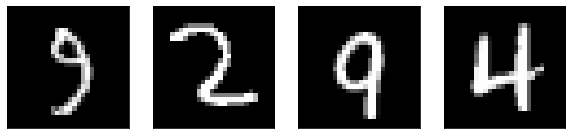

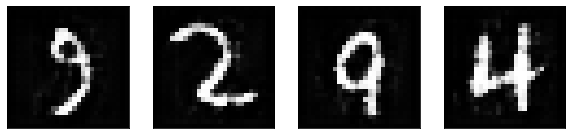

time taken in min: 0.7209505955378215
epoch 145 batch 50 batch total loss 0.0054756897
epoch 145 batch 50 batch cluster loss 1.2957142e-05
epoch 145 batch 50 batch regen loss 0.0054627326
saving...



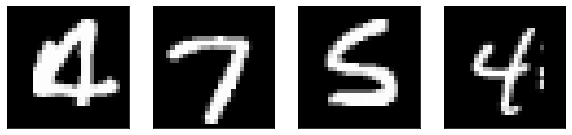

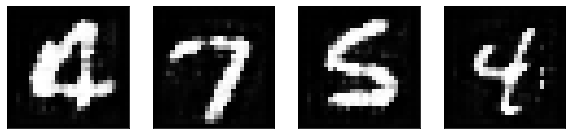

time taken in min: 2.0898579080899555
epoch 145 batch 100 batch total loss 0.005383906
epoch 145 batch 100 batch cluster loss 1.3300556e-05
epoch 145 batch 100 batch regen loss 0.0053706053
saving...



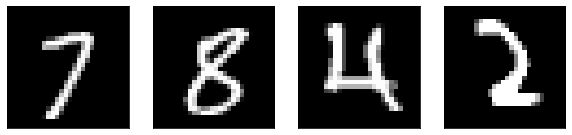

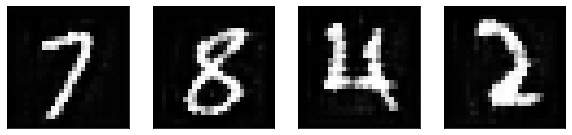

time taken in min: 2.0970872124036153

epoch 145 epoch avg loss 0.005433271564069694
epoch 145 epoch avg cluster loss 1.3143765029827452e-05
epoch 145 epoch avg regen loss 0.005420127800681581



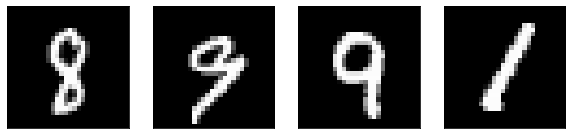

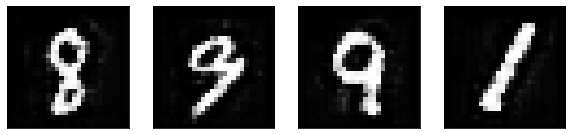

saving...

epoch 146
epoch 146 batch 0 batch total loss 0.0054798247
epoch 146 batch 0 batch cluster loss 1.3691475e-05
epoch 146 batch 0 batch regen loss 0.0054661334
saving...



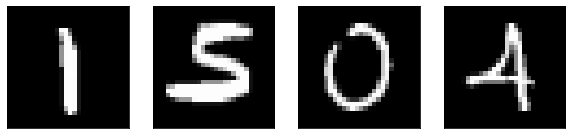

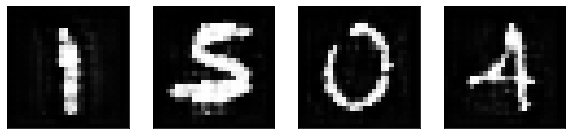

time taken in min: 0.7235677123069764
epoch 146 batch 50 batch total loss 0.0055246684
epoch 146 batch 50 batch cluster loss 1.3614884e-05
epoch 146 batch 50 batch regen loss 0.0055110534
saving...



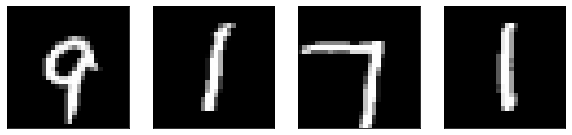

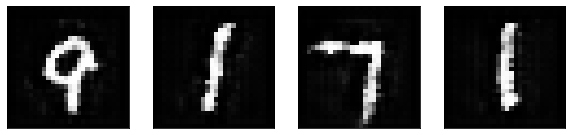

time taken in min: 2.0969497283299763
epoch 146 batch 100 batch total loss 0.0054571014
epoch 146 batch 100 batch cluster loss 1.3130069e-05
epoch 146 batch 100 batch regen loss 0.005443971
saving...



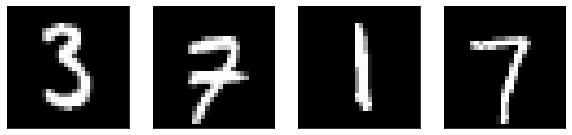

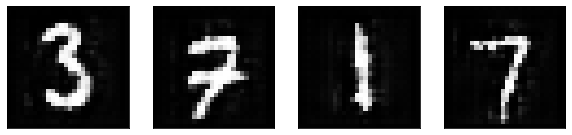

time taken in min: 2.0948699712753296

epoch 146 epoch avg loss 0.00542812796025458
epoch 146 epoch avg cluster loss 1.3111030535059152e-05
epoch 146 epoch avg regen loss 0.005415016923383888



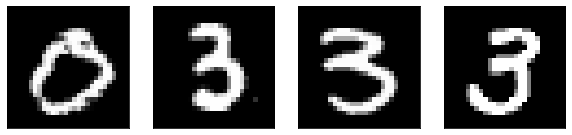

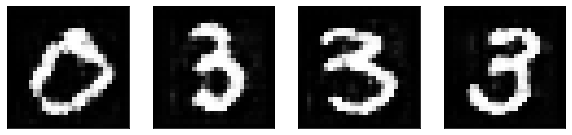

saving...

epoch 147
epoch 147 batch 0 batch total loss 0.005428742
epoch 147 batch 0 batch cluster loss 1.3150678e-05
epoch 147 batch 0 batch regen loss 0.0054155914
saving...



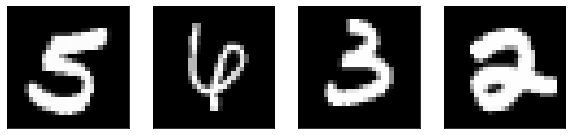

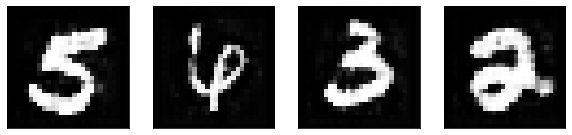

time taken in min: 0.7229084769884745
epoch 147 batch 50 batch total loss 0.0054677753
epoch 147 batch 50 batch cluster loss 1.2934011e-05
epoch 147 batch 50 batch regen loss 0.005454841
saving...



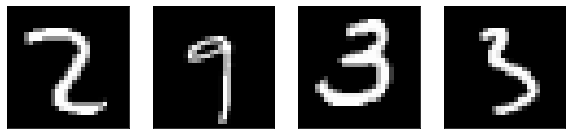

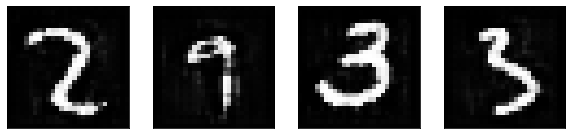

time taken in min: 2.0825660705566404
epoch 147 batch 100 batch total loss 0.00537511
epoch 147 batch 100 batch cluster loss 1.2963968e-05
epoch 147 batch 100 batch regen loss 0.005362146
saving...



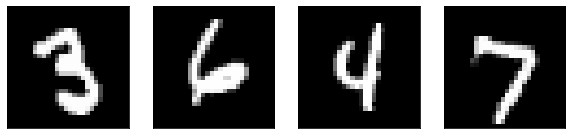

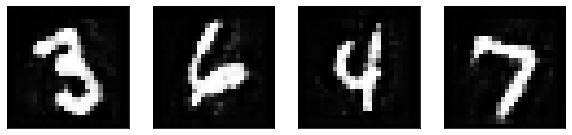

time taken in min: 2.086755069096883

epoch 147 epoch avg loss 0.005422284234694
epoch 147 epoch avg cluster loss 1.3059932509843177e-05
epoch 147 epoch avg regen loss 0.005409224274552474



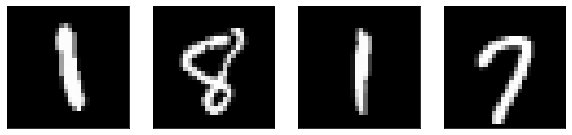

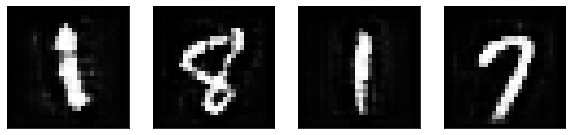

saving...

epoch 148
epoch 148 batch 0 batch total loss 0.005328176
epoch 148 batch 0 batch cluster loss 1.2401428e-05
epoch 148 batch 0 batch regen loss 0.0053157746
saving...



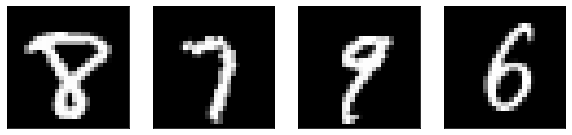

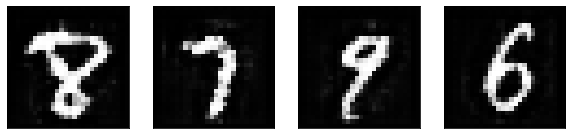

time taken in min: 0.7219658017158508
epoch 148 batch 50 batch total loss 0.005288398
epoch 148 batch 50 batch cluster loss 1.2582926e-05
epoch 148 batch 50 batch regen loss 0.005275815
saving...



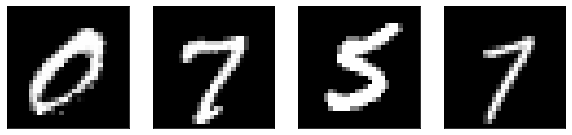

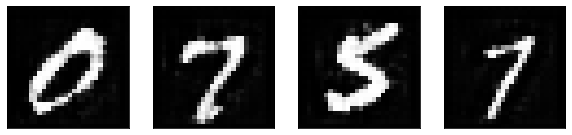

time taken in min: 2.093169637521108
epoch 148 batch 100 batch total loss 0.0054221097
epoch 148 batch 100 batch cluster loss 1.2189705e-05
epoch 148 batch 100 batch regen loss 0.00540992
saving...



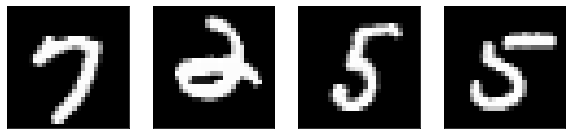

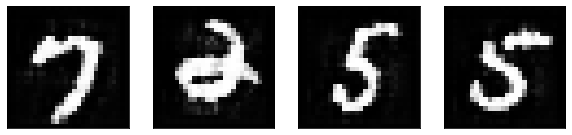

time taken in min: 2.0941786328951517

epoch 148 epoch avg loss 0.005415247571733543
epoch 148 epoch avg cluster loss 1.2931854953267711e-05
epoch 148 epoch avg regen loss 0.005402315723693977



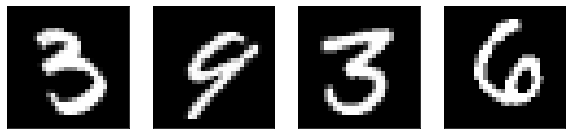

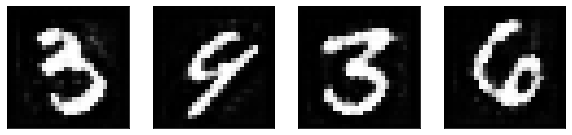

saving...

epoch 149
epoch 149 batch 0 batch total loss 0.0054712365
epoch 149 batch 0 batch cluster loss 1.2632243e-05
epoch 149 batch 0 batch regen loss 0.005458604
saving...



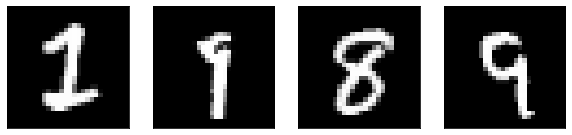

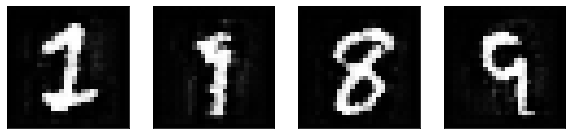

time taken in min: 0.7174529075622559
epoch 149 batch 50 batch total loss 0.0053127
epoch 149 batch 50 batch cluster loss 1.34665925e-05
epoch 149 batch 50 batch regen loss 0.0052992334
saving...



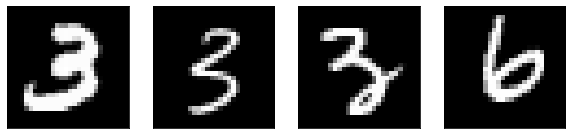

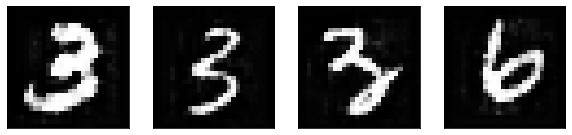

time taken in min: 2.0883584062258405
epoch 149 batch 100 batch total loss 0.0055009974
epoch 149 batch 100 batch cluster loss 1.3146288e-05
epoch 149 batch 100 batch regen loss 0.0054878513
saving...



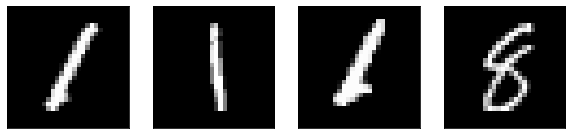

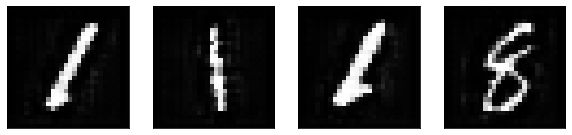

time taken in min: 2.0910151918729145

epoch 149 epoch avg loss 0.005413372748357765
epoch 149 epoch avg cluster loss 1.2828359134708358e-05
epoch 149 epoch avg regen loss 0.005400544391566162



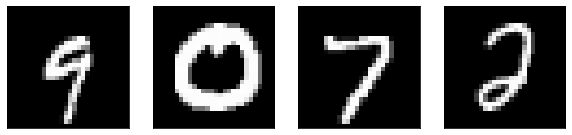

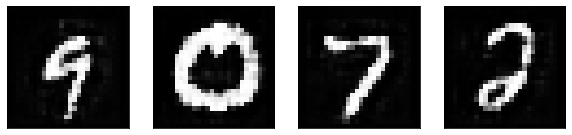

saving...



In [44]:
import time

epoch_avg_total_loss = [0]*total_epochs

epoch_avg_cluster_loss = [0]*total_epochs

epoch_avg_regen_loss = [0]*total_epochs

total_loss_win = 0
cluster_loss_win = 0
regen_loss_win = 0

#To time the code
t = time.time()


#This training is done with the regeneration loss &  loss from the LSTMs
for epoch in range(total_epochs):
  
    print('epoch', epoch)
  
    avg_total_loss = 0
    avg_cluster_loss = 0
    avg_regen_loss = 0
    total_batches = 0
    
    for batch_idx, (x, target) in enumerate(train_loader):
        
        x, target = x.cuda(), target.numpy()

        x_, z = model(x)
        
        trajects = ms_clust(z.t())
        
        path_z = path_embed(trajects)
        
        total_loss, cluster_loss, regen_loss = ms_ae_loss(x, x_, path_z, target)
    
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
        avg_total_loss += total_loss.cpu().detach().numpy()
        avg_cluster_loss += cluster_loss.cpu().detach().numpy()
        avg_regen_loss += regen_loss.cpu().detach().numpy()
    
        if batch_idx % 50 == 0:
            print('epoch', epoch, 'batch', batch_idx, 'batch total loss', total_loss.cpu().detach().numpy())
            print('epoch', epoch, 'batch', batch_idx, 'batch cluster loss', cluster_loss.cpu().detach().numpy())
            print('epoch', epoch, 'batch', batch_idx, 'batch regen loss', regen_loss.cpu().detach().numpy())
            print('saving...')
            torch.save(model.state_dict(), '/home/ankitas/btp_mean_shift/save/'+sname+'_model.pt')
            torch.save(path_embed.lstm.state_dict(), '/home/ankitas/btp_mean_shift/save/'+sname+'_lstm.pt')
            print()
            plot_regen(model)
            print('time taken in min:', (time.time() - t)/60)
            t = time.time()
        total_batches += 1
   
    epoch_avg_total_loss[epoch] = avg_total_loss/total_batches
    epoch_avg_cluster_loss[epoch] = avg_cluster_loss/total_batches
    epoch_avg_regen_loss[epoch] = avg_regen_loss/total_batches
  
    loss_file = open('/home/ankitas/btp_mean_shift/save/loss_list_'+sname+'.pkl', 'wb+')
    pickle.dump([epoch_avg_total_loss, epoch_avg_cluster_loss, epoch_avg_regen_loss], loss_file)
    loss_file.close()
  
    print()
    print('epoch', epoch, 'epoch avg loss', epoch_avg_total_loss[epoch])
    print('epoch', epoch, 'epoch avg cluster loss', epoch_avg_cluster_loss[epoch])
    print('epoch', epoch, 'epoch avg regen loss', epoch_avg_regen_loss[epoch])
    print()
    
    if epoch == 0:
        total_loss_win = vis.line(
            X=np.ones(1)*(epoch+1),
            Y=np.array([epoch_avg_total_loss[epoch]]),
            opts=dict(xlabel='epoch',title='Pre Regen MS LSTM: Delta=1 Norm Weight=100',ylabel='Total Loss',legend=['Loss']))

        cluster_loss_win = vis.line(
            X=np.ones(1)*(epoch+1),
            Y=np.array([epoch_avg_cluster_loss[epoch]]),
            opts=dict(xlabel='epoch',title='Pre Regen MS LSTM: Delta=1 Norm Weight=100',ylabel='Cluster Loss',legend=['Loss']))

        regen_loss_win = vis.line(
            X=np.ones(1)*(epoch+1),
            Y=np.array([epoch_avg_regen_loss[epoch]]),
            opts=dict(xlabel='epoch',title='Pre Regen MS LSTM: Delta=1 Norm Weight=100',ylabel='Regen Loss',legend=['Loss']))
    else:
        vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_total_loss[epoch]]),win=total_loss_win,update='append')
        vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_cluster_loss[epoch]]),win=cluster_loss_win,update='append')
        vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_regen_loss[epoch]]),win=regen_loss_win,update='append')
    plot_regen(model)
    print('saving...')
    torch.save(model.state_dict(), '/home/ankitas/btp_mean_shift/save/'+sname+'_model.pt')
    torch.save(path_embed.lstm.state_dict(), '/home/ankitas/btp_mean_shift/save/'+sname+'_lstm.pt')
    print()
 
  

# Cluster w/o mean shift

## Load Model

In [ ]:
embedding_dim=64
model=AE(embedding_dim)
model.load_state_dict(torch.load('/content/gdrive/My Drive/mean shift data/ms_ae_shift.pt'))
model = model.cuda()

## Load Data

In [ ]:
train_batch_size = 600
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=train_batch_size,
                 shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=test_batch_size,
                shuffle=False)

print ('total trainning batch number: '+ str(len(train_loader)))
print ('total testing batch number: '+ str(len(test_loader)))

## Append embeddings

In [ ]:
#Saving the models
f = open('/content/gdrive/My Drive/mean shift data/shift_embeds.pkl', 'wb+')
pickle.dump(embeds, f)
f.close()

f = open('/content/gdrive/My Drive/mean shift data/shift_labels.pkl', 'wb+')
pickle.dump(labels, f)
f.close()

## t-SNE 

In [ ]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2)

X = t_sne.fit_transform(embeds)

print(X.shape)

f = open('/content/gdrive/My Drive/mean shift data/tsne_shift_20.pkl', 'wb+')
pickle.dump(X, f)
f.close()

## Plot Scatter

In [ ]:
import matplotlib.cm as cm

x = 1

cs = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(cs)))
plt.figure(figsize=(20,10))
for i, c in enumerate(colors):
    plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], c=c, s=20, edgecolors='k', label=i+1)
plt.legend()
plt.show()